In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [5]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

cfg.plotStep = 10
cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 1
cfg.learningRate = 0.1


cfg.normalShiftLevel = 10
# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
cfg.faces_per_pixel = 15

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

cfg.lpSmootherW = 1
# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 1

renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder =  r'F:\WorkingCopy2\2020_06_04_SilhouetteExtraction\3052\Silhouette'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealData\SilhouettePoseFitting_Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002\FinalMesh.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataSilhouette'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

In [7]:
# load Images
image_refs_out, crops_out = load_images(imageFolder, cropSize=cfg.imgSize)

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [8]:
cams_torch['fl']

tensor([[1.7616, 1.7604],
        [1.7548, 1.7537],
        [1.7569, 1.7558],
        [1.7568, 1.7558],
        [1.7532, 1.7523],
        [1.7562, 1.7548],
        [1.7579, 1.7567],
        [1.7568, 1.7555],
        [1.7565, 1.7552],
        [1.7648, 1.7633],
        [1.7565, 1.7554],
        [1.7601, 1.7592],
        [1.7568, 1.7557],
        [1.7585, 1.7573],
        [1.7578, 1.7566],
        [1.7564, 1.7553]])

In [9]:
cams = init_camera_batches(cams_torch, device)

In [10]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [11]:
aux.normals.shape

torch.Size([6750, 3])

In [12]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [13]:
normalShiftRef = torch.tensor(np.full((nVerts,1), cfg.normalShiftLevel), dtype=torch.float32, device=device)

In [14]:
nNormals

tensor([[ 0.7492, -0.5342,  0.3916],
        [ 0.6932, -0.5724,  0.4381],
        [ 0.8451, -0.4086,  0.3448],
        ...,
        [ 0.4438, -0.8176,  0.3667],
        [ 0.5171, -0.5400, -0.6641],
        [-0.9180, -0.3009, -0.2582]], device='cuda:0')

In [15]:
normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

In [16]:
modifiedVerts = verts + normalShift * nNormals
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [17]:
modifiedVerts.requires_grad

True

In [18]:
expName = 'Sig_' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ 'ImS' + str(cfg.imgSize) + "_LR" + str(cfg.learningRate) + "_LW" + str(cfg.lpSmootherW) + "_NW" + str(cfg.normalSmootherW)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataSilhouette\Sig_1e-07_BR1e-07_Fpp15_NCams16ImS1080_LR0.1_LW1_NW1


In [19]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


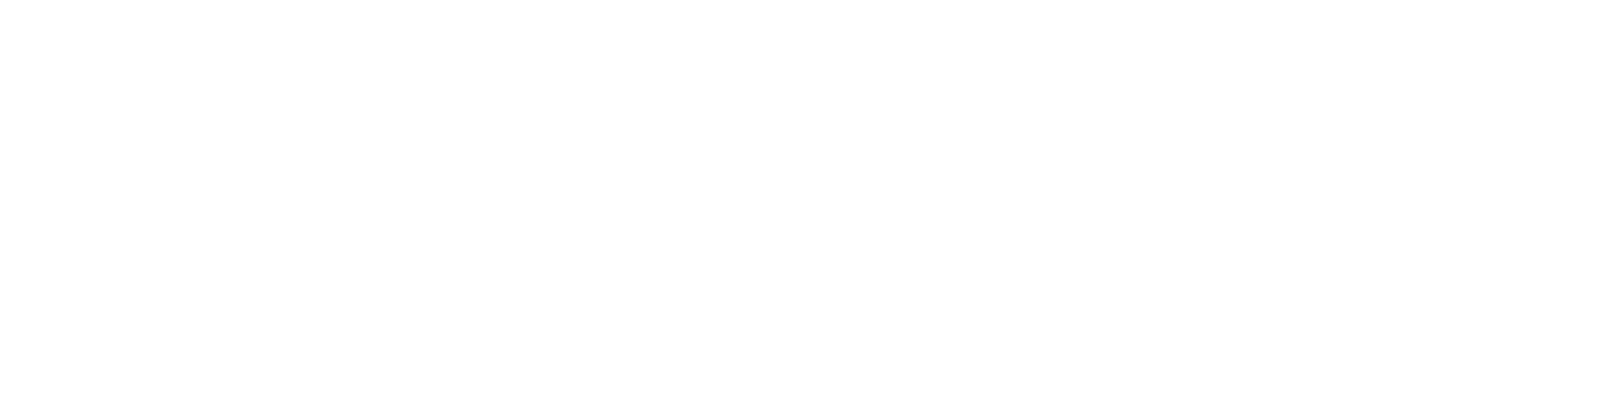

Before release: active_bytes.all.current: 20.67712 MB
After release: active_bytes.all.current: 20.67712 MB


In [20]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DResults(images)
showCudaMemUsage(device)

In [21]:
diffImages = []
imagesRef = []

loss = 0
for iCam in range(len(cams)):
    imagesRef.append(crops_out[iCam][...,0])
    imgDiff = np.abs(images[iCam][0, ..., 3] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [22]:
print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_laplacian_smoothing tensor(2.5977, device='cuda:0')
mesh_normal_consistency tensor(0.0467, device='cuda:0')


<IPython.core.display.Javascript object>


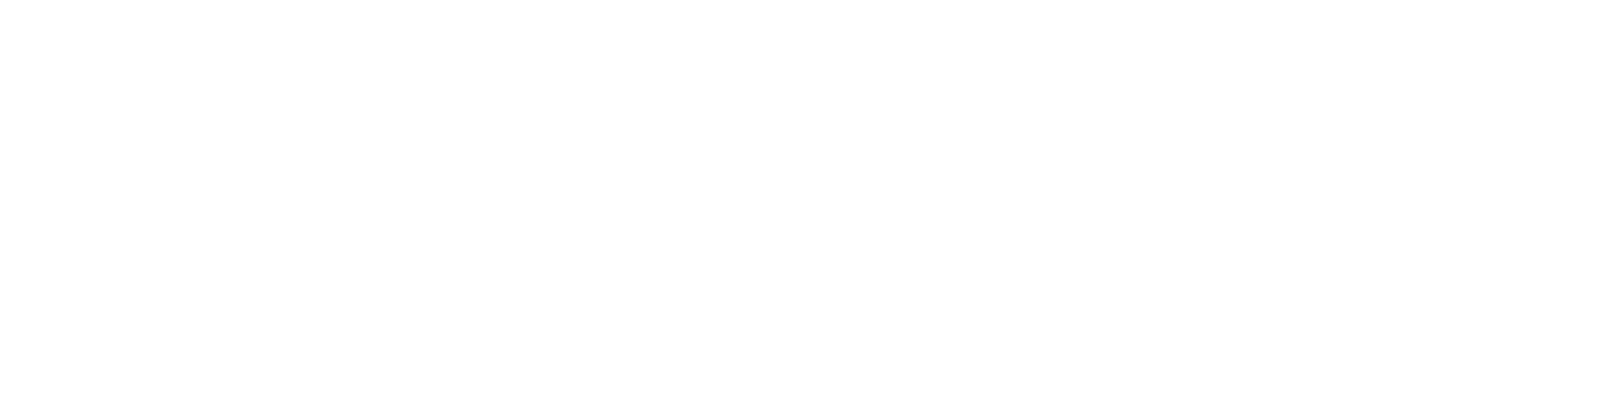

In [23]:
visualize2DResults(diffImages,pytorch3DImg=False)

In [24]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
cfg.plotStep = 5
# cfg.learningRate = 3

In [25]:
optimizer = torch.optim.Adam([normalShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [26]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 22.434304 MB
After release: active_bytes.all.current: 22.434304 MB


In [27]:
cams

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


2020-06-07 18:29:00,551 logger INFO loss 3.96, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


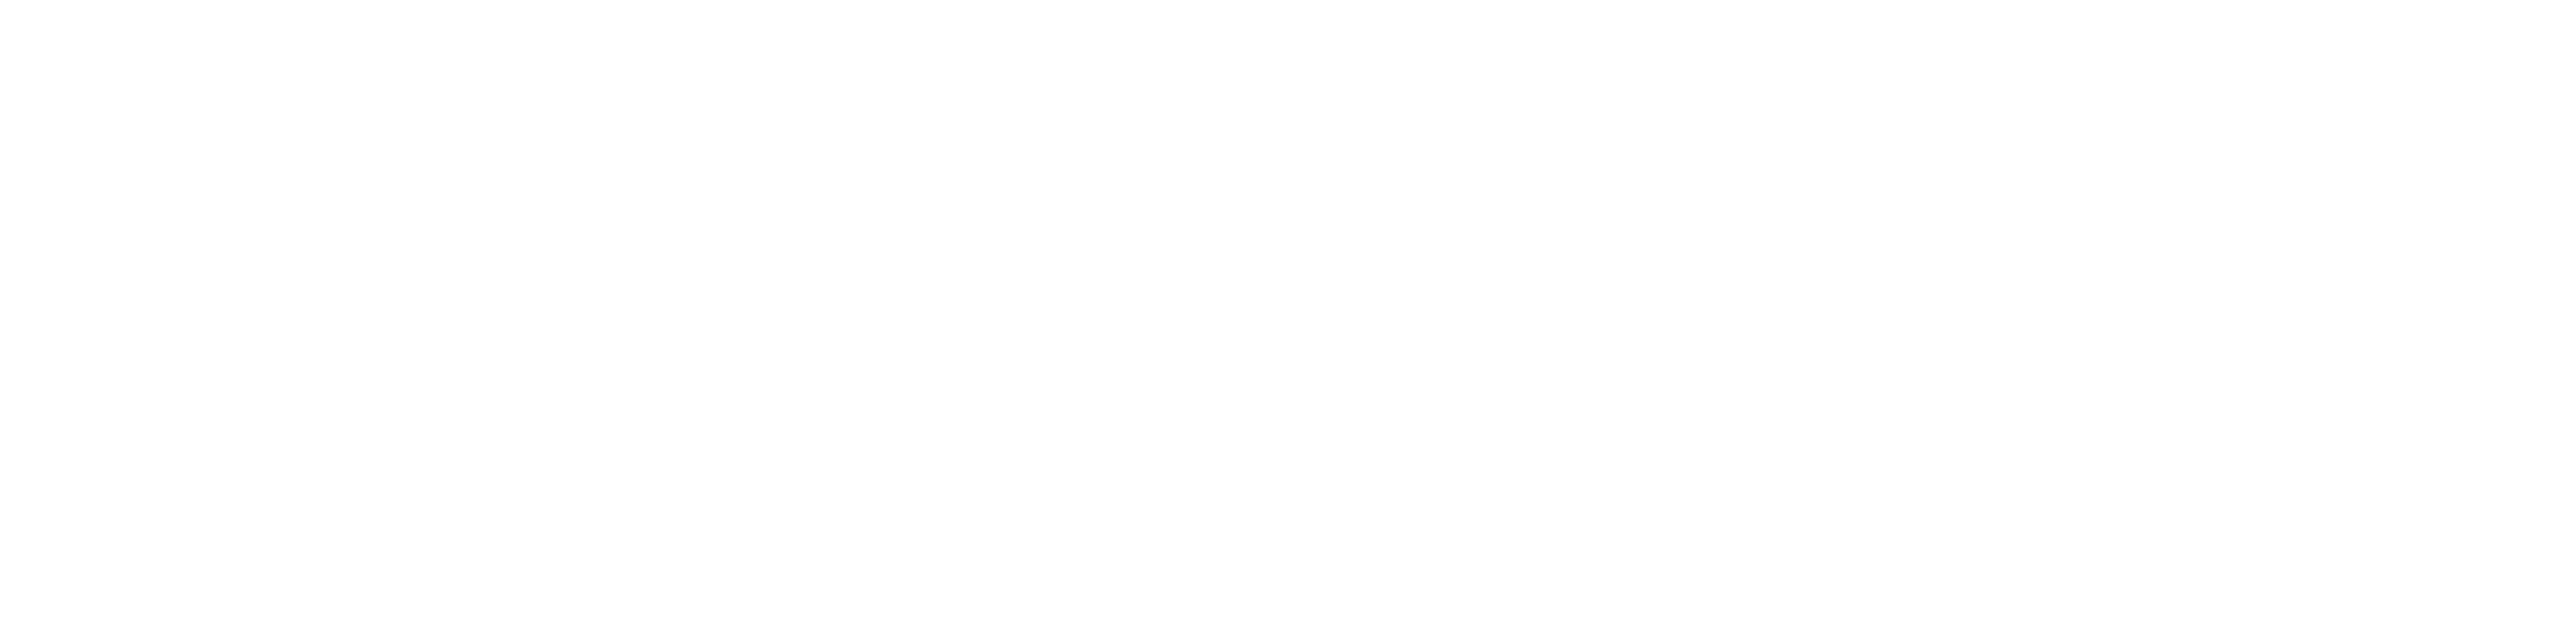

2020-06-07 18:29:24,248 logger INFO loss 3.93, MemUsed:50.05
2020-06-07 18:29:30,340 logger INFO loss 3.90, MemUsed:50.05
2020-06-07 18:29:36,402 logger INFO loss 3.88, MemUsed:50.05
2020-06-07 18:29:42,516 logger INFO loss 3.86, MemUsed:50.05
2020-06-07 18:29:48,597 logger INFO loss 3.84, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


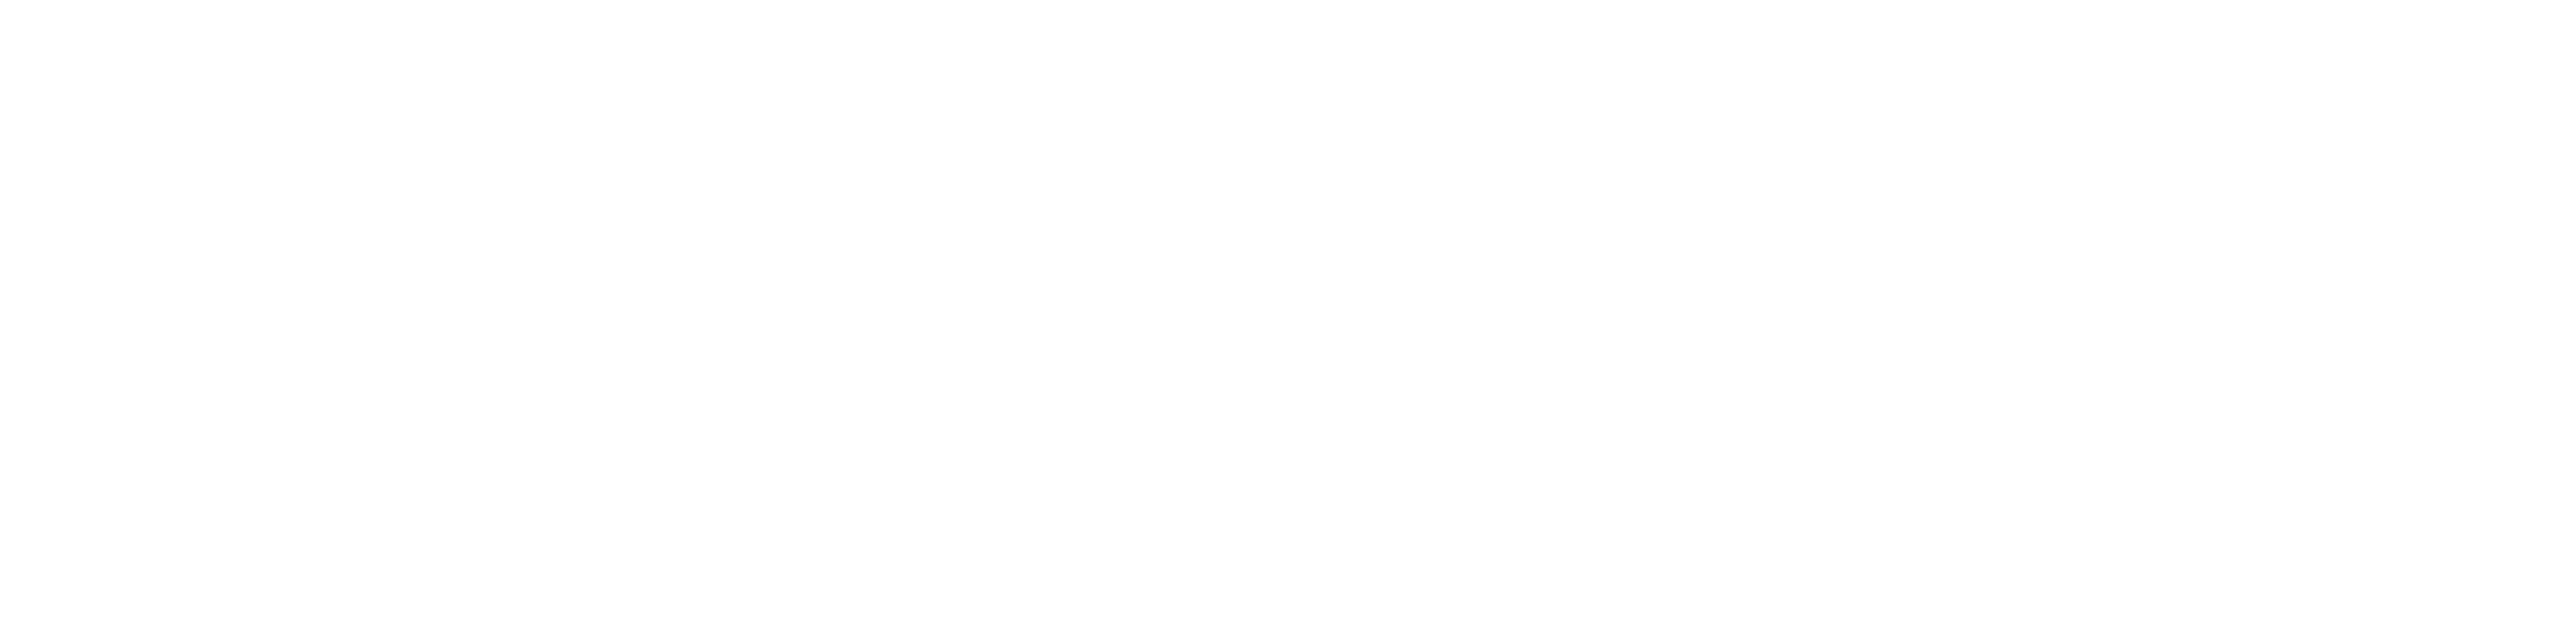

2020-06-07 18:30:12,370 logger INFO loss 3.82, MemUsed:50.05
2020-06-07 18:30:18,471 logger INFO loss 3.80, MemUsed:50.05
2020-06-07 18:30:24,577 logger INFO loss 3.78, MemUsed:50.05
2020-06-07 18:30:30,696 logger INFO loss 3.77, MemUsed:50.05
2020-06-07 18:30:36,794 logger INFO loss 3.75, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


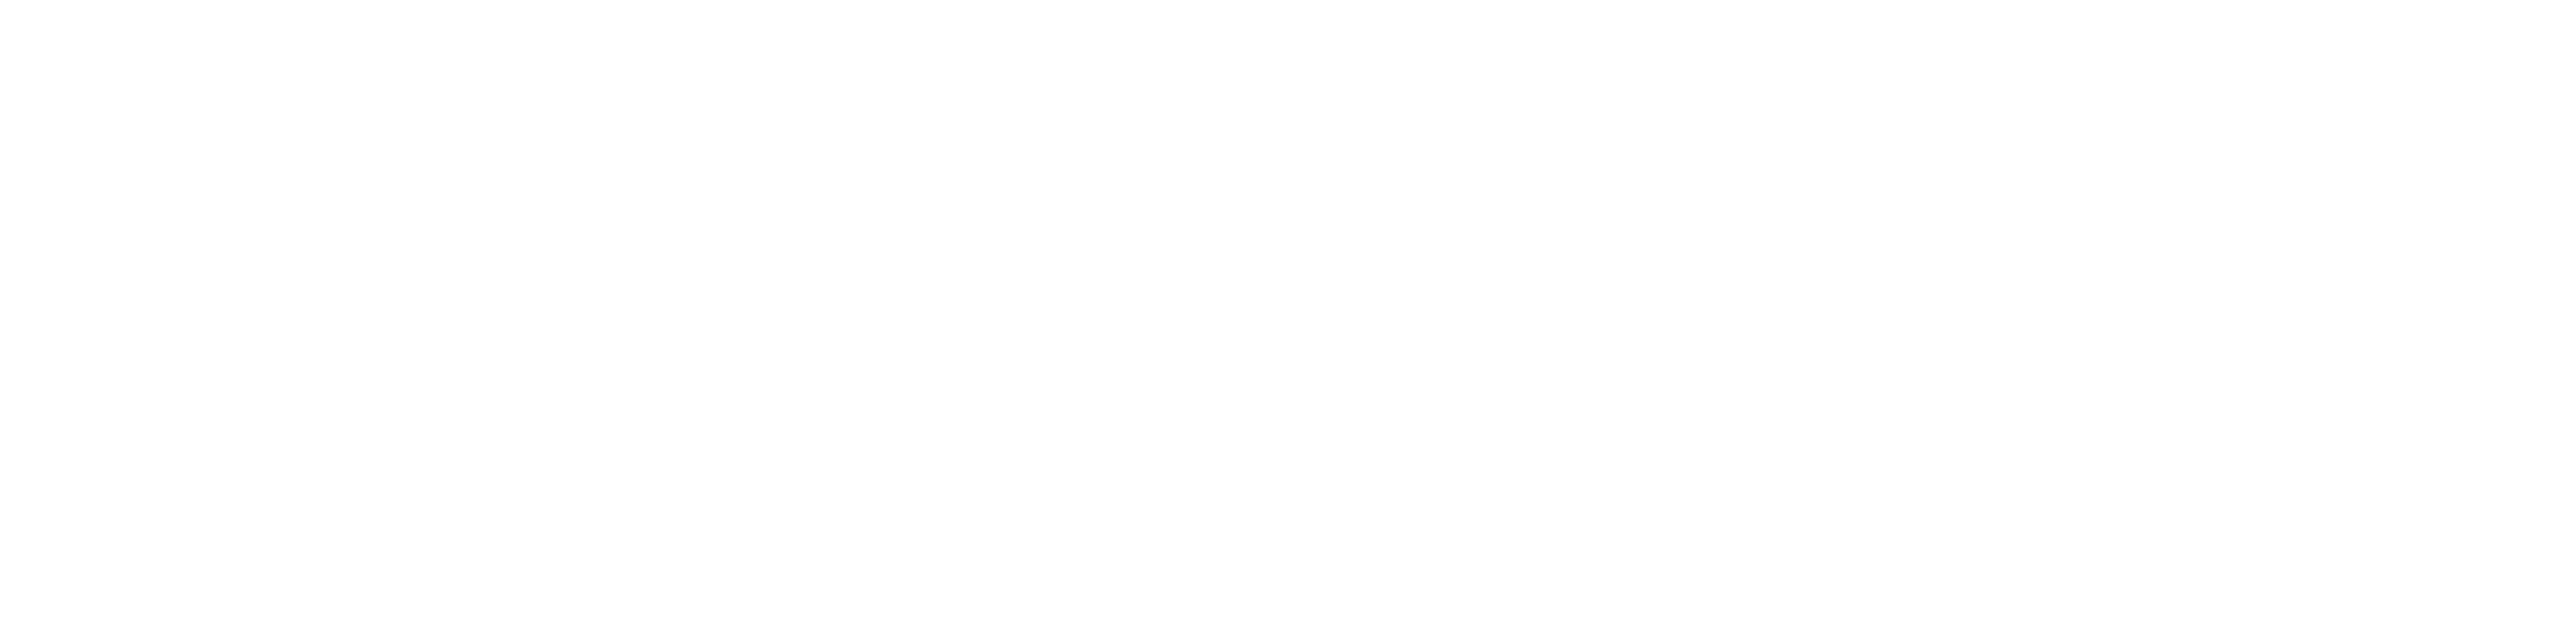

2020-06-07 18:31:00,649 logger INFO loss 3.74, MemUsed:50.05
2020-06-07 18:31:06,784 logger INFO loss 3.73, MemUsed:50.05
2020-06-07 18:31:12,935 logger INFO loss 3.72, MemUsed:50.05
2020-06-07 18:31:19,013 logger INFO loss 3.70, MemUsed:50.05
2020-06-07 18:31:25,147 logger INFO loss 3.69, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


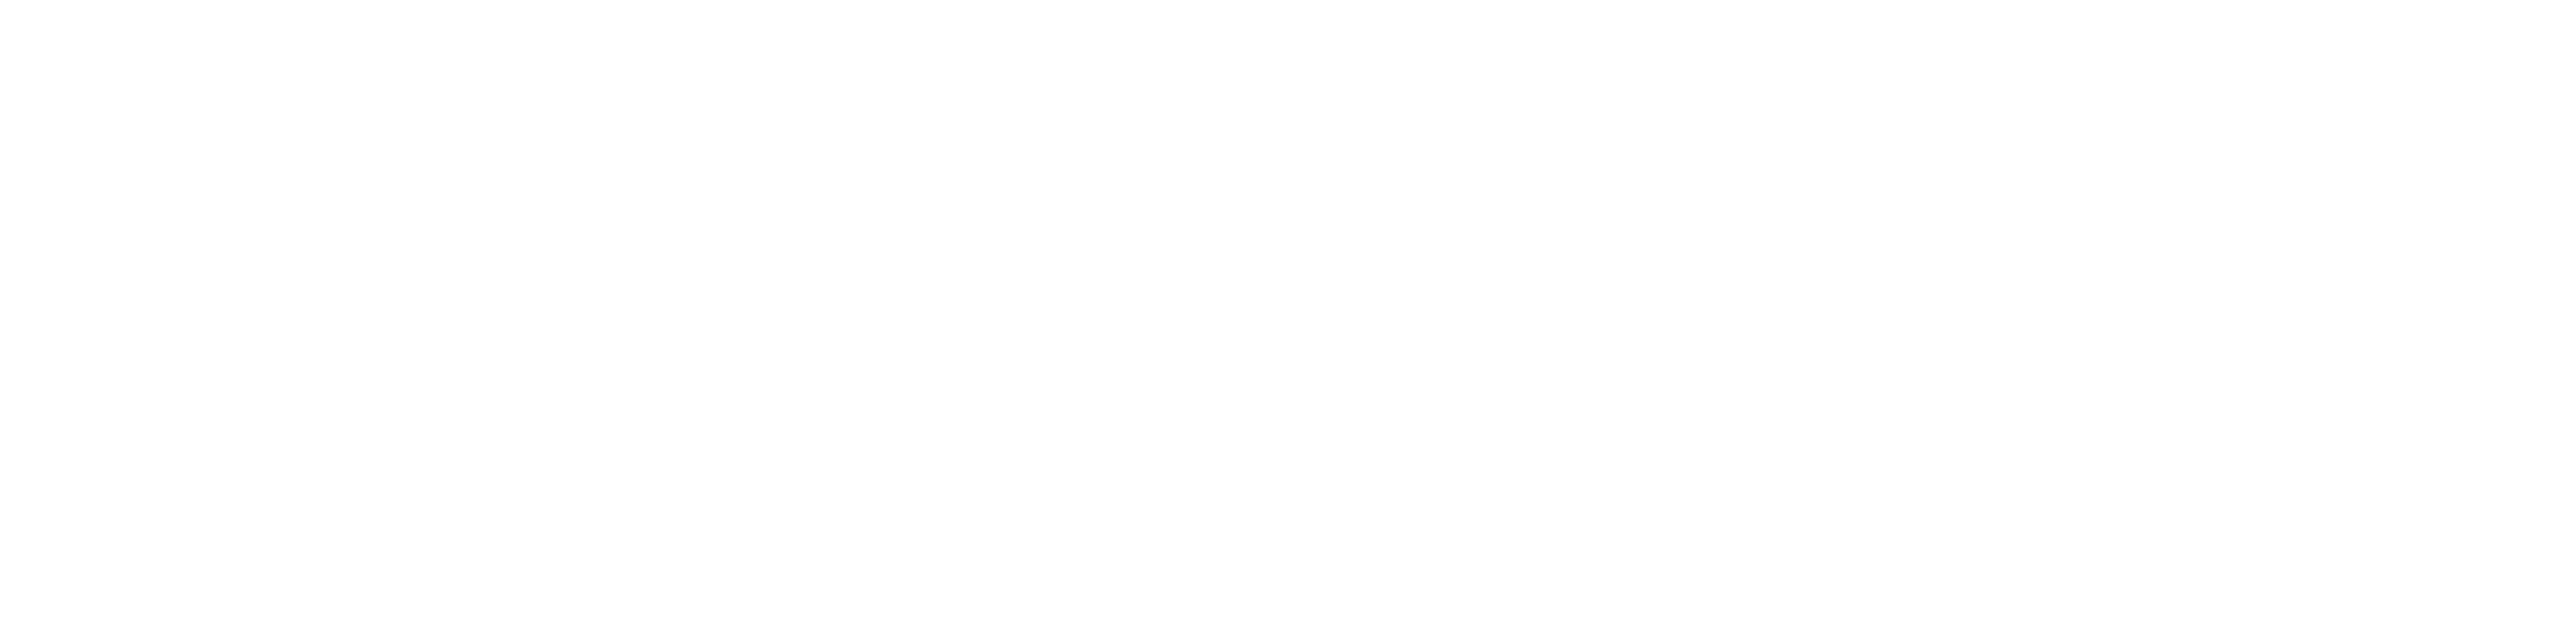

2020-06-07 18:31:48,867 logger INFO loss 3.68, MemUsed:50.05
2020-06-07 18:31:55,038 logger INFO loss 3.67, MemUsed:50.05
2020-06-07 18:32:01,106 logger INFO loss 3.66, MemUsed:50.05
2020-06-07 18:32:07,227 logger INFO loss 3.65, MemUsed:50.05
2020-06-07 18:32:13,317 logger INFO loss 3.64, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


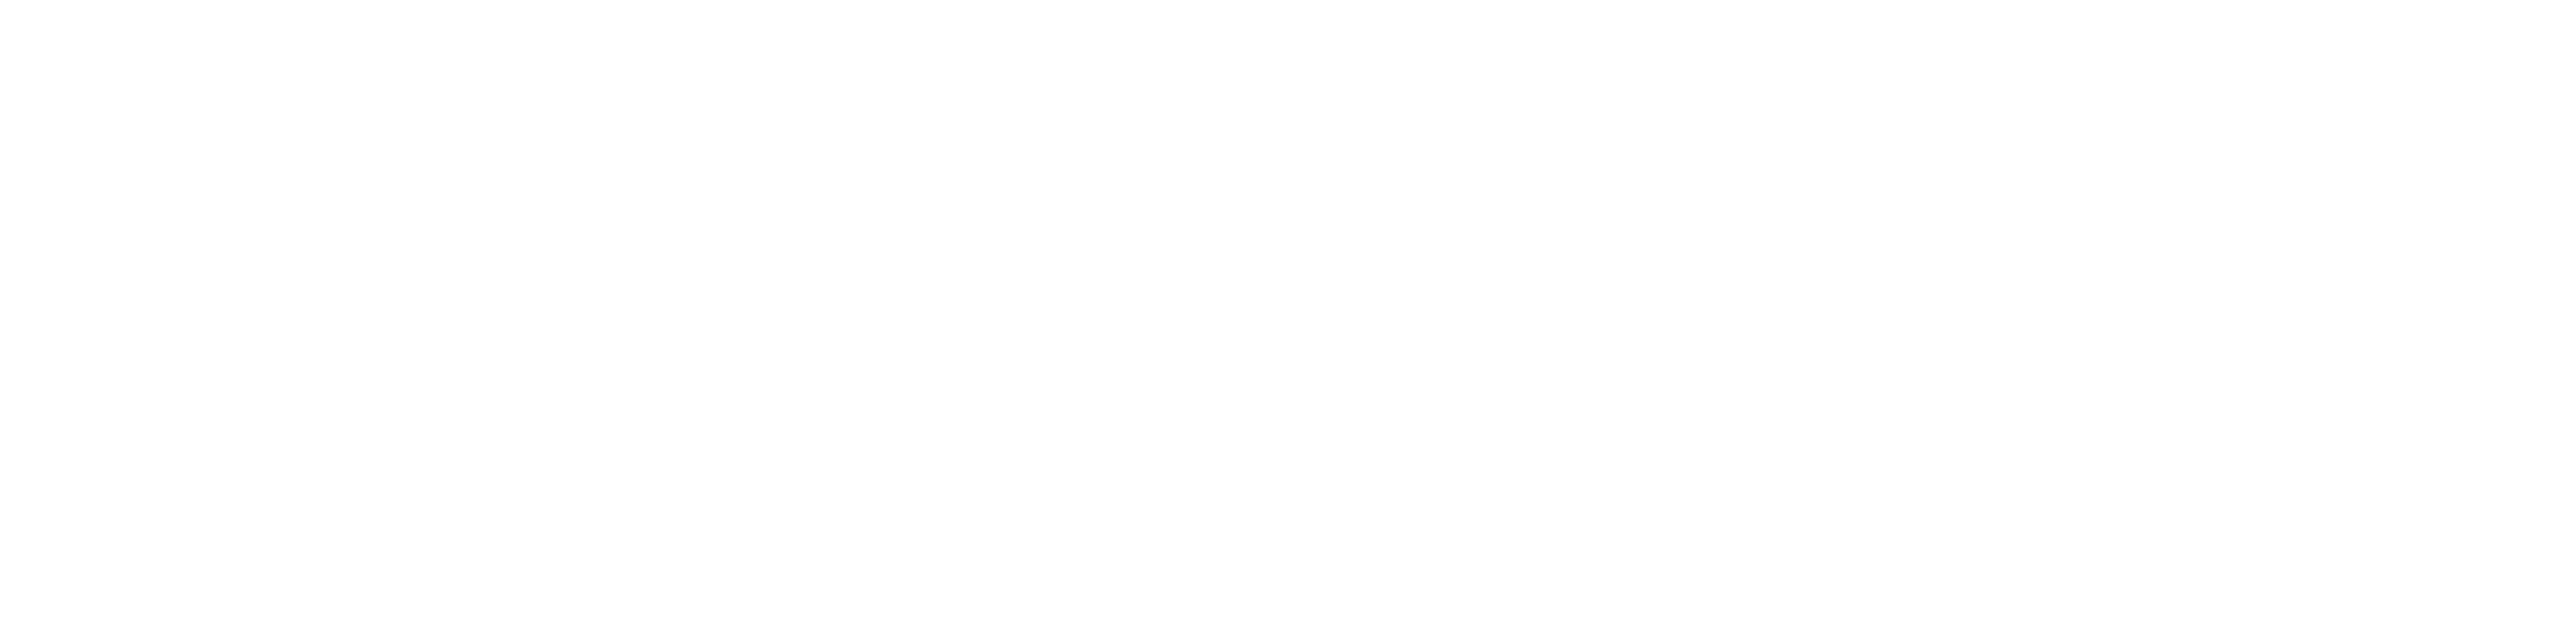

2020-06-07 18:32:37,136 logger INFO loss 3.63, MemUsed:50.05
2020-06-07 18:32:43,227 logger INFO loss 3.63, MemUsed:50.05
2020-06-07 18:32:49,371 logger INFO loss 3.62, MemUsed:50.05
2020-06-07 18:32:55,453 logger INFO loss 3.61, MemUsed:50.05
2020-06-07 18:33:01,583 logger INFO loss 3.60, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


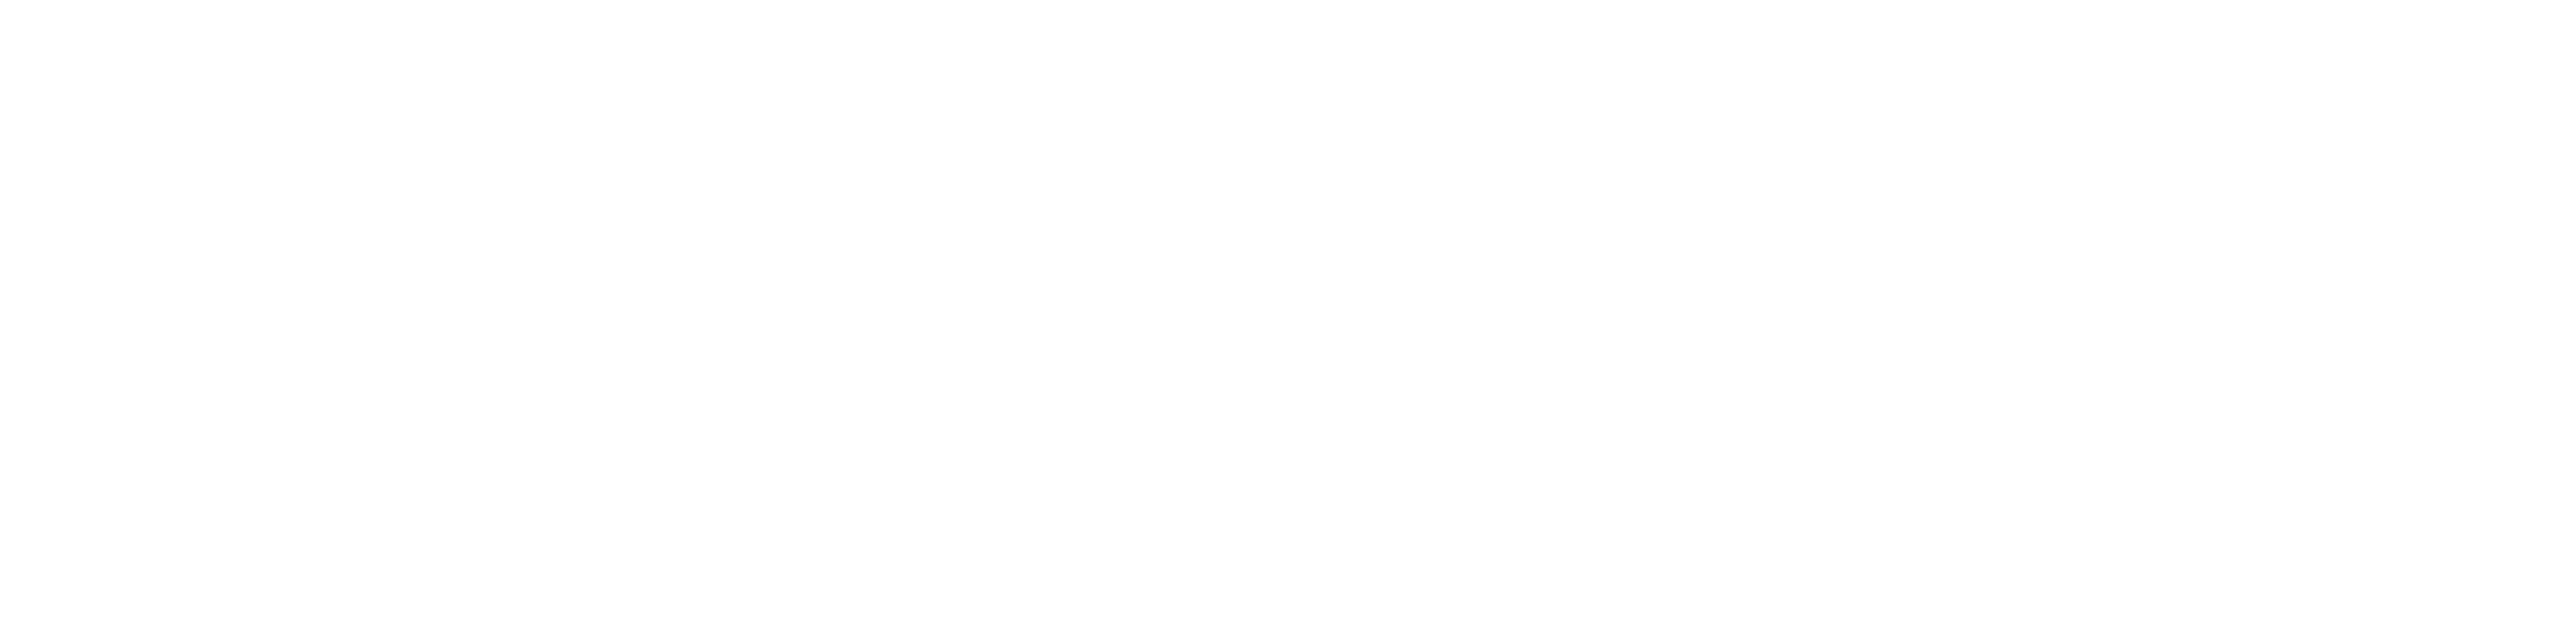

2020-06-07 18:33:25,349 logger INFO loss 3.59, MemUsed:50.05
2020-06-07 18:33:31,517 logger INFO loss 3.59, MemUsed:50.05
2020-06-07 18:33:37,601 logger INFO loss 3.58, MemUsed:50.05
2020-06-07 18:33:43,732 logger INFO loss 3.57, MemUsed:50.05
2020-06-07 18:33:49,822 logger INFO loss 3.57, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


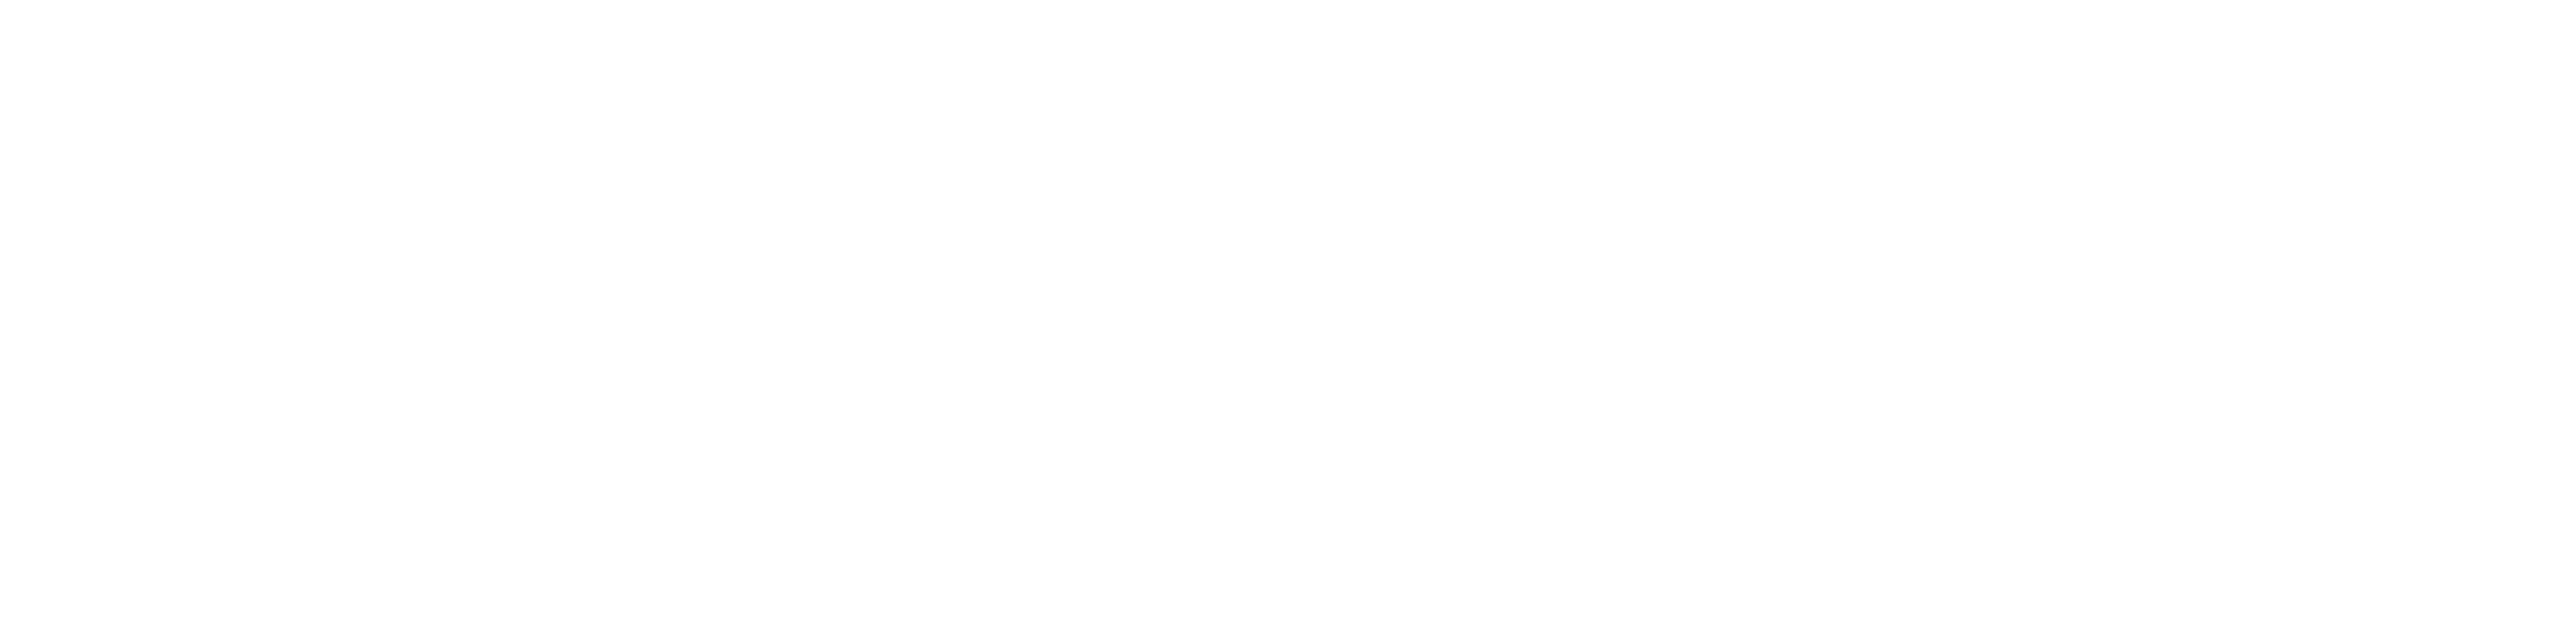

2020-06-07 18:34:13,735 logger INFO loss 3.56, MemUsed:50.05
2020-06-07 18:34:19,847 logger INFO loss 3.56, MemUsed:50.05
2020-06-07 18:34:25,982 logger INFO loss 3.55, MemUsed:50.05
2020-06-07 18:34:32,060 logger INFO loss 3.54, MemUsed:50.05
2020-06-07 18:34:38,189 logger INFO loss 3.54, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


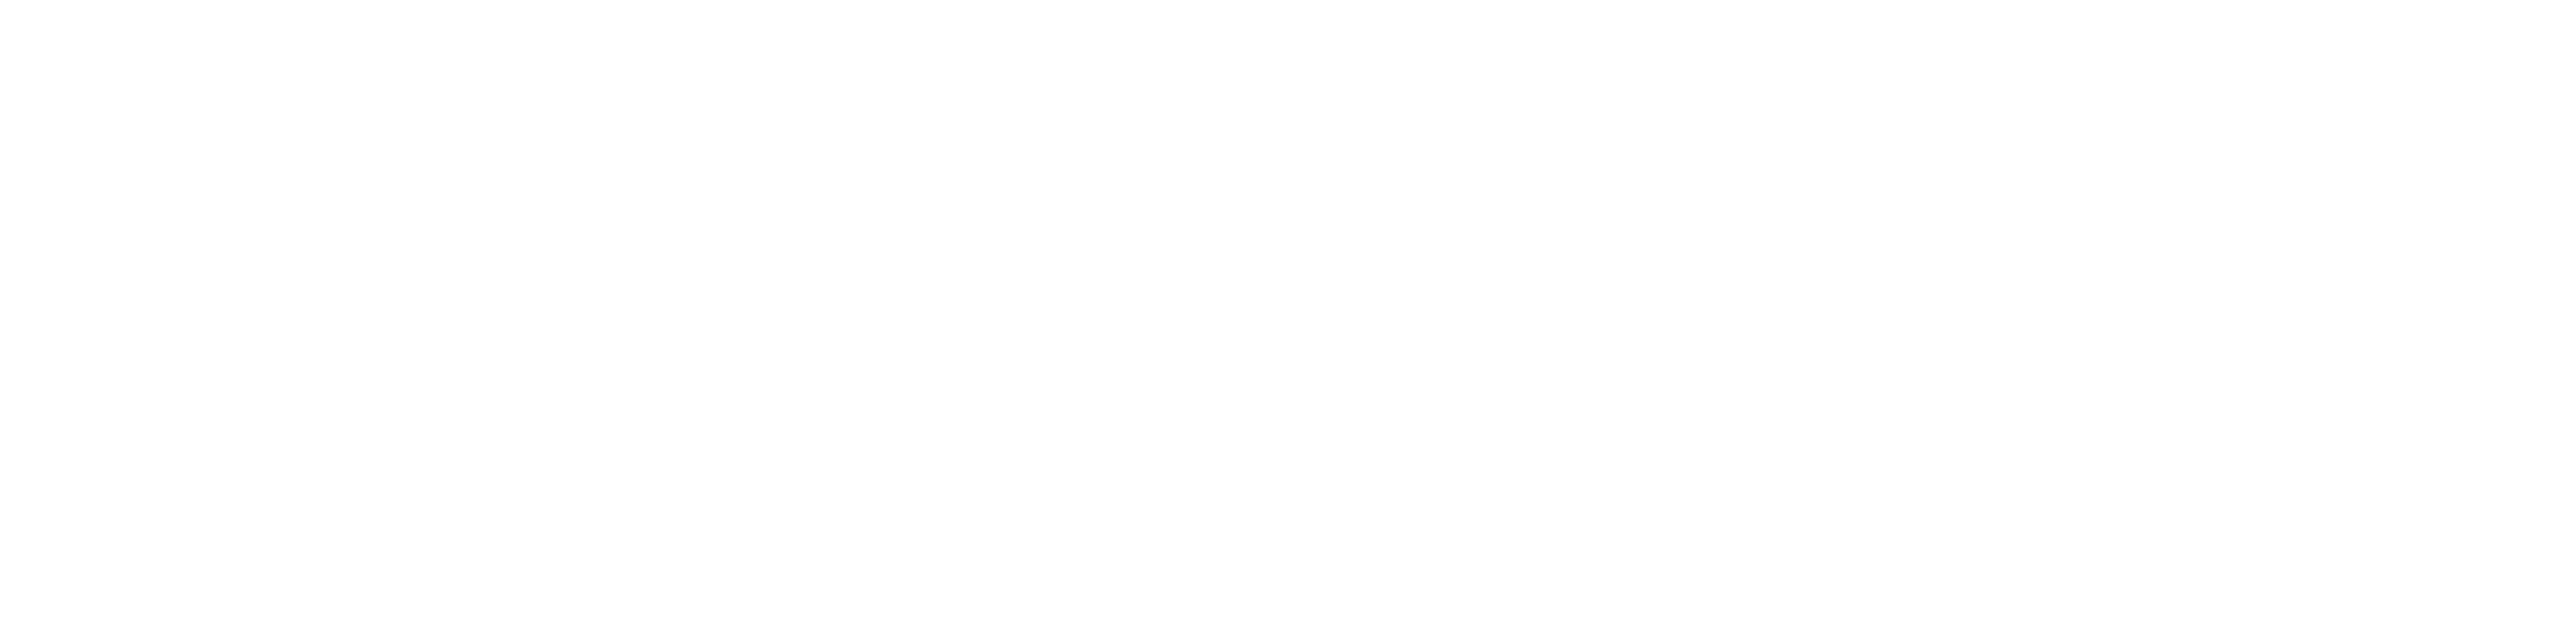

2020-06-07 18:35:01,987 logger INFO loss 3.53, MemUsed:50.05
2020-06-07 18:35:08,064 logger INFO loss 3.53, MemUsed:50.05
2020-06-07 18:35:14,197 logger INFO loss 3.52, MemUsed:50.05
2020-06-07 18:35:20,274 logger INFO loss 3.52, MemUsed:50.05
2020-06-07 18:35:26,368 logger INFO loss 3.51, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


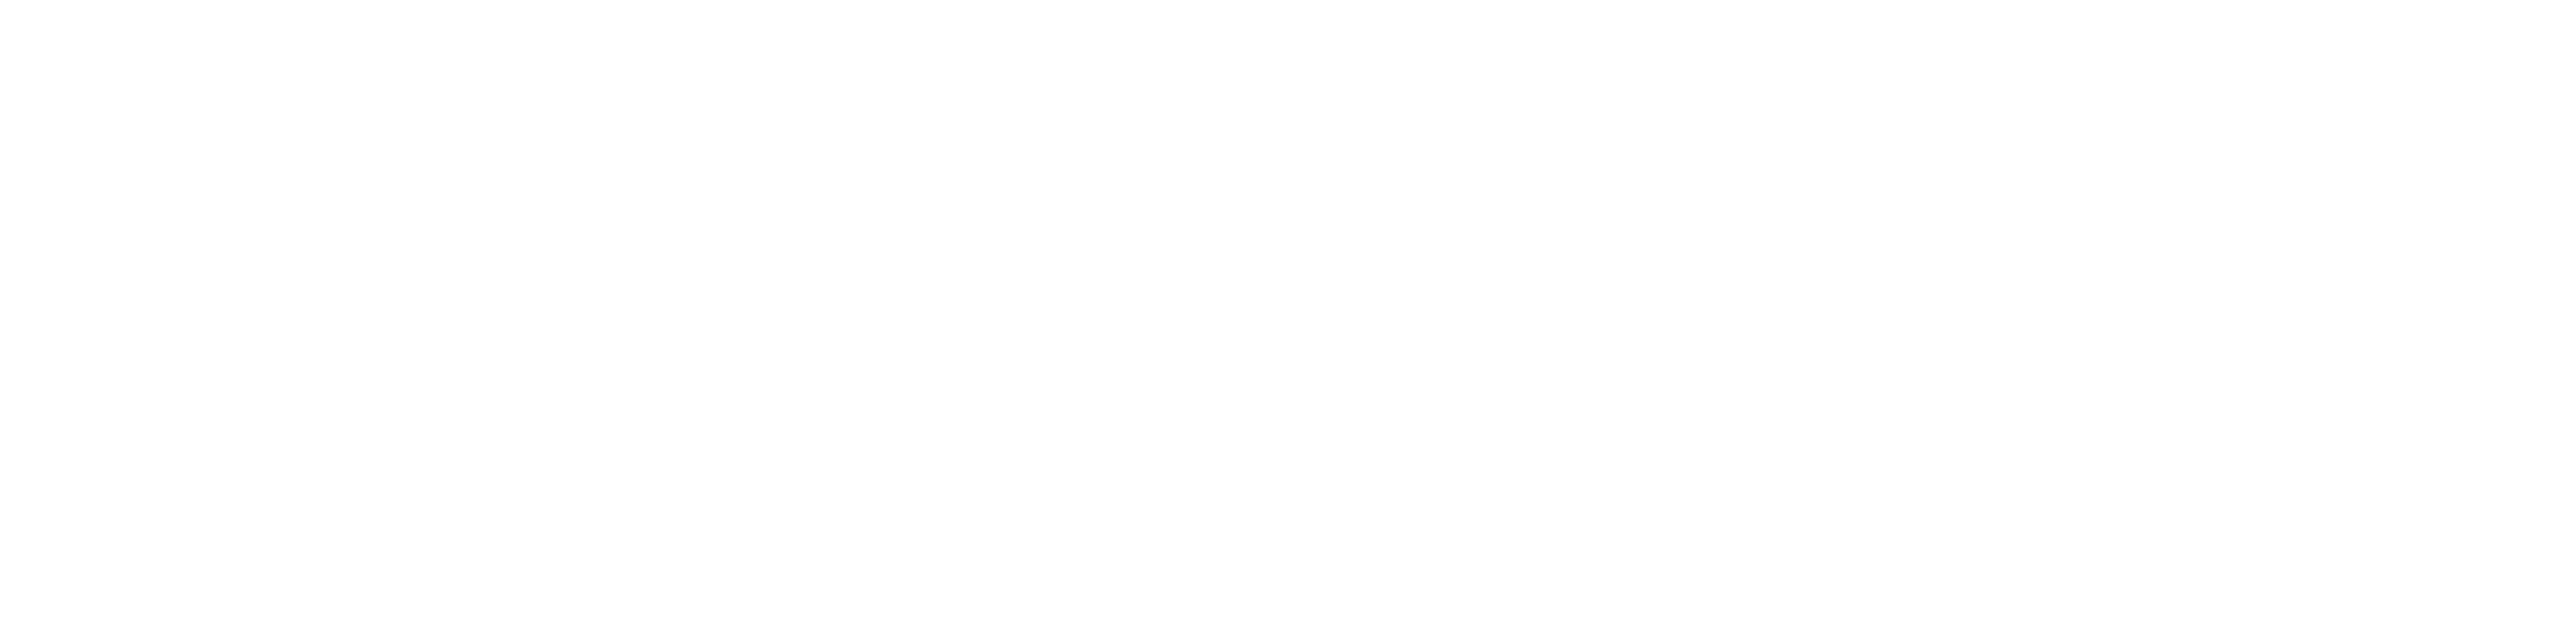

2020-06-07 18:35:50,230 logger INFO loss 3.51, MemUsed:50.05
2020-06-07 18:35:56,362 logger INFO loss 3.50, MemUsed:50.05
2020-06-07 18:36:02,453 logger INFO loss 3.50, MemUsed:50.05
2020-06-07 18:36:08,579 logger INFO loss 3.50, MemUsed:50.05
2020-06-07 18:36:14,682 logger INFO loss 3.49, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


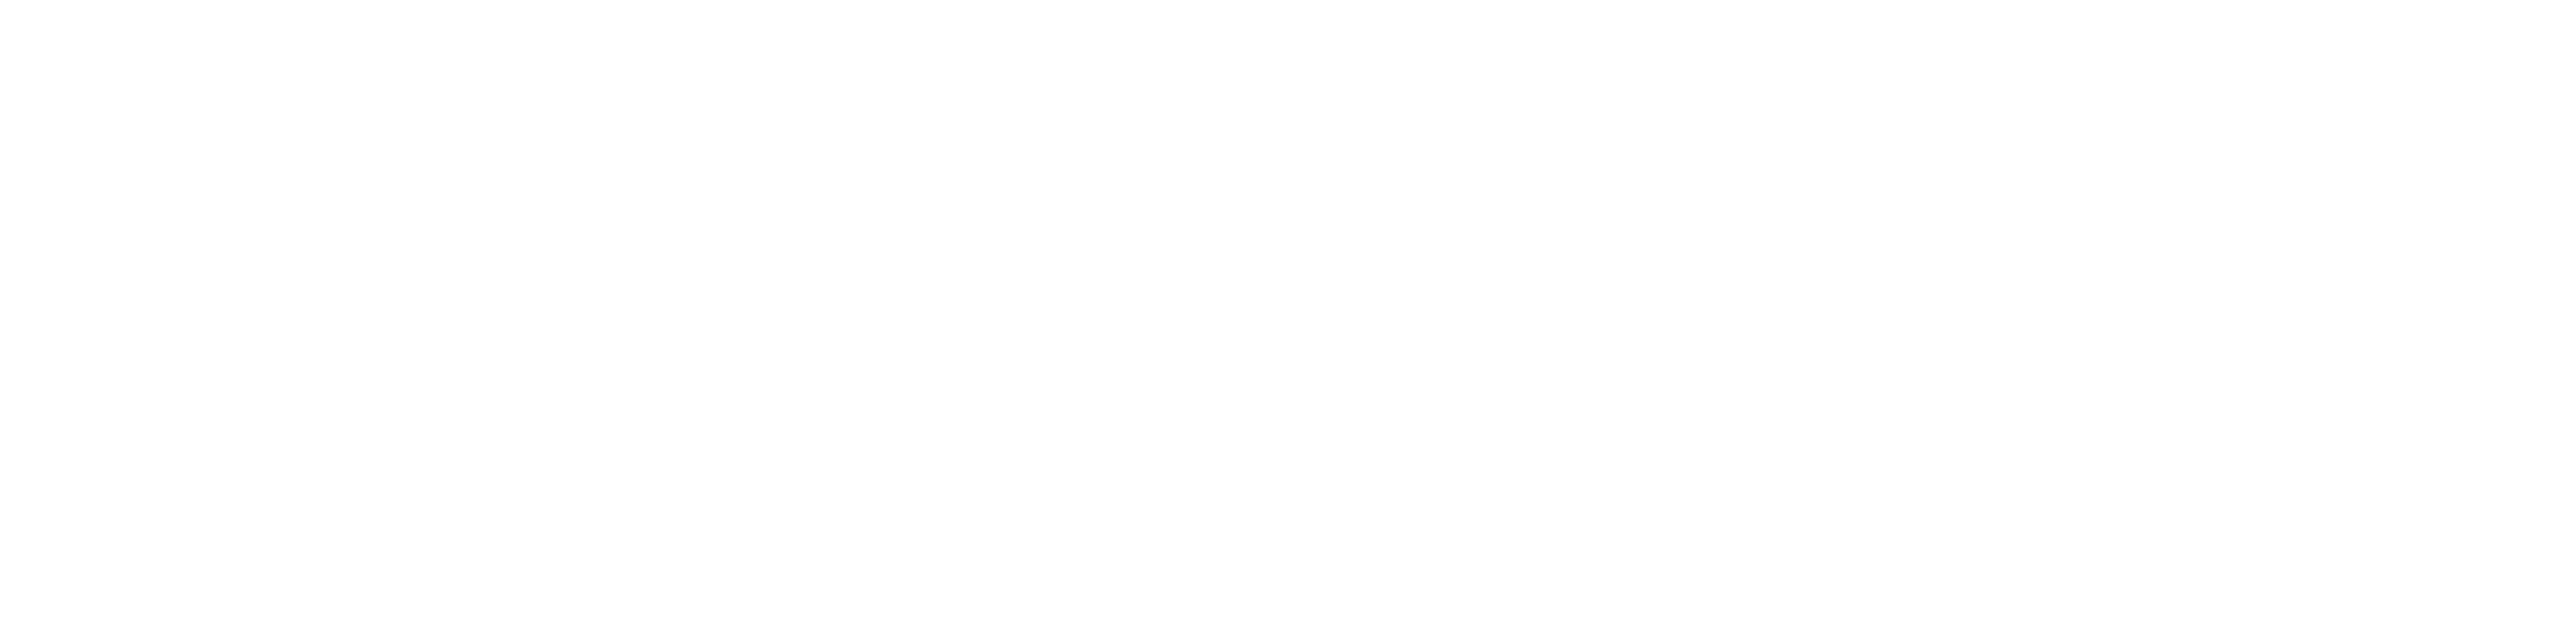

2020-06-07 18:36:38,577 logger INFO loss 3.49, MemUsed:50.05
2020-06-07 18:36:44,663 logger INFO loss 3.48, MemUsed:50.05
2020-06-07 18:36:50,789 logger INFO loss 3.48, MemUsed:50.05
2020-06-07 18:36:56,874 logger INFO loss 3.48, MemUsed:50.05
2020-06-07 18:37:03,026 logger INFO loss 3.47, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


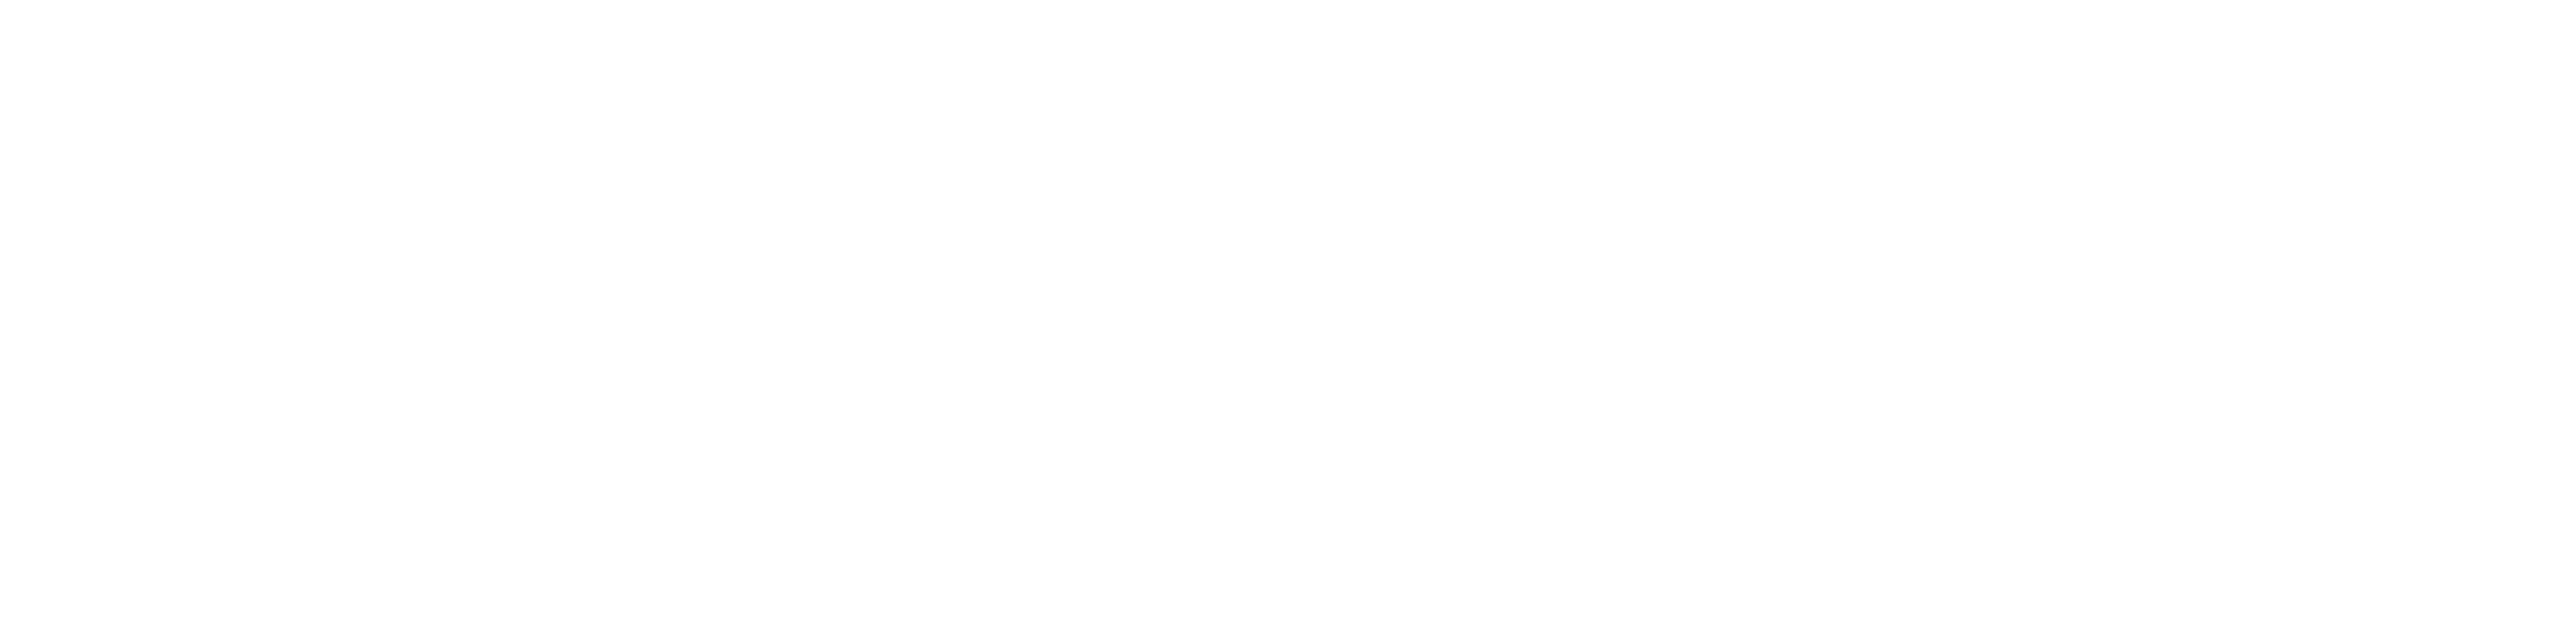

2020-06-07 18:37:26,753 logger INFO loss 3.47, MemUsed:50.05
2020-06-07 18:37:32,901 logger INFO loss 3.47, MemUsed:50.05
2020-06-07 18:37:38,974 logger INFO loss 3.46, MemUsed:50.05
2020-06-07 18:37:45,115 logger INFO loss 3.46, MemUsed:50.05
2020-06-07 18:37:51,204 logger INFO loss 3.46, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


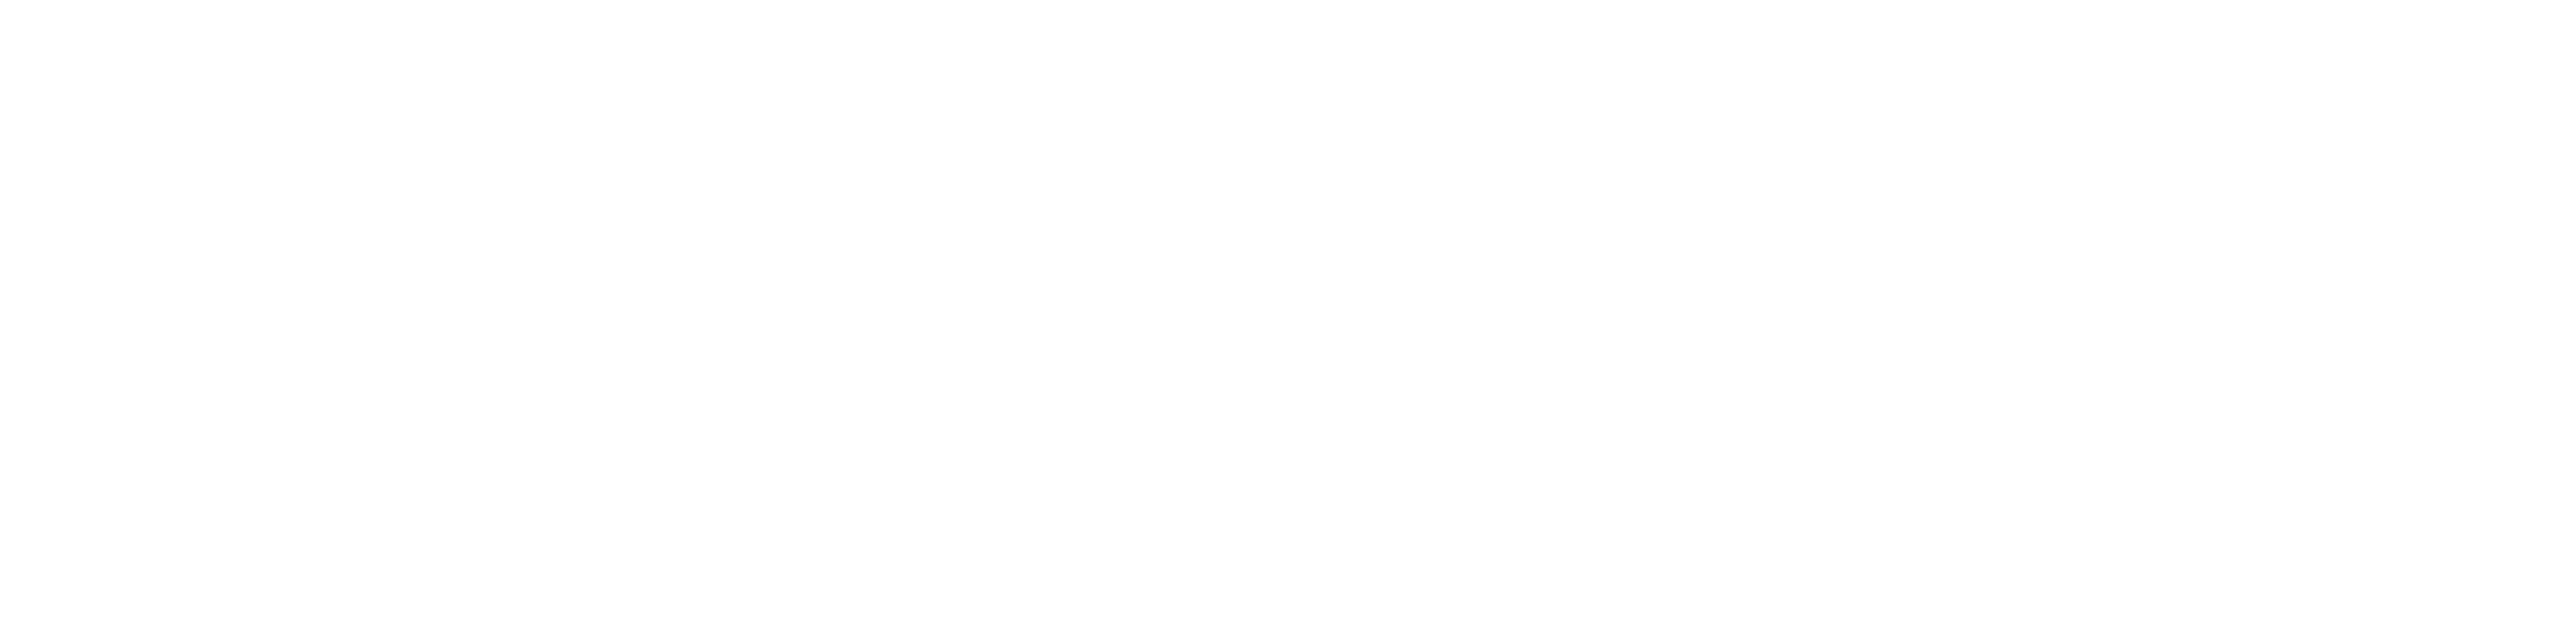

2020-06-07 18:38:15,059 logger INFO loss 3.45, MemUsed:50.05
2020-06-07 18:38:21,134 logger INFO loss 3.45, MemUsed:50.05
2020-06-07 18:38:27,288 logger INFO loss 3.45, MemUsed:50.05
2020-06-07 18:38:33,382 logger INFO loss 3.44, MemUsed:50.05
2020-06-07 18:38:39,539 logger INFO loss 3.44, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


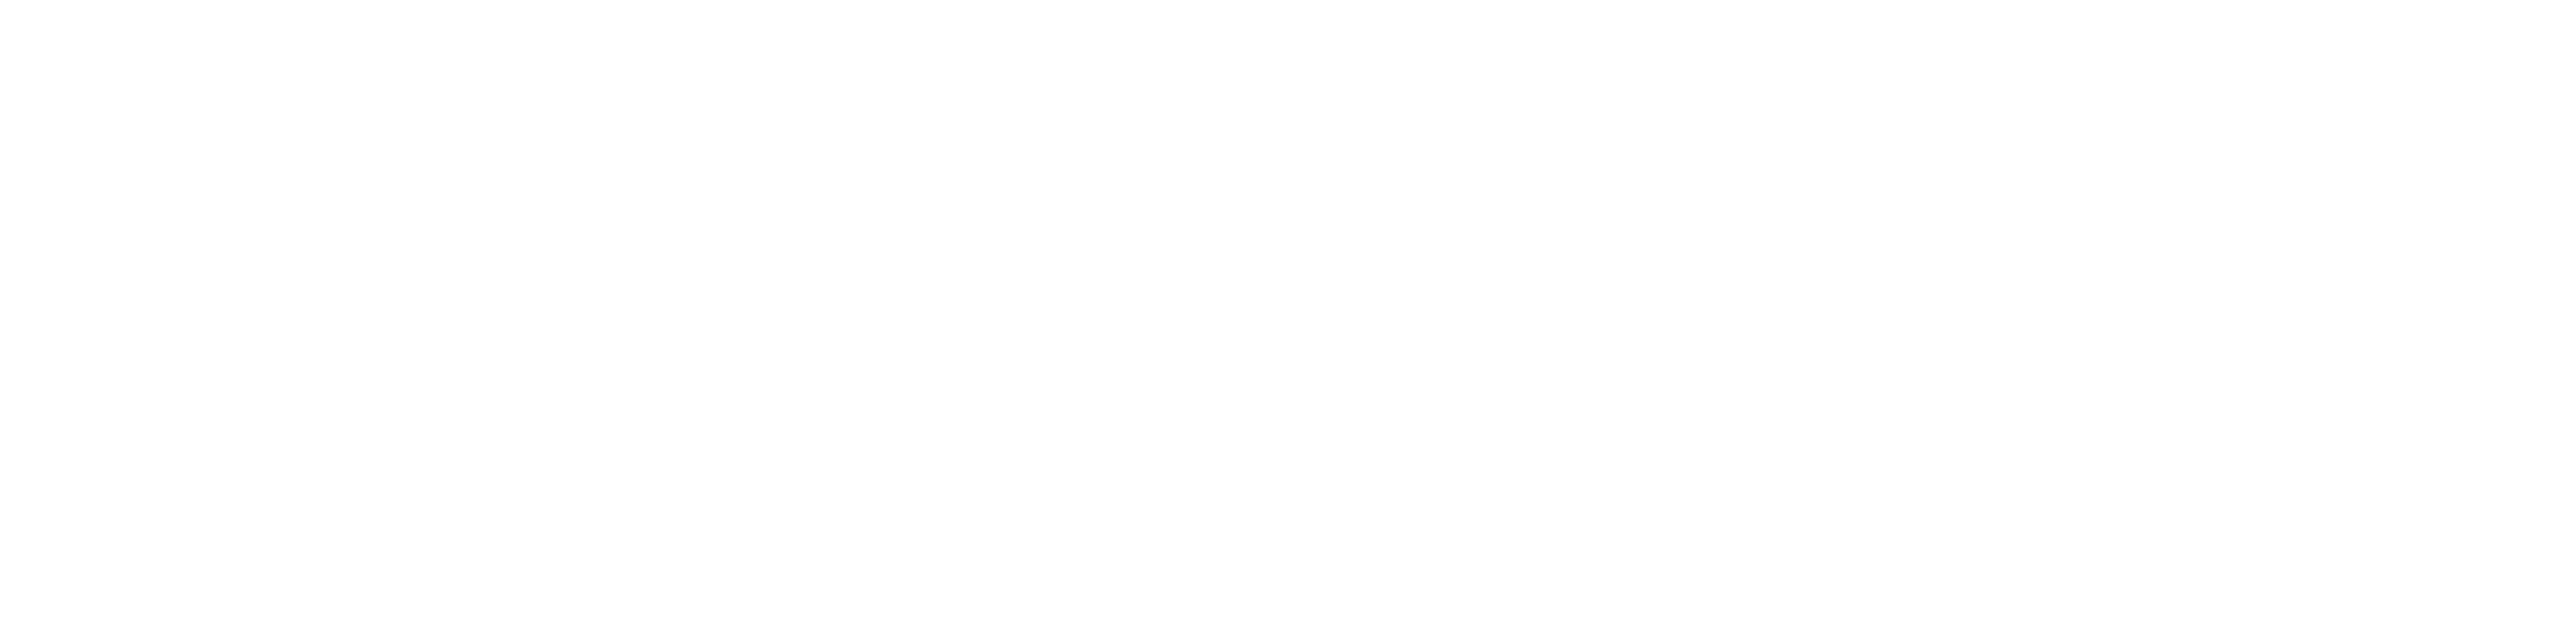

2020-06-07 18:39:03,385 logger INFO loss 3.44, MemUsed:50.05
2020-06-07 18:39:09,569 logger INFO loss 3.44, MemUsed:50.05
2020-06-07 18:39:15,649 logger INFO loss 3.43, MemUsed:50.05
2020-06-07 18:39:21,779 logger INFO loss 3.43, MemUsed:50.05
2020-06-07 18:39:27,878 logger INFO loss 3.43, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


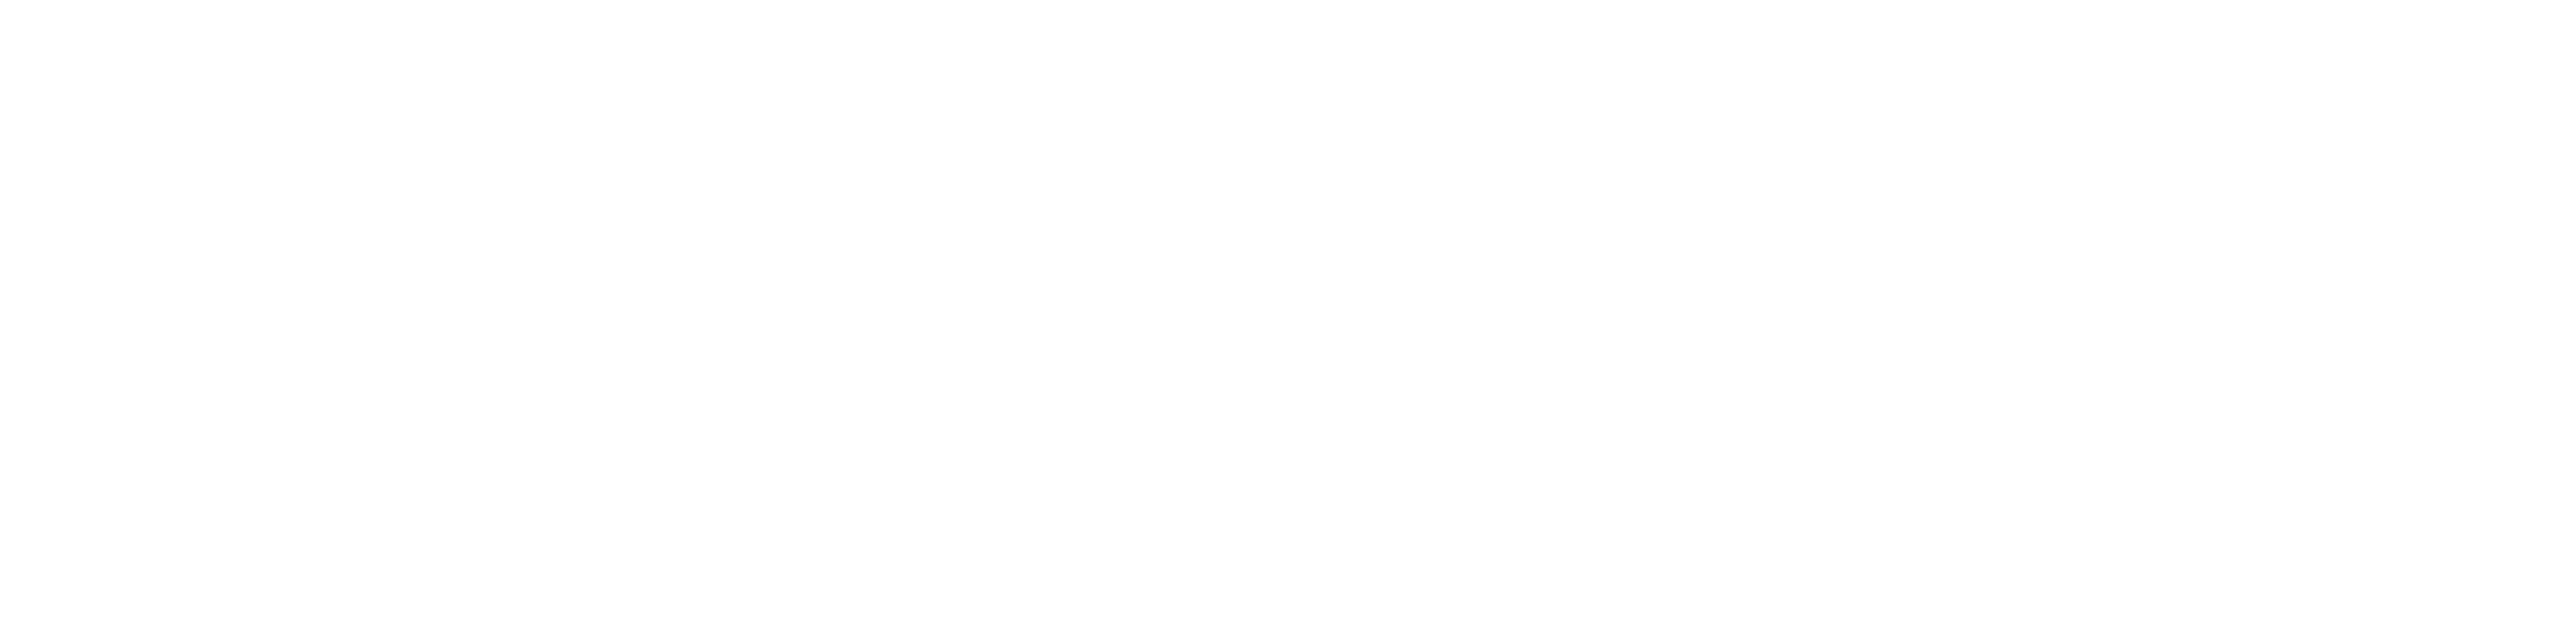

2020-06-07 18:39:51,782 logger INFO loss 3.43, MemUsed:50.05
2020-06-07 18:39:57,873 logger INFO loss 3.43, MemUsed:50.05
2020-06-07 18:40:04,023 logger INFO loss 3.42, MemUsed:50.05
2020-06-07 18:40:10,121 logger INFO loss 3.42, MemUsed:50.05
2020-06-07 18:40:16,248 logger INFO loss 3.42, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


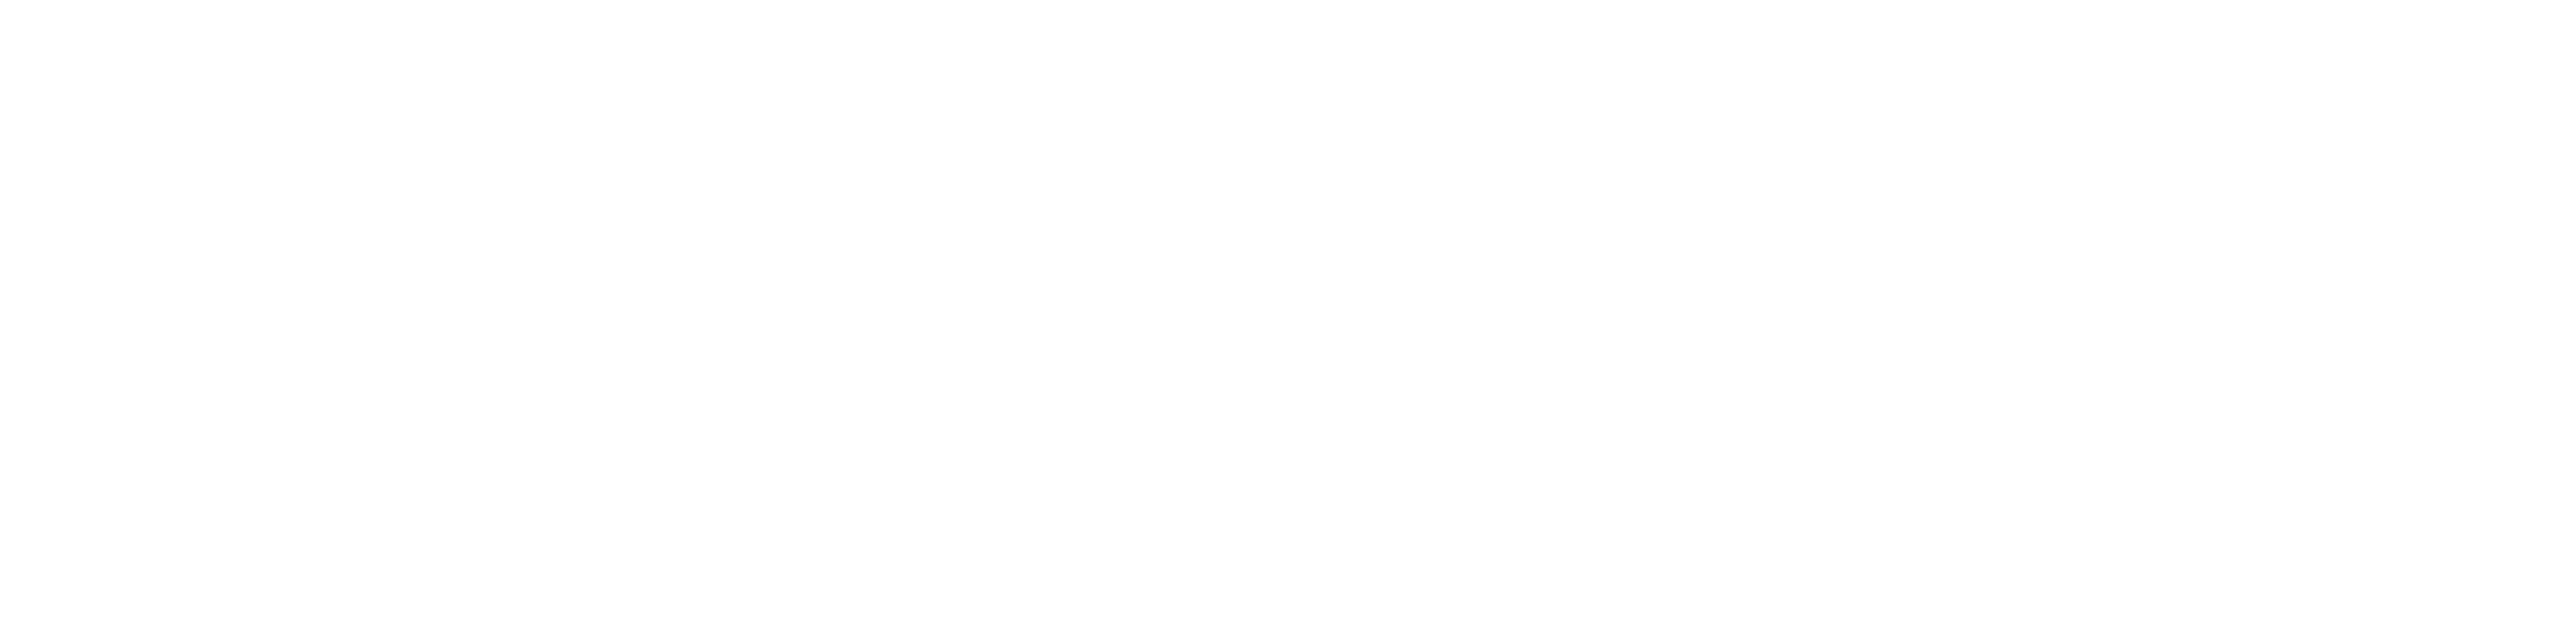

2020-06-07 18:40:40,159 logger INFO loss 3.42, MemUsed:50.05
2020-06-07 18:40:46,237 logger INFO loss 3.41, MemUsed:50.05
2020-06-07 18:40:52,392 logger INFO loss 3.41, MemUsed:50.05
2020-06-07 18:40:58,498 logger INFO loss 3.41, MemUsed:50.05
2020-06-07 18:41:04,598 logger INFO loss 3.41, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


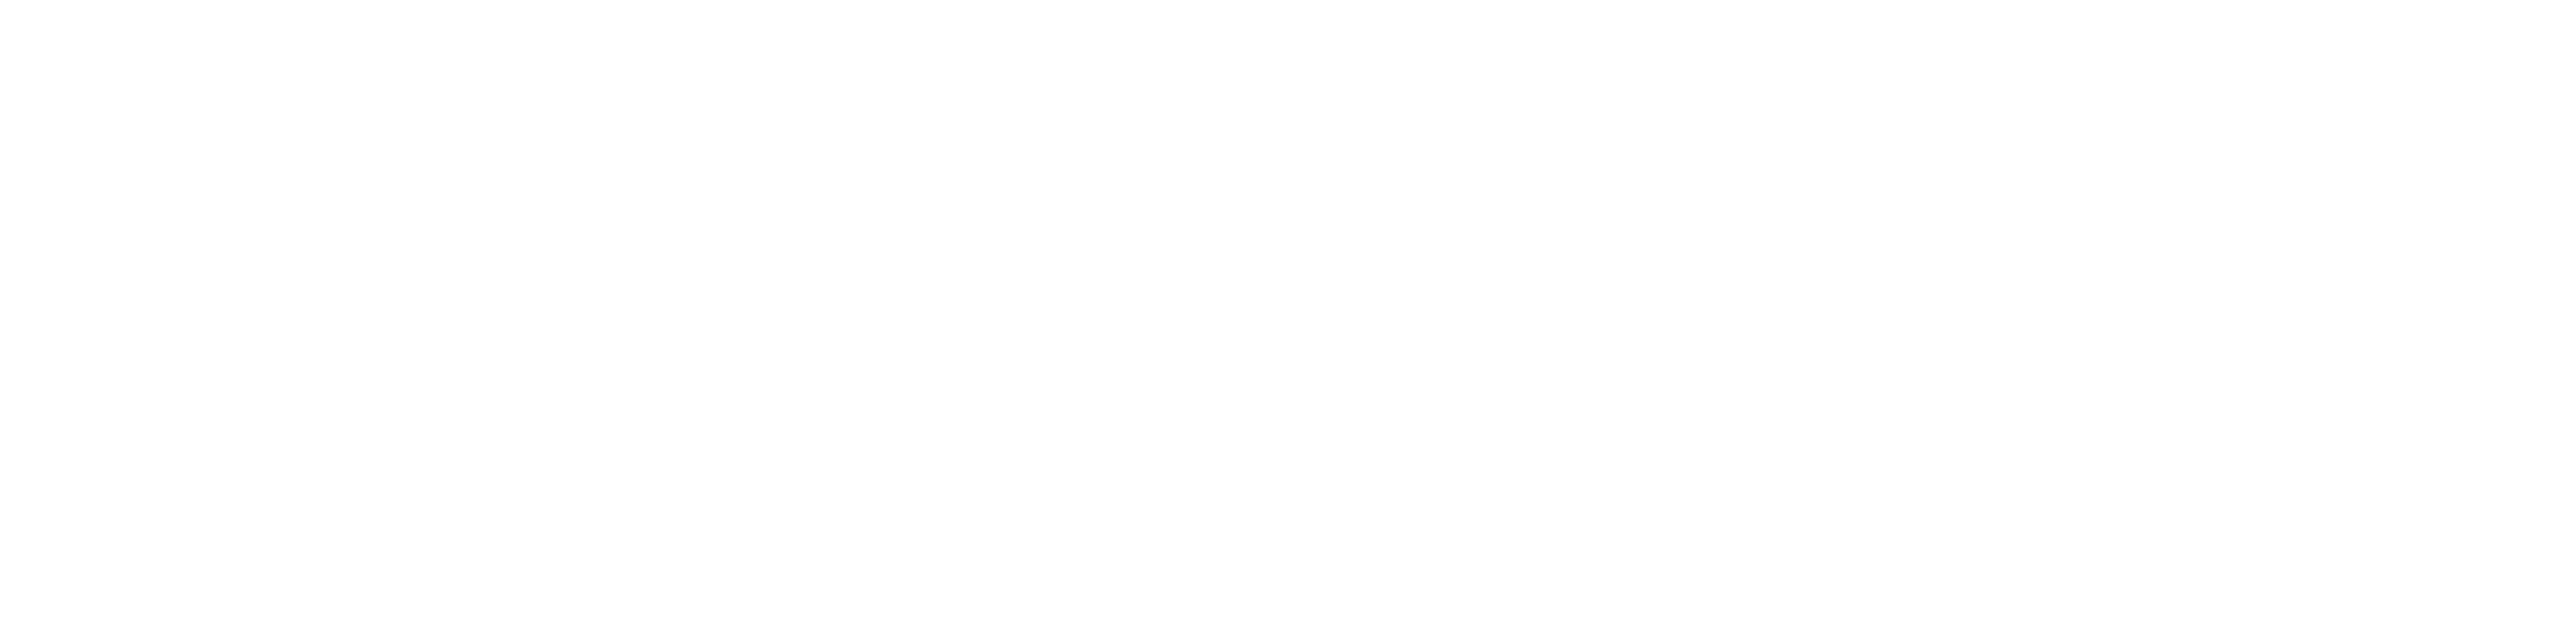

2020-06-07 18:41:28,501 logger INFO loss 3.41, MemUsed:50.05
2020-06-07 18:41:34,630 logger INFO loss 3.41, MemUsed:50.05
2020-06-07 18:41:40,724 logger INFO loss 3.40, MemUsed:50.05
2020-06-07 18:41:46,865 logger INFO loss 3.40, MemUsed:50.05
2020-06-07 18:41:52,971 logger INFO loss 3.40, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


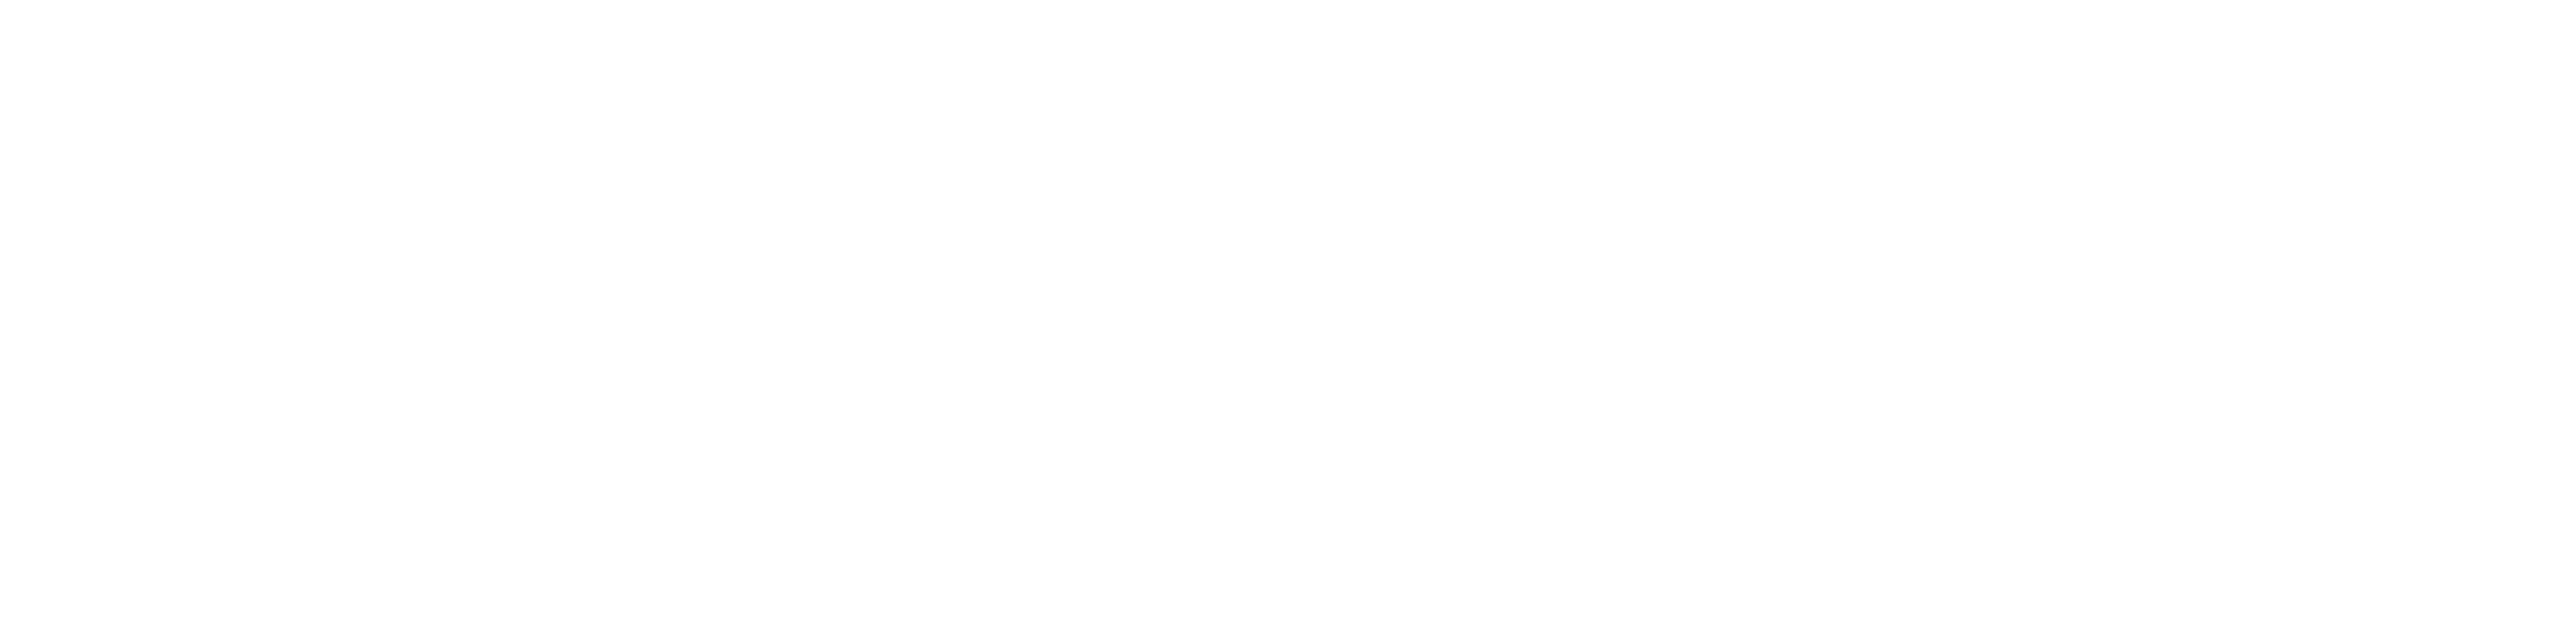

2020-06-07 18:42:16,883 logger INFO loss 3.40, MemUsed:50.05
2020-06-07 18:42:22,981 logger INFO loss 3.40, MemUsed:50.05
2020-06-07 18:42:29,154 logger INFO loss 3.40, MemUsed:50.05
2020-06-07 18:42:35,249 logger INFO loss 3.39, MemUsed:50.05
2020-06-07 18:42:41,381 logger INFO loss 3.39, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


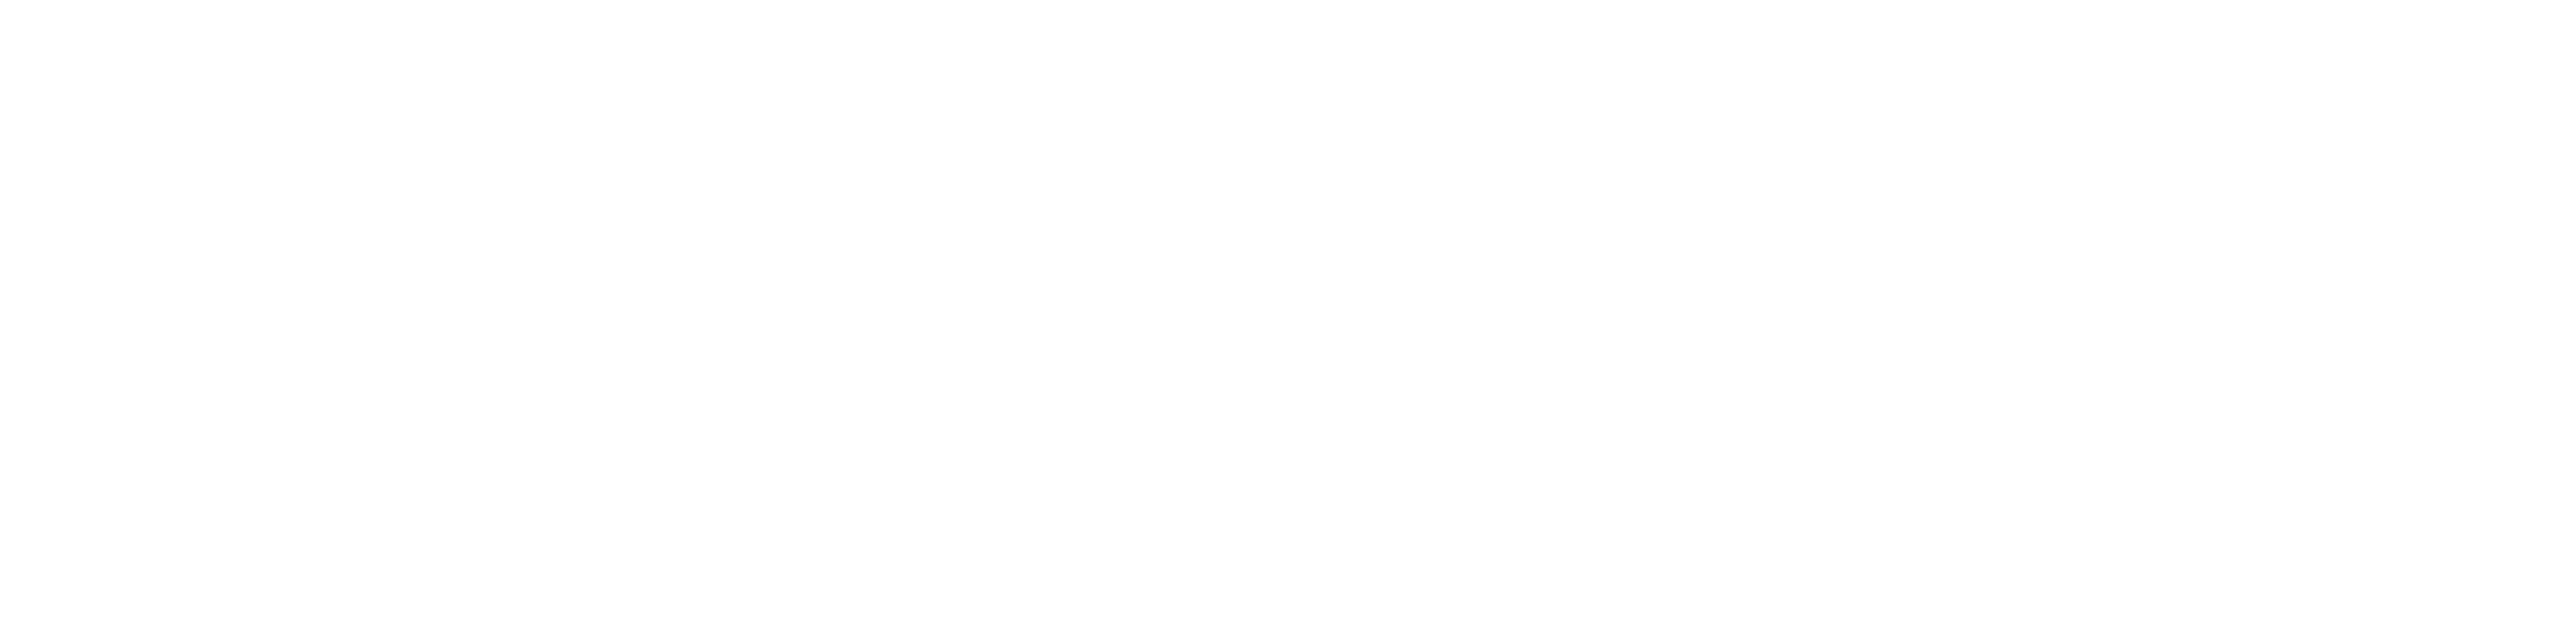

2020-06-07 18:43:05,181 logger INFO loss 3.39, MemUsed:50.05
2020-06-07 18:43:11,347 logger INFO loss 3.39, MemUsed:50.05
2020-06-07 18:43:17,441 logger INFO loss 3.39, MemUsed:50.05
2020-06-07 18:43:23,552 logger INFO loss 3.39, MemUsed:50.05
2020-06-07 18:43:29,646 logger INFO loss 3.39, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


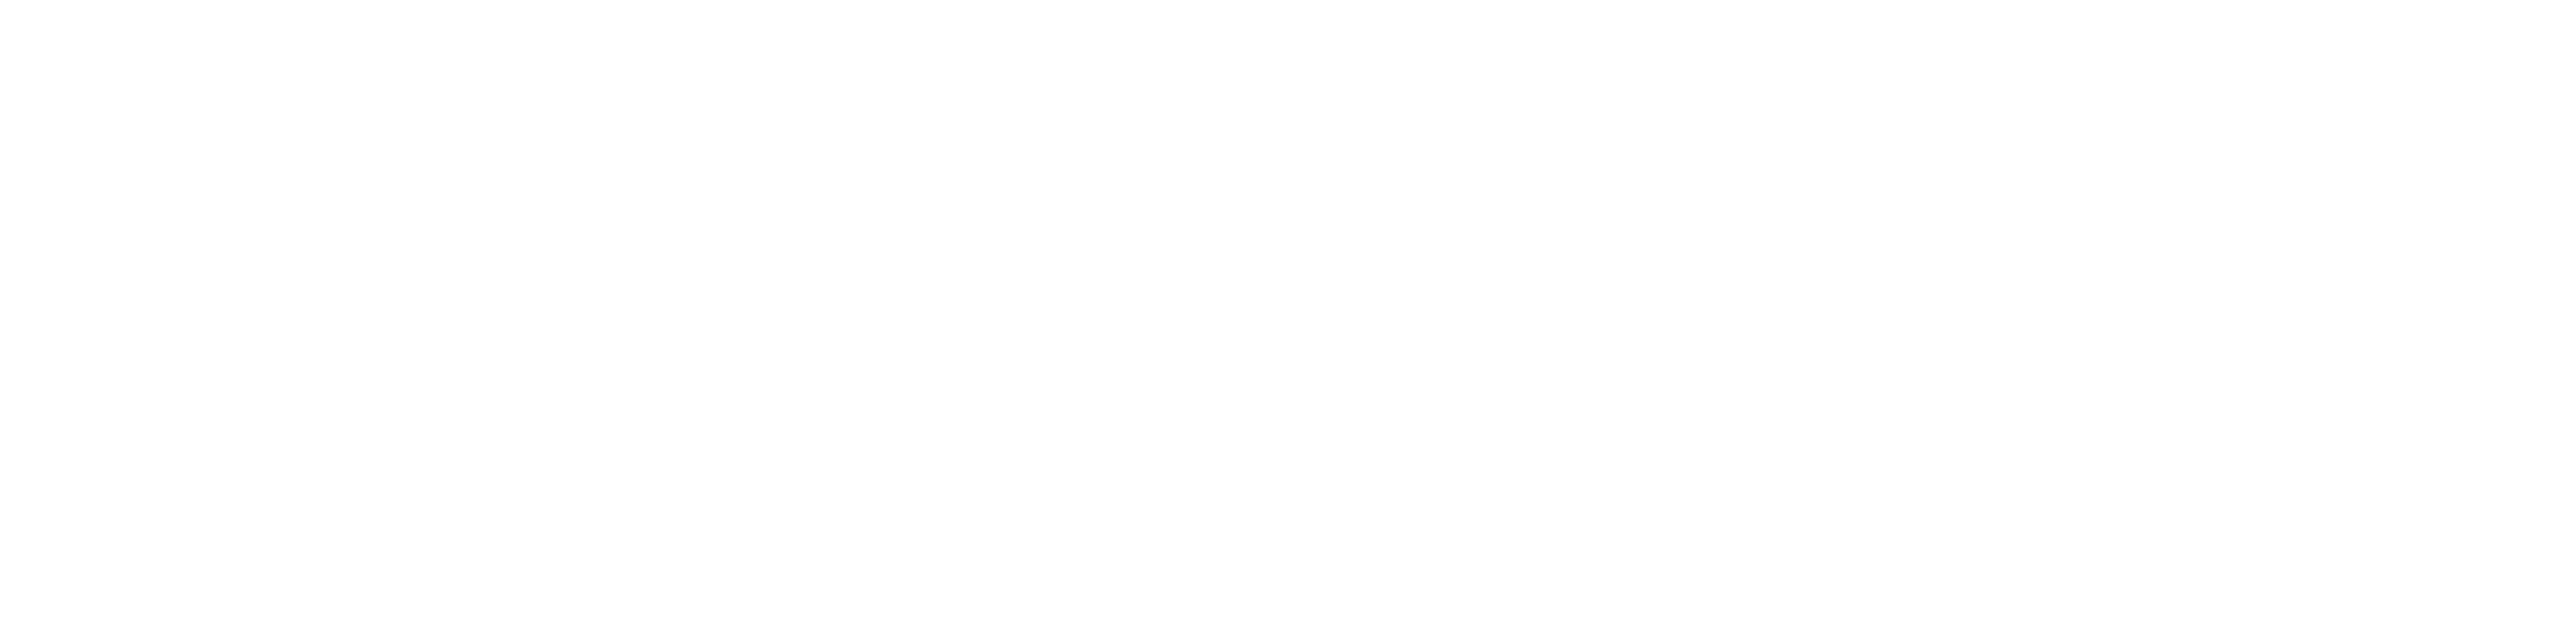

2020-06-07 18:43:53,522 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:43:59,601 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:44:05,729 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:44:11,831 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:44:17,957 logger INFO loss 3.38, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


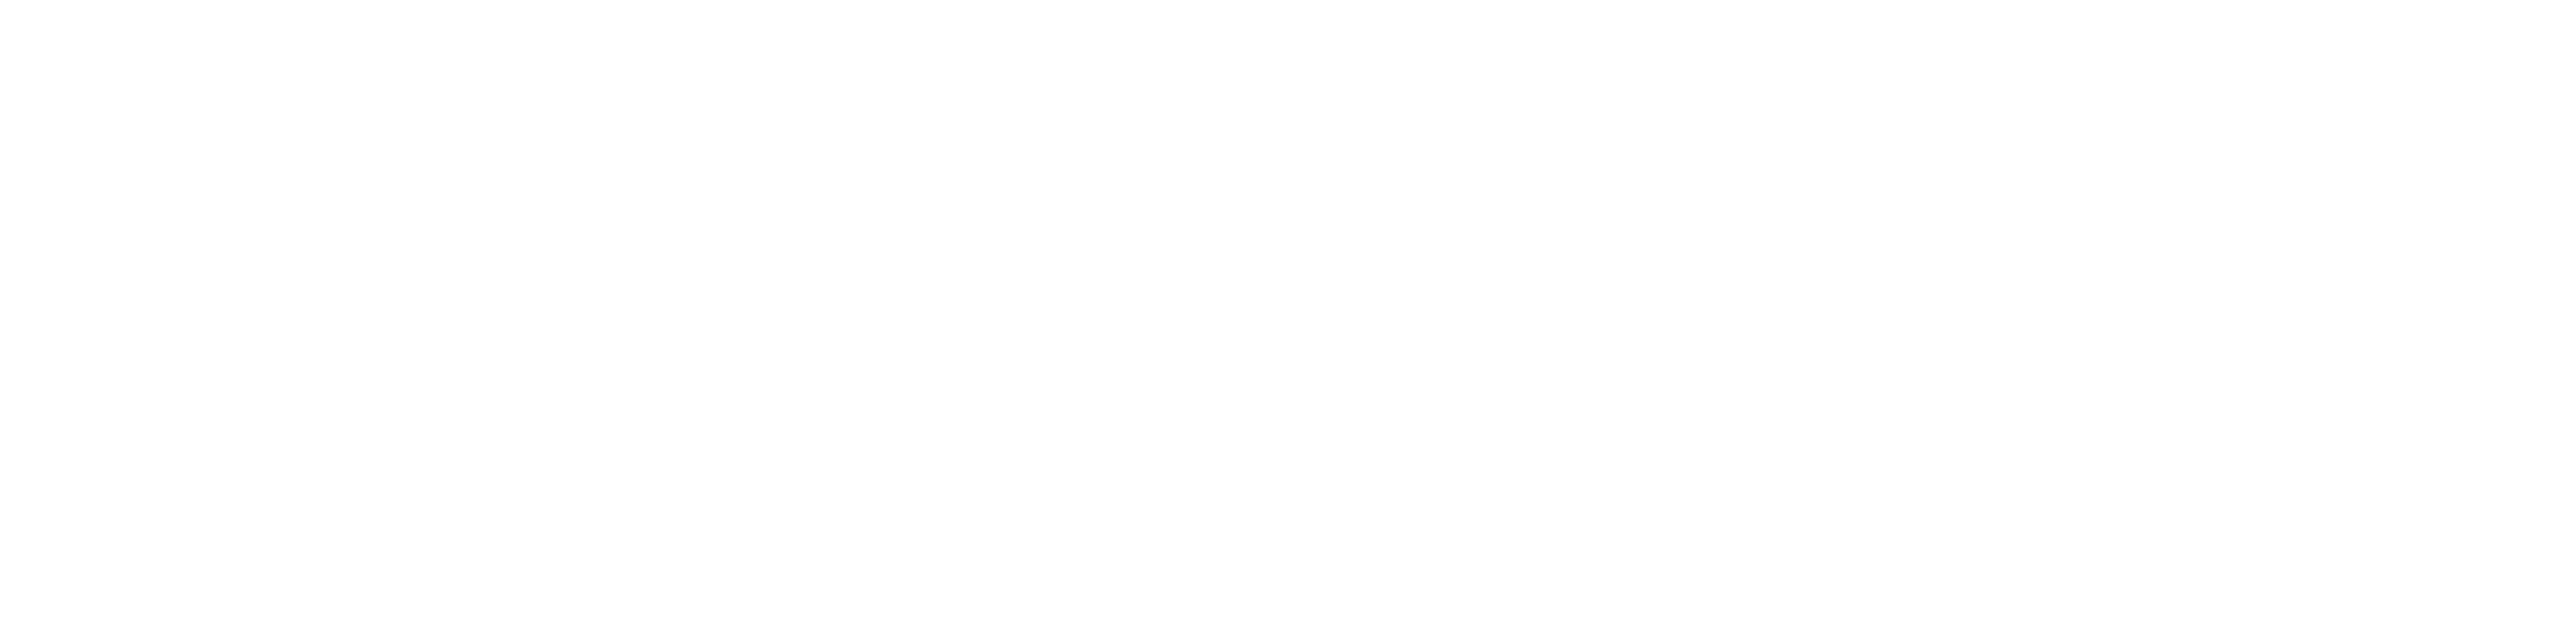

2020-06-07 18:44:41,744 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:44:47,909 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:44:53,993 logger INFO loss 3.38, MemUsed:50.05
2020-06-07 18:45:00,131 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:45:06,237 logger INFO loss 3.37, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


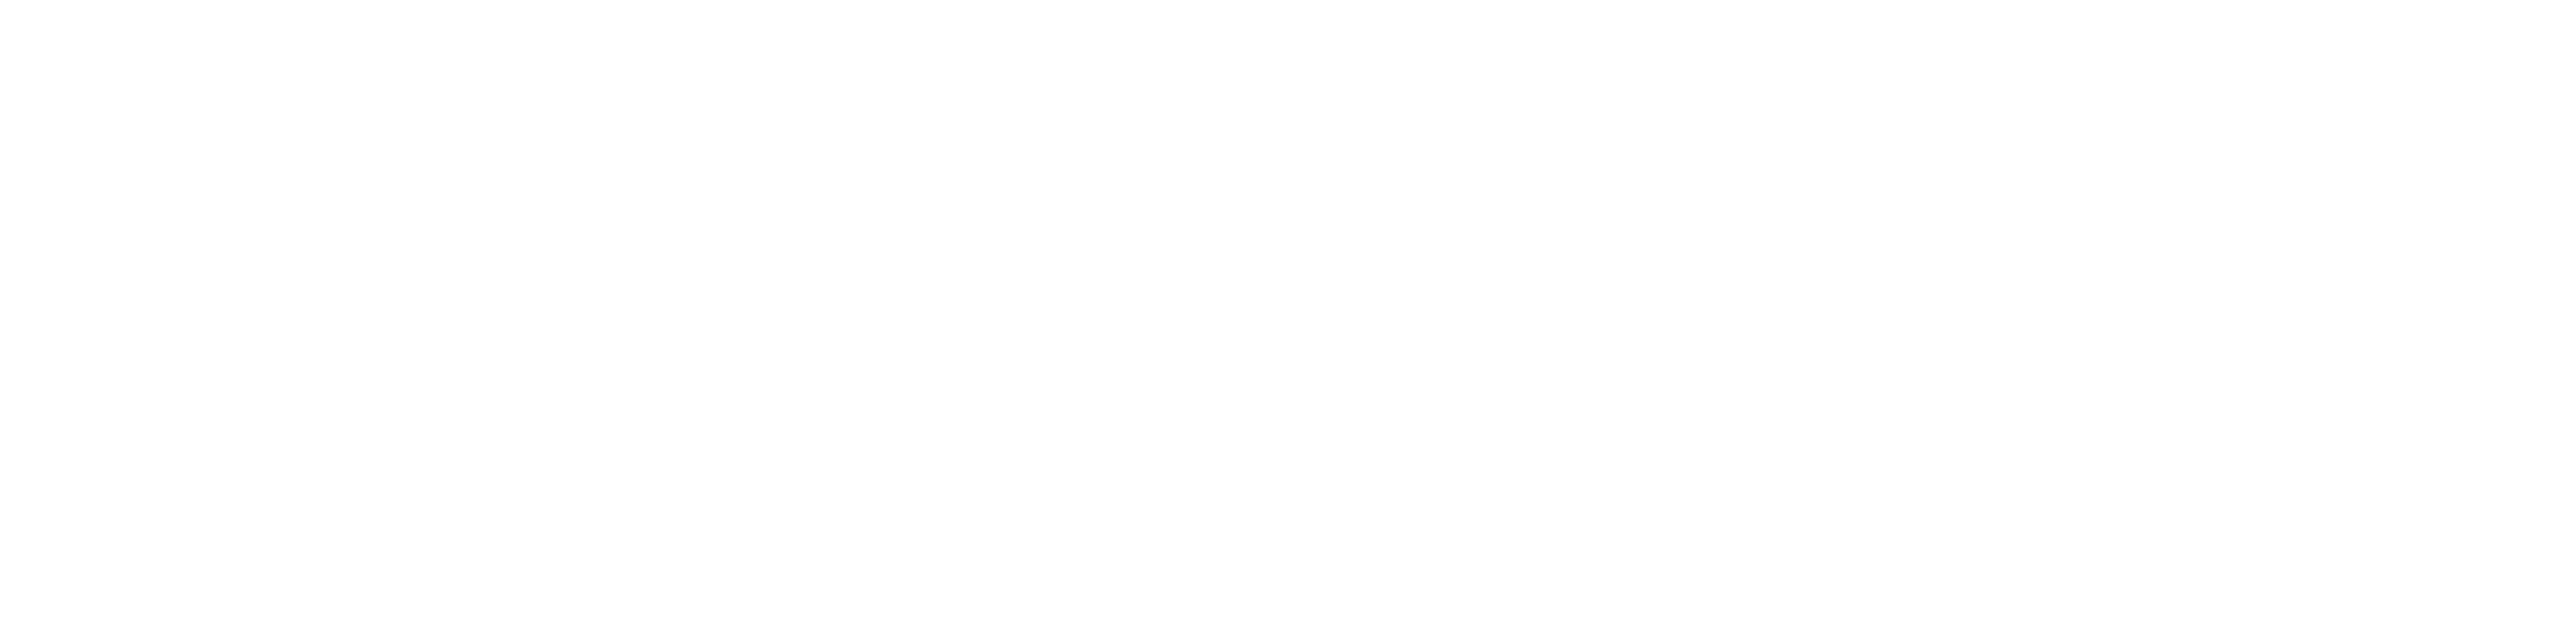

2020-06-07 18:45:30,120 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:45:36,202 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:45:42,344 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:45:48,451 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:45:54,593 logger INFO loss 3.37, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


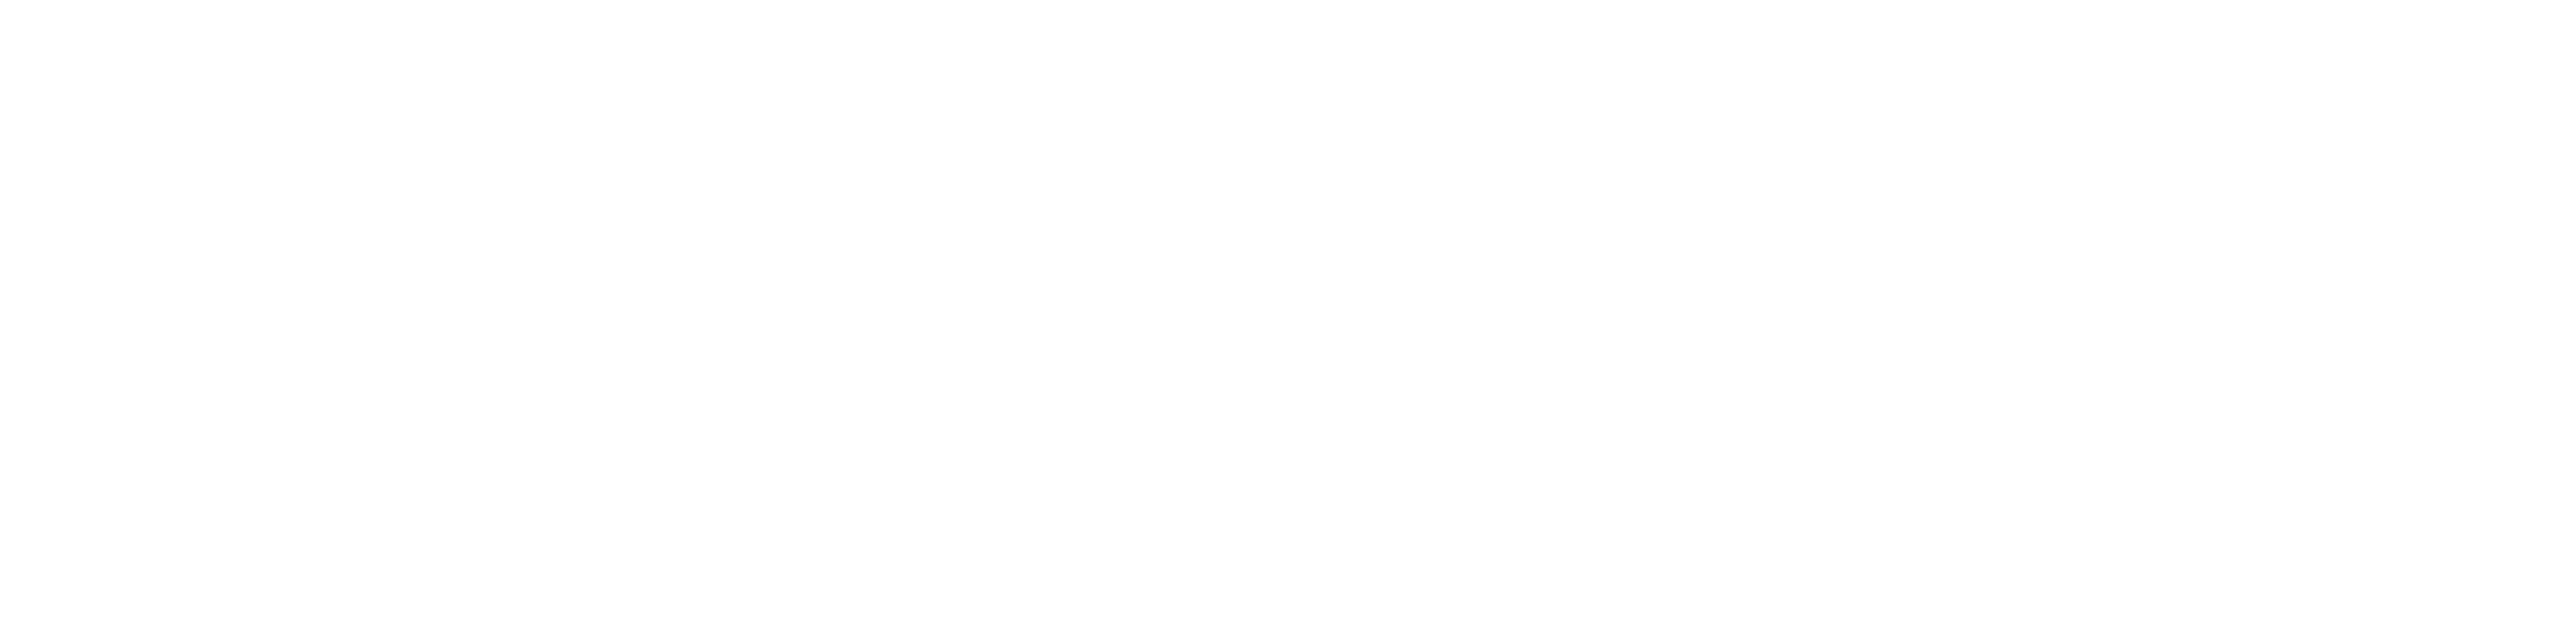

2020-06-07 18:46:18,443 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:46:24,534 logger INFO loss 3.37, MemUsed:50.05
2020-06-07 18:46:30,667 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:46:36,751 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:46:42,842 logger INFO loss 3.36, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


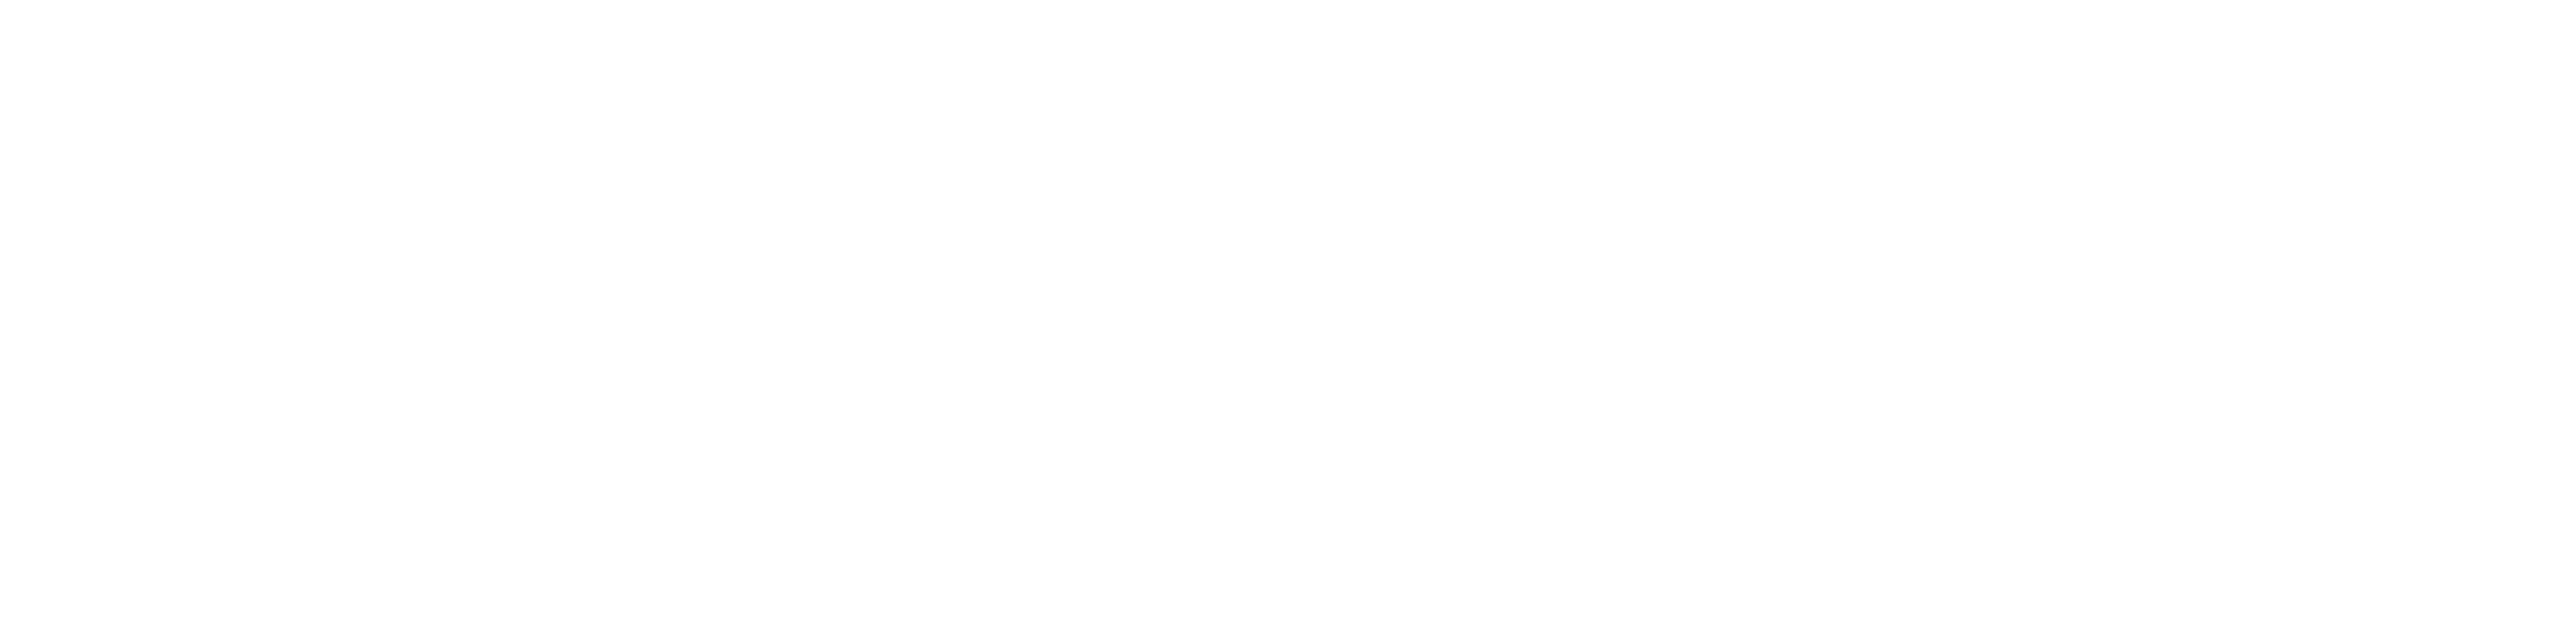

2020-06-07 18:47:06,673 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:47:12,806 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:47:18,891 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:47:25,023 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:47:31,147 logger INFO loss 3.36, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


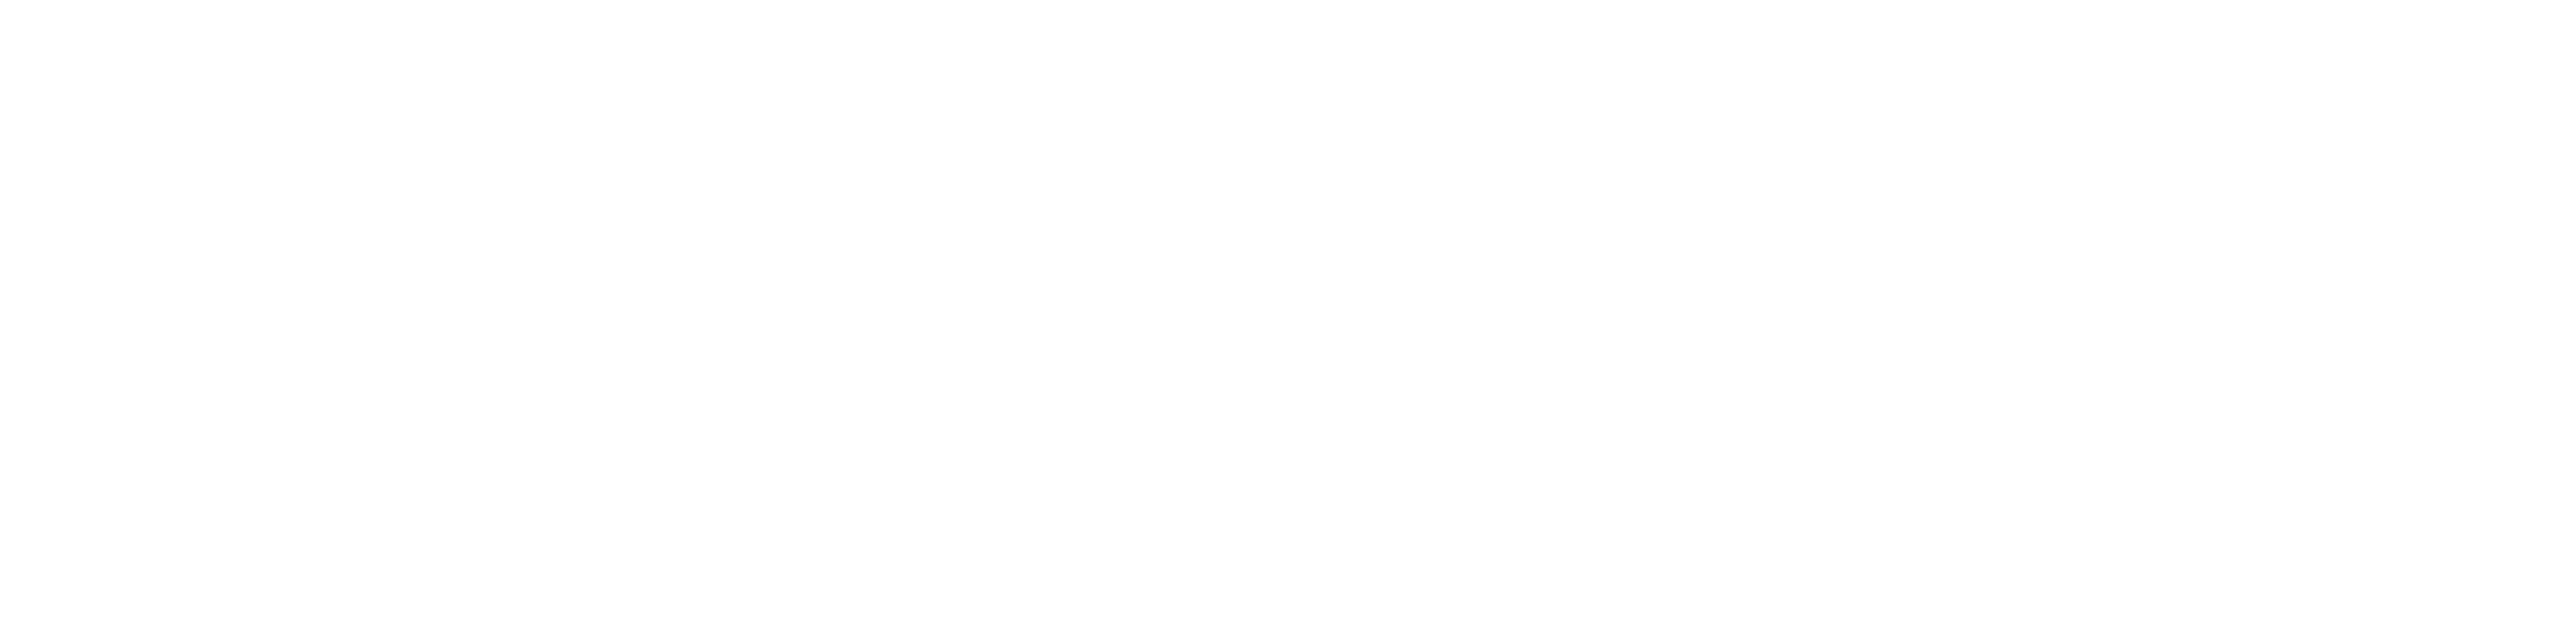

2020-06-07 18:47:55,090 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:48:01,177 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:48:07,314 logger INFO loss 3.36, MemUsed:50.05
2020-06-07 18:48:13,423 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:48:19,558 logger INFO loss 3.35, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


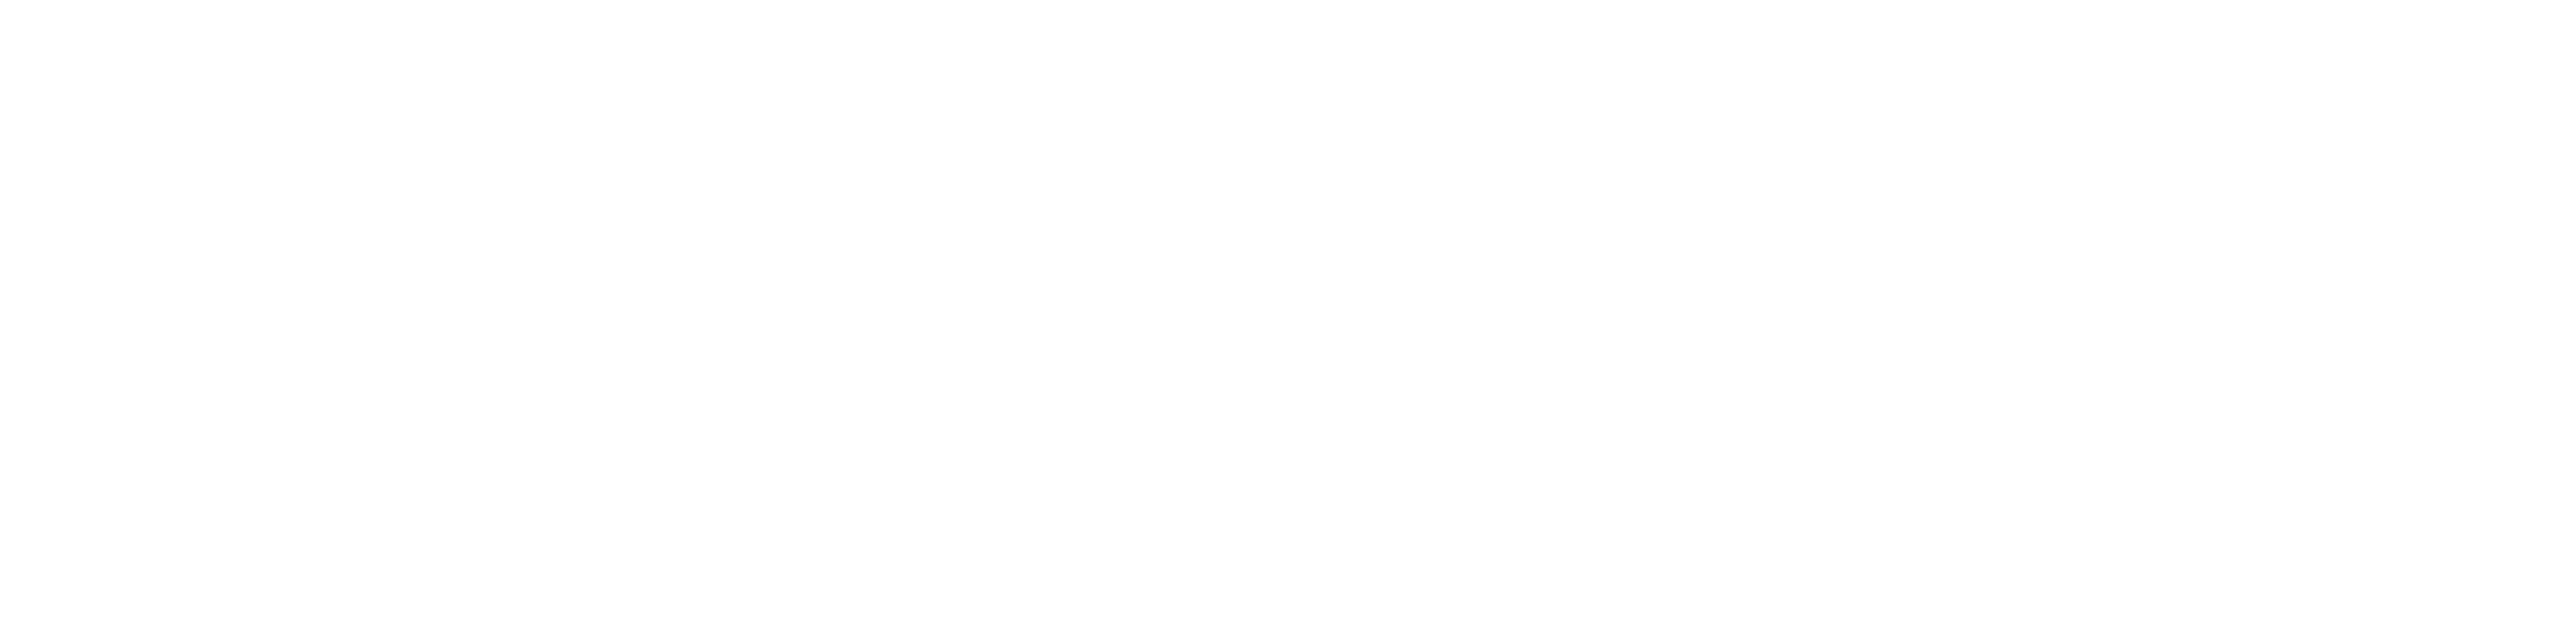

2020-06-07 18:48:43,316 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:48:49,472 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:48:55,555 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:01,694 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:07,795 logger INFO loss 3.35, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


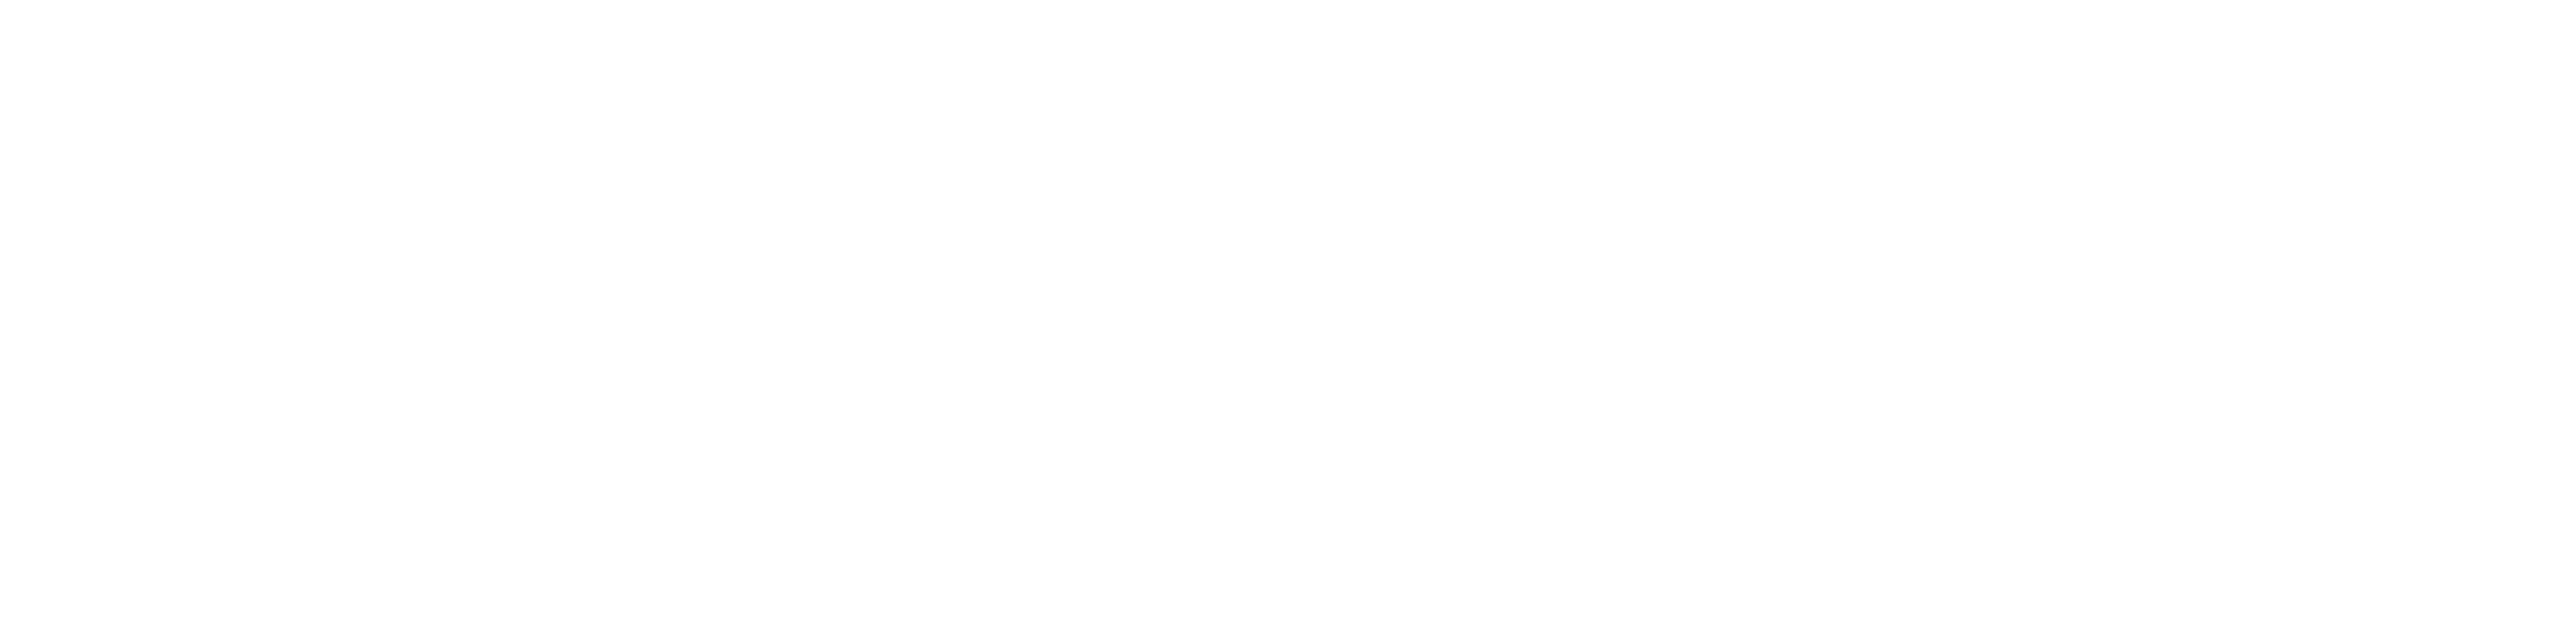

2020-06-07 18:49:31,645 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:37,710 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:43,845 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:49,931 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:49:56,069 logger INFO loss 3.35, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


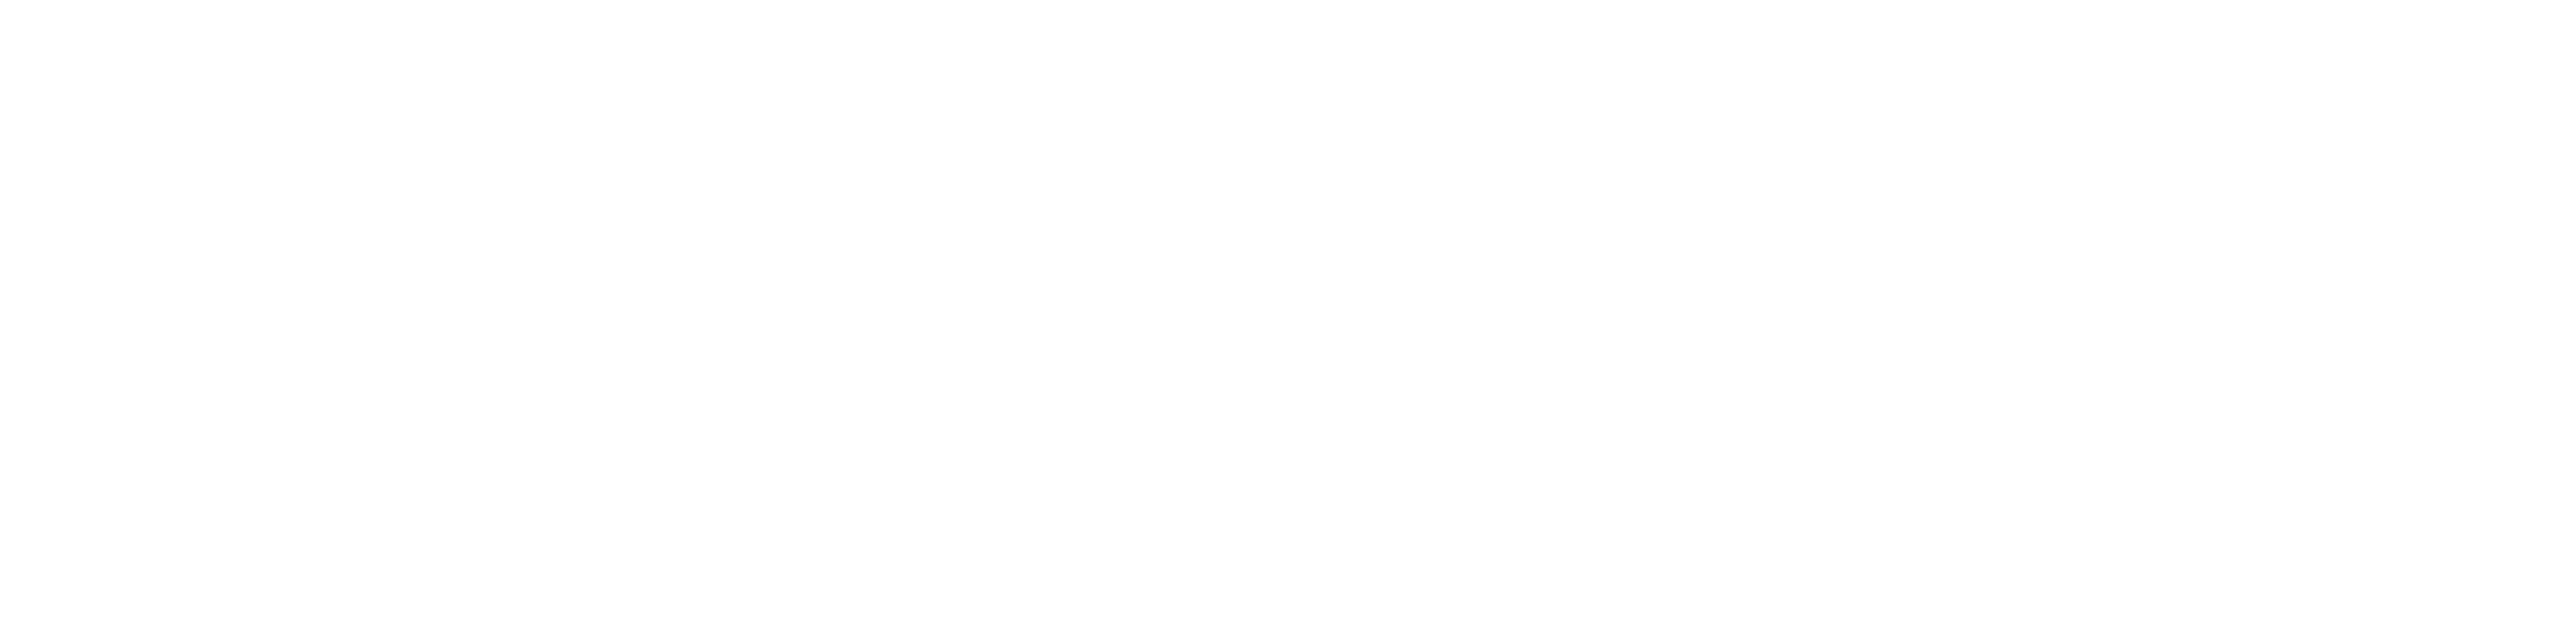

2020-06-07 18:50:19,856 logger INFO loss 3.35, MemUsed:50.05
2020-06-07 18:50:26,043 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:50:32,146 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:50:38,285 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:50:44,402 logger INFO loss 3.34, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


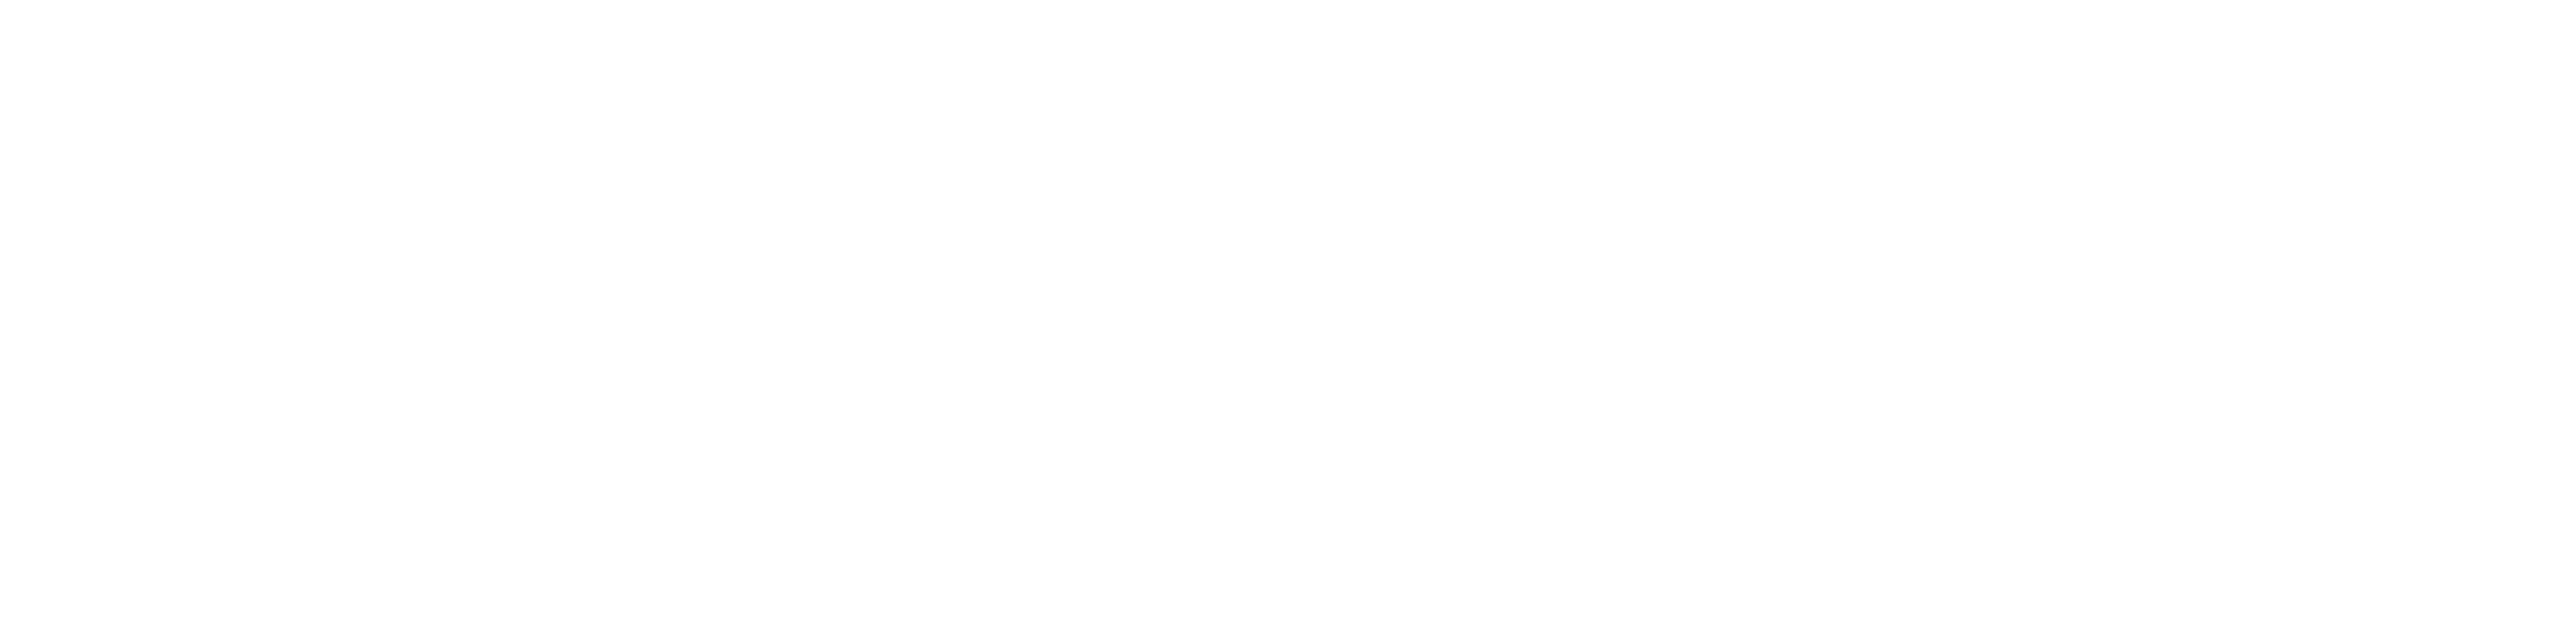

2020-06-07 18:51:08,245 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:51:14,337 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:51:20,462 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:51:26,562 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:51:32,684 logger INFO loss 3.34, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


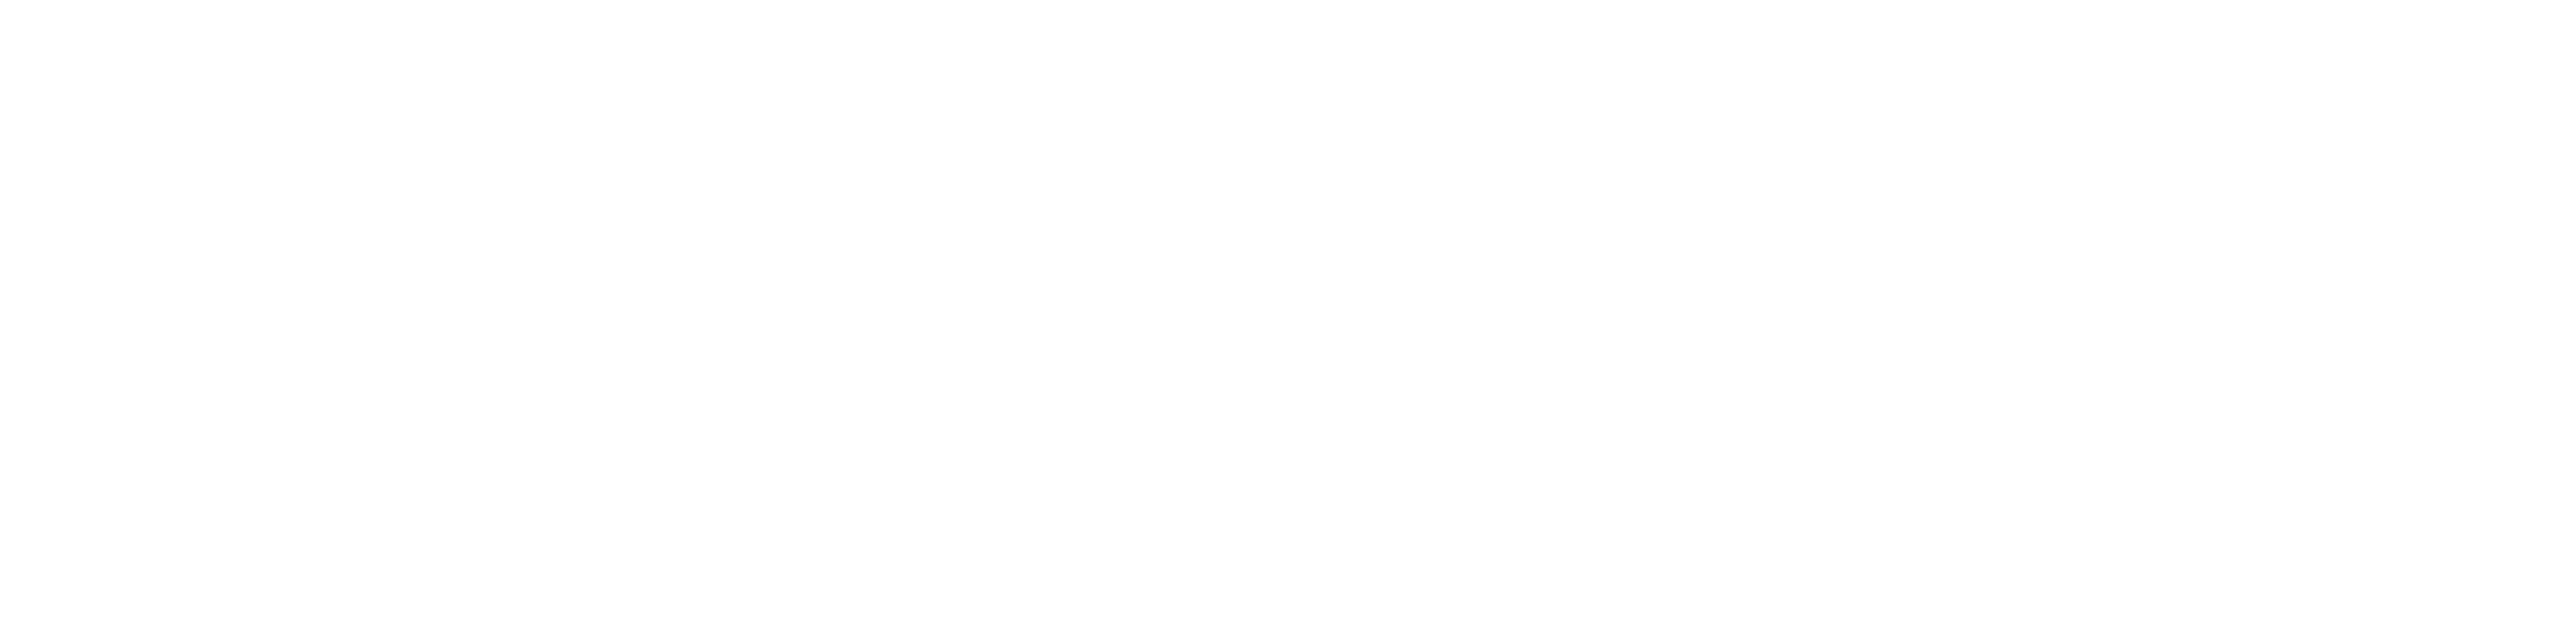

2020-06-07 18:51:56,577 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:02,697 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:08,846 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:14,944 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:21,046 logger INFO loss 3.34, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


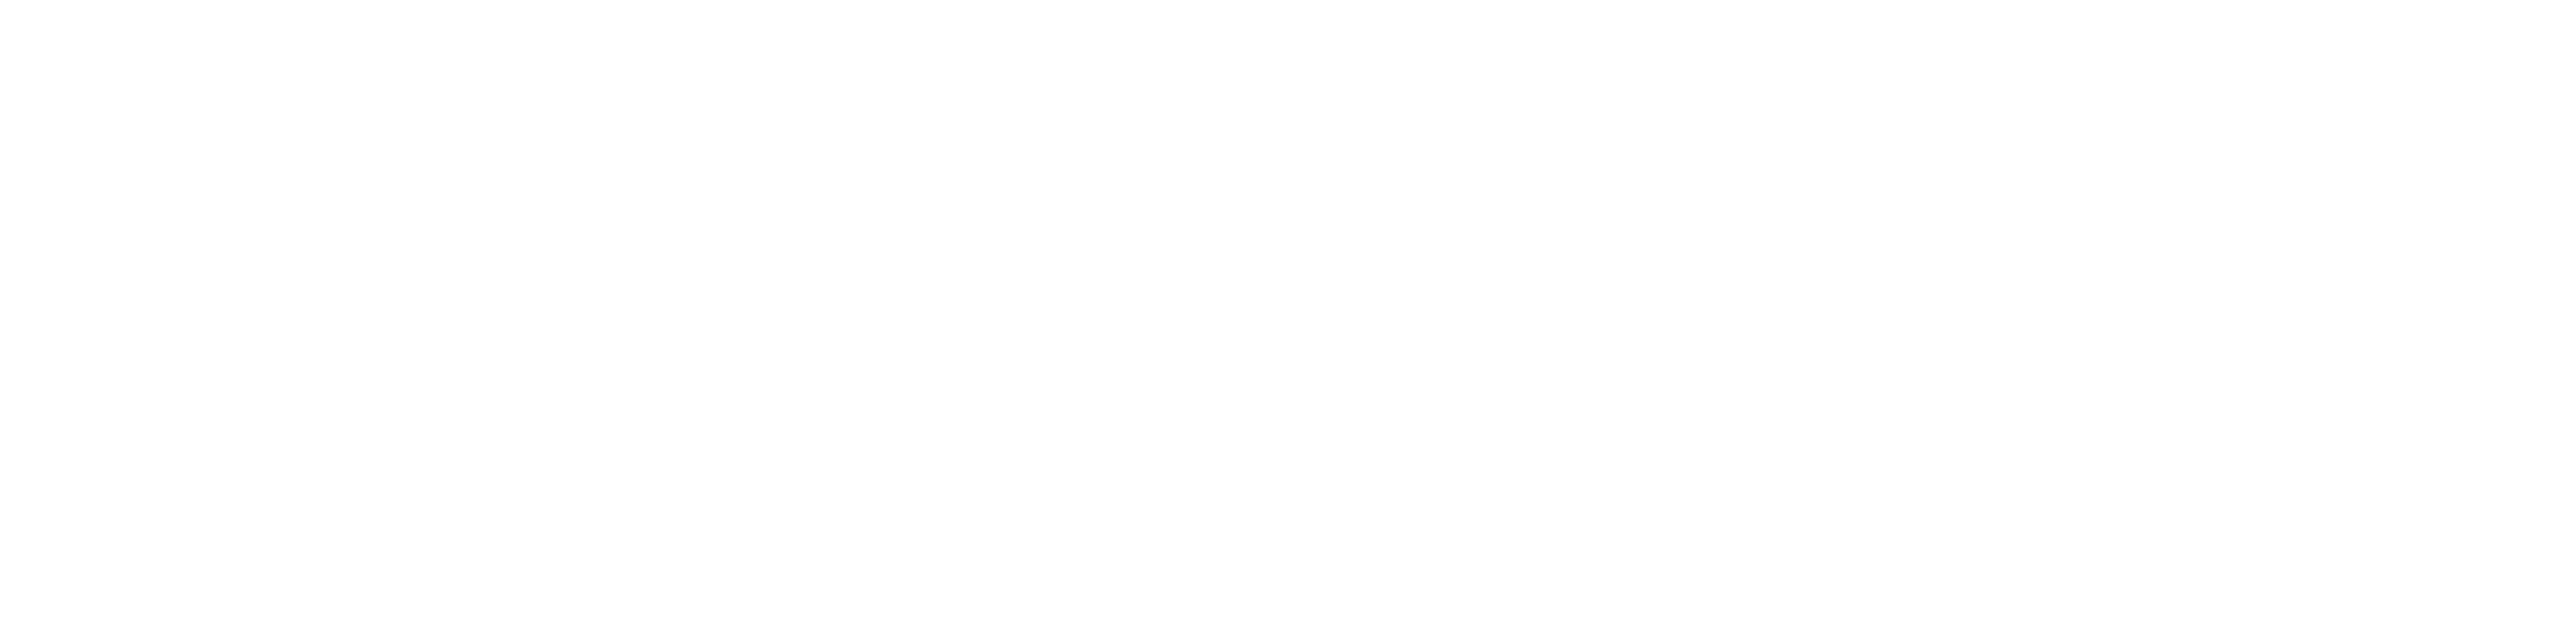

2020-06-07 18:52:44,921 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:51,056 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:52:57,140 logger INFO loss 3.34, MemUsed:50.05
2020-06-07 18:53:03,289 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:53:09,404 logger INFO loss 3.33, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


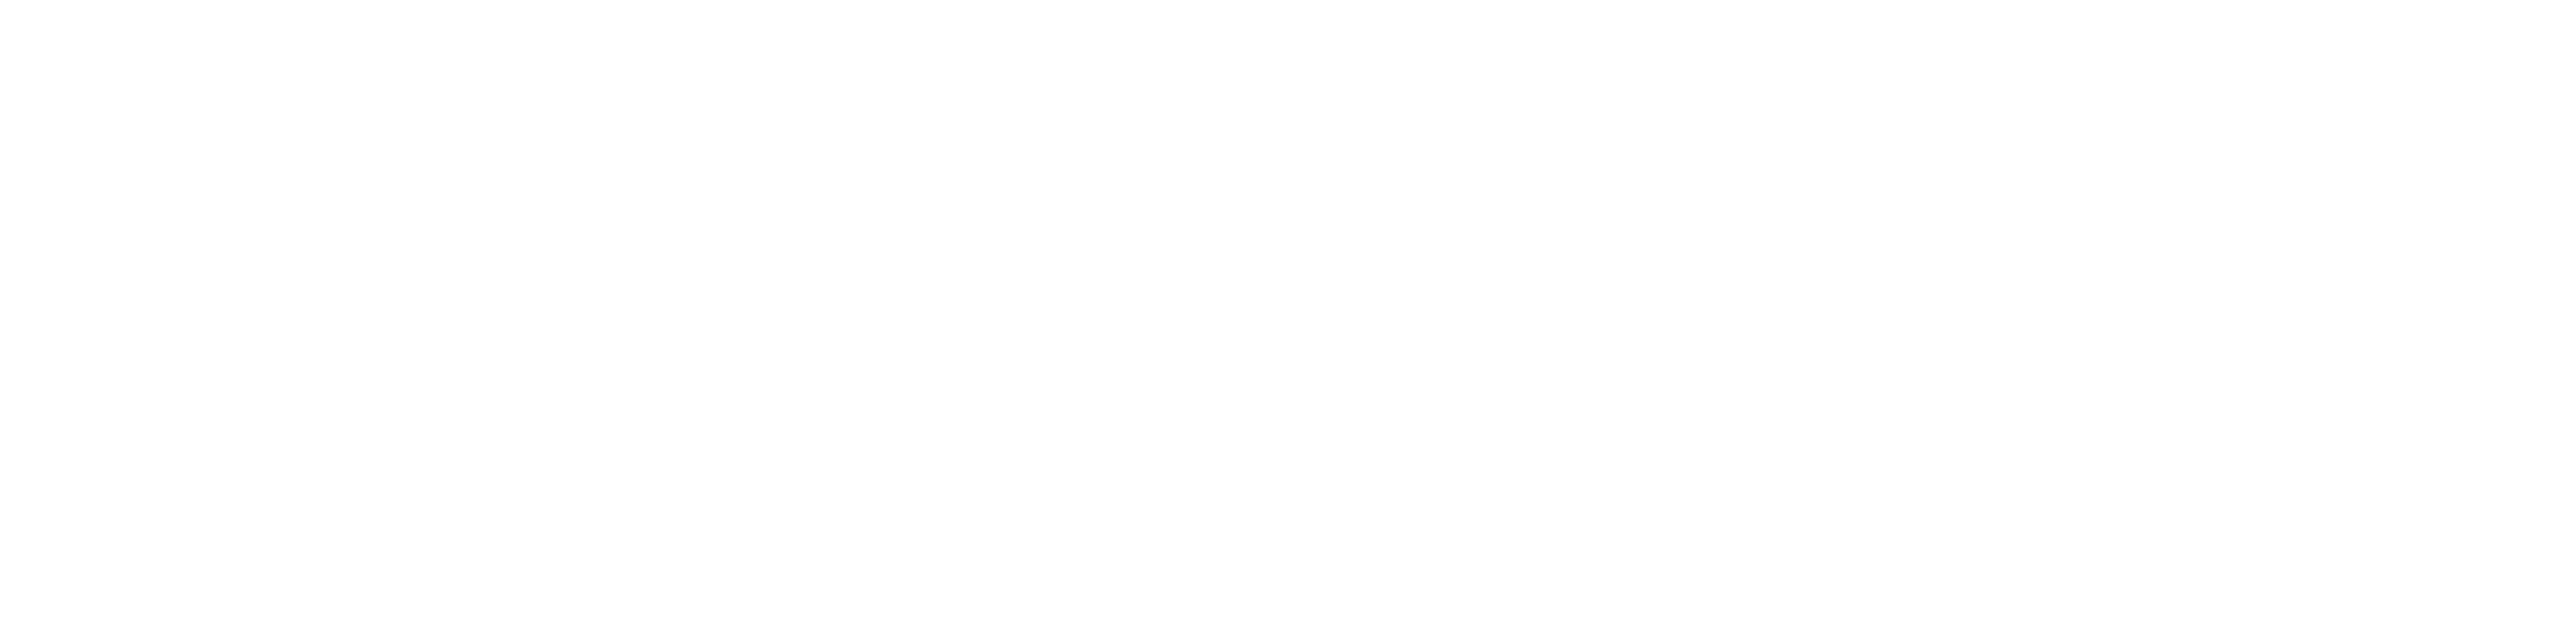

2020-06-07 18:53:33,313 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:53:39,401 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:53:45,543 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:53:51,639 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:53:57,779 logger INFO loss 3.33, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


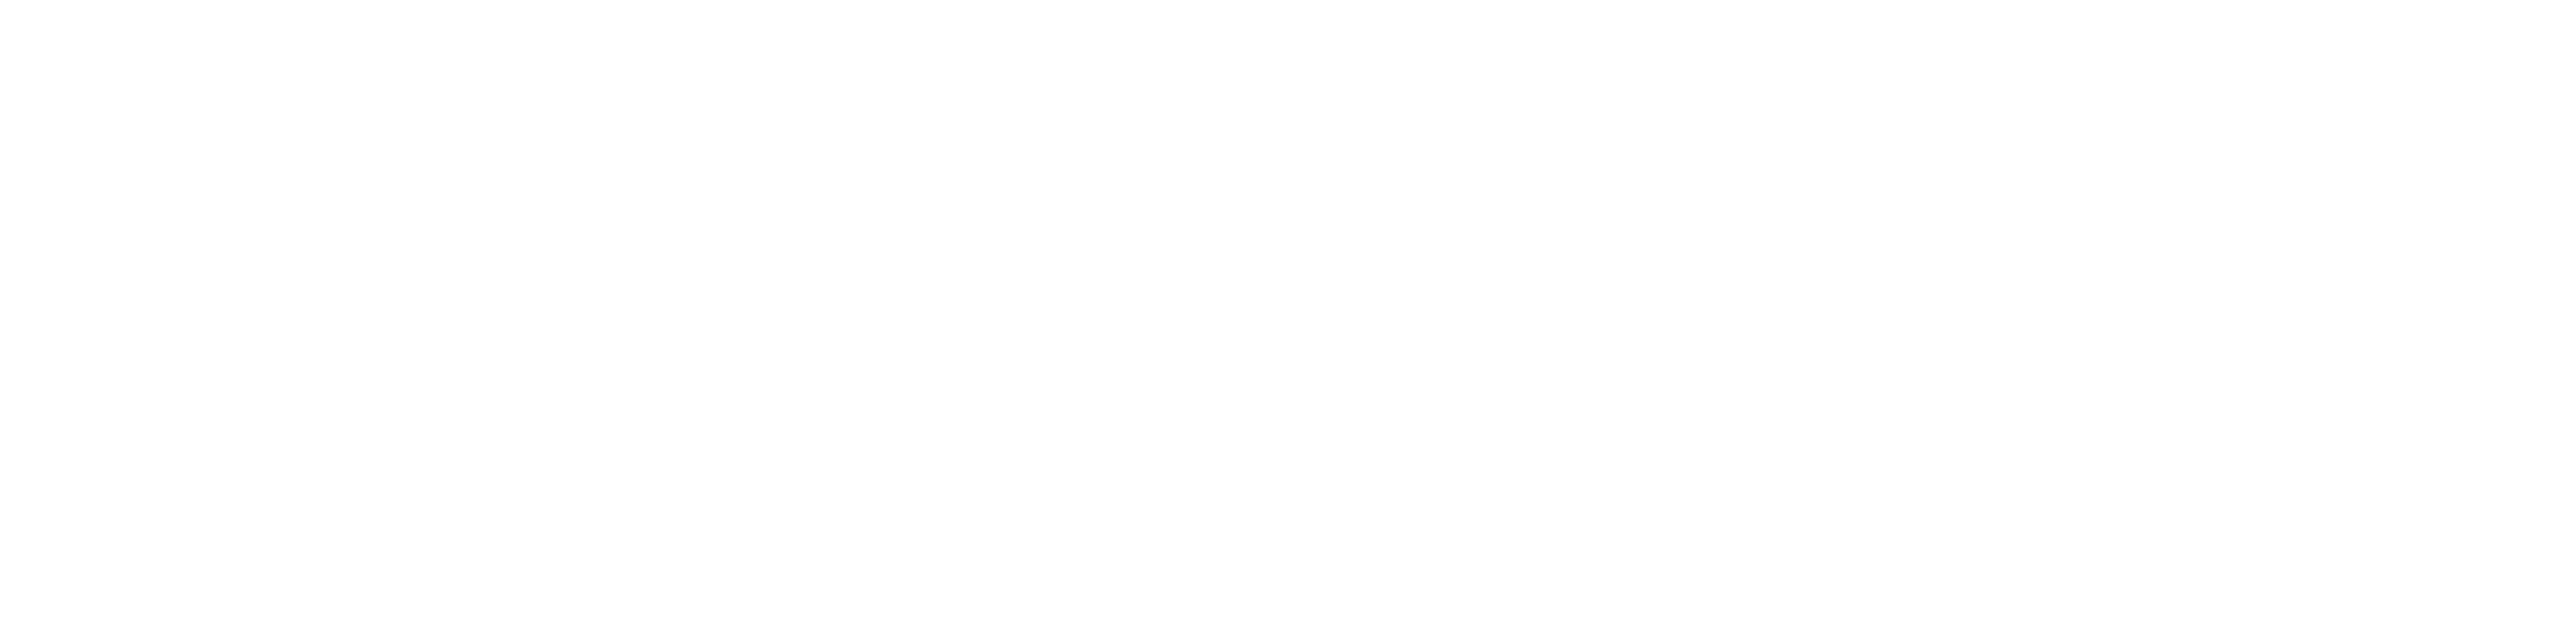

2020-06-07 18:54:21,615 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:54:27,810 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:54:33,925 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:54:40,057 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:54:46,170 logger INFO loss 3.33, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


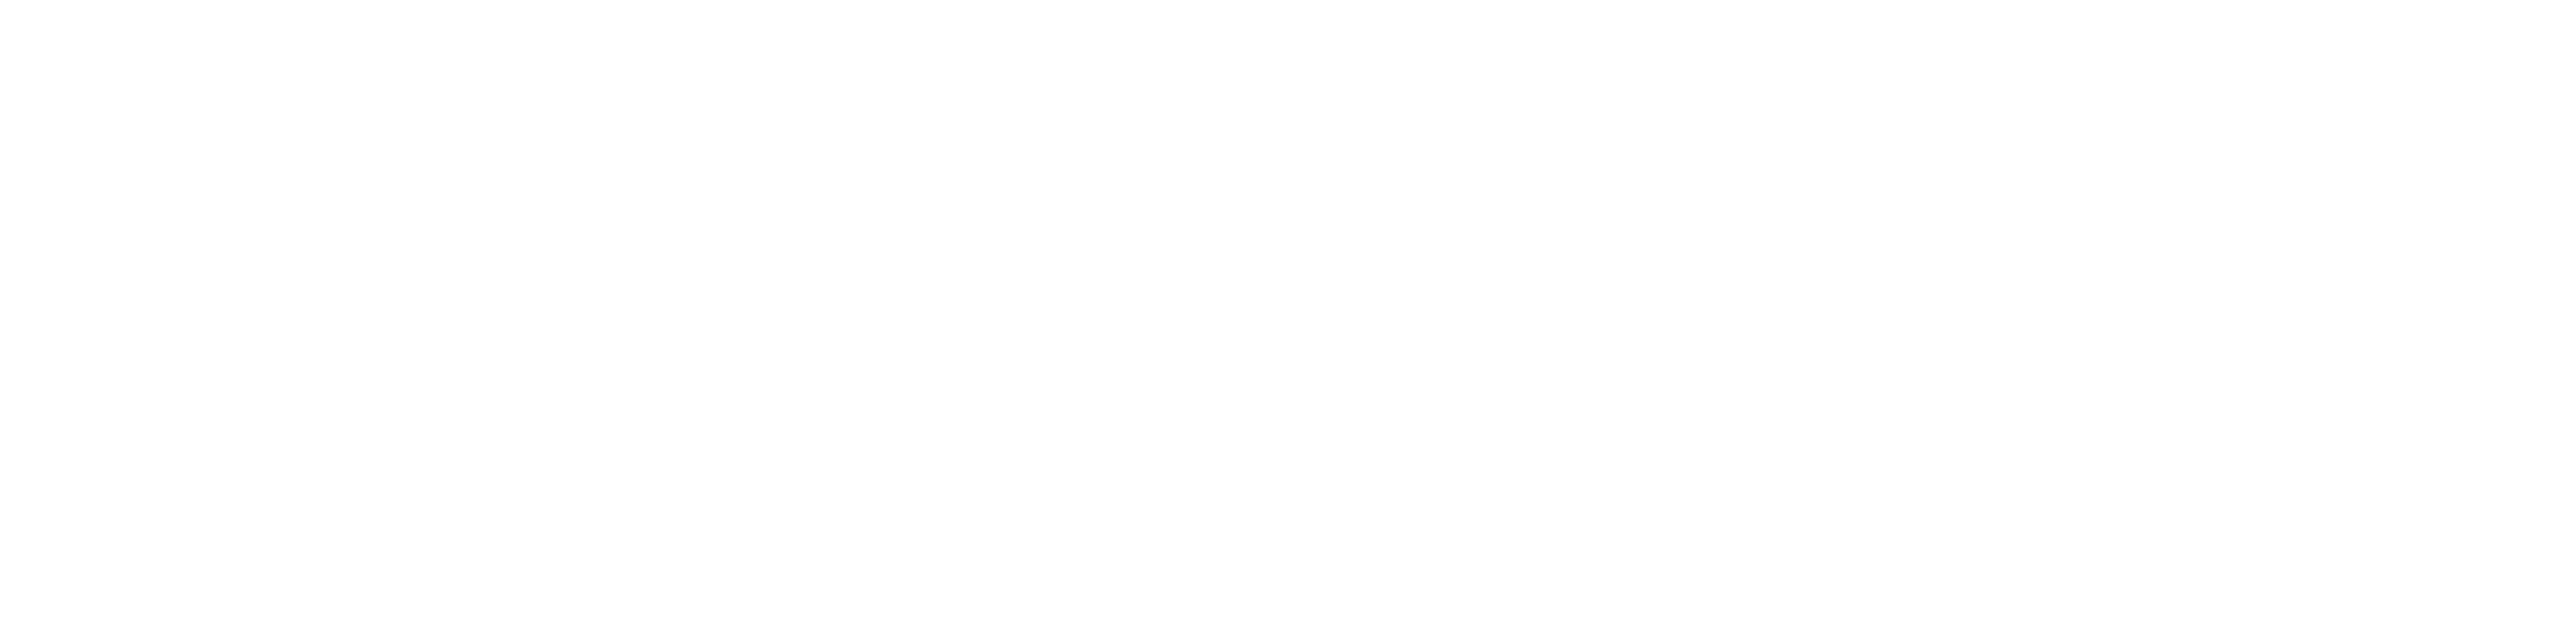

2020-06-07 18:55:10,069 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:55:16,158 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:55:22,288 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:55:28,403 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:55:34,555 logger INFO loss 3.33, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


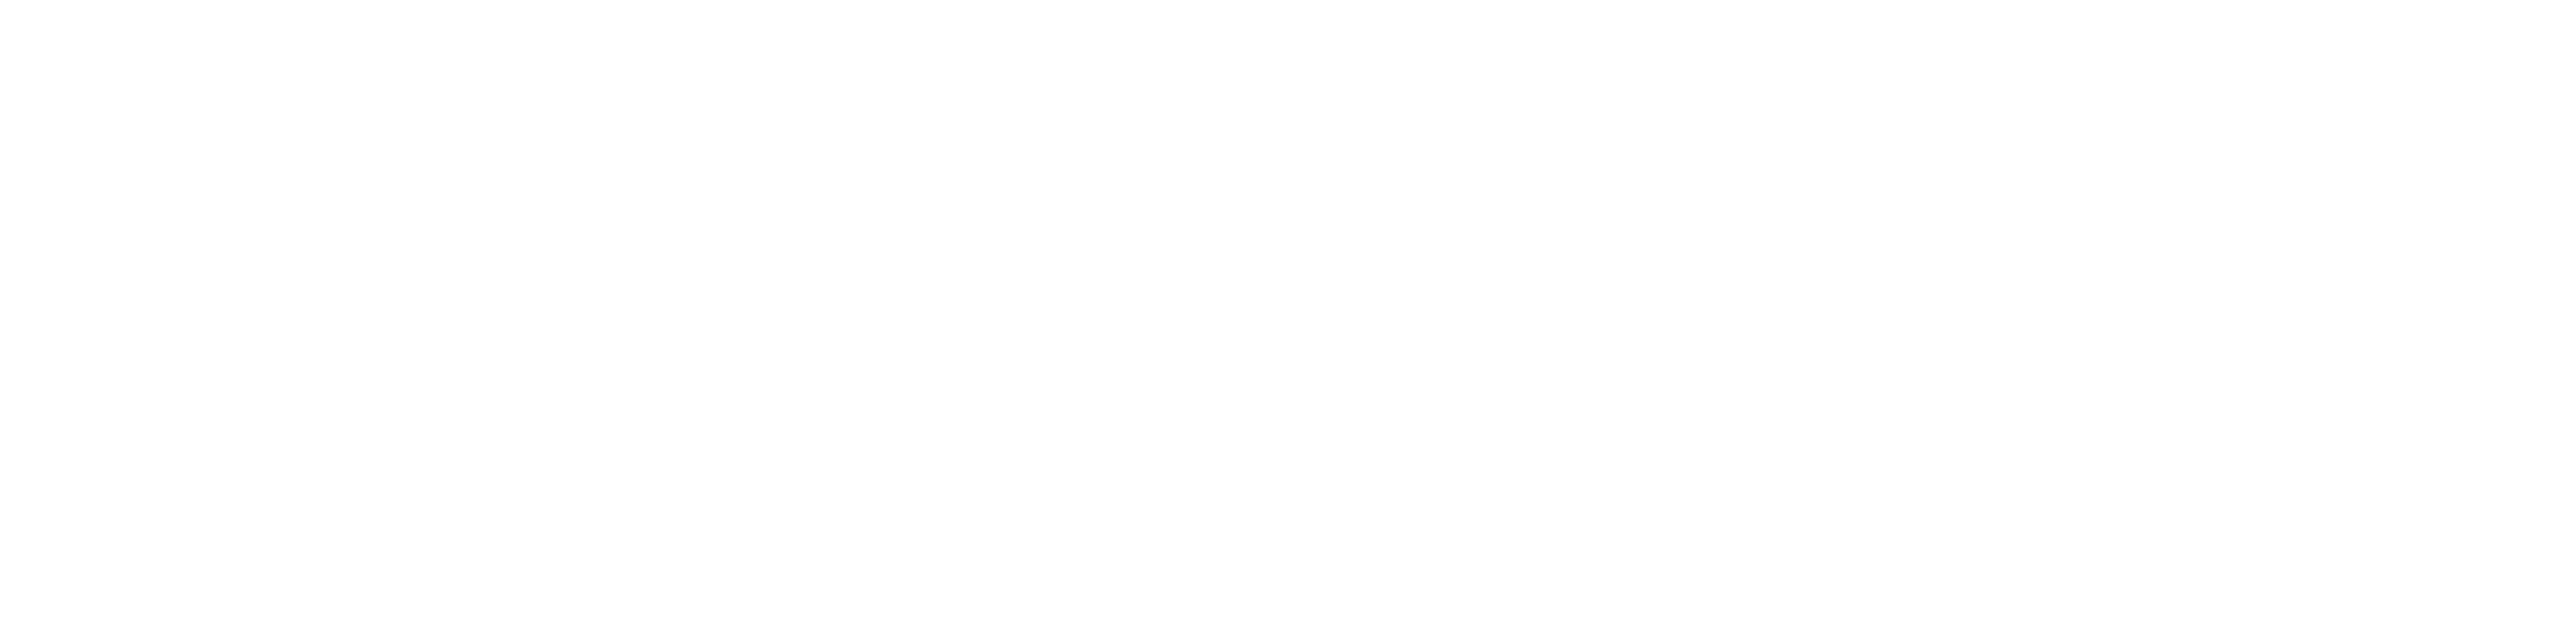

2020-06-07 18:55:58,399 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:04,564 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:10,672 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:16,839 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:22,941 logger INFO loss 3.33, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


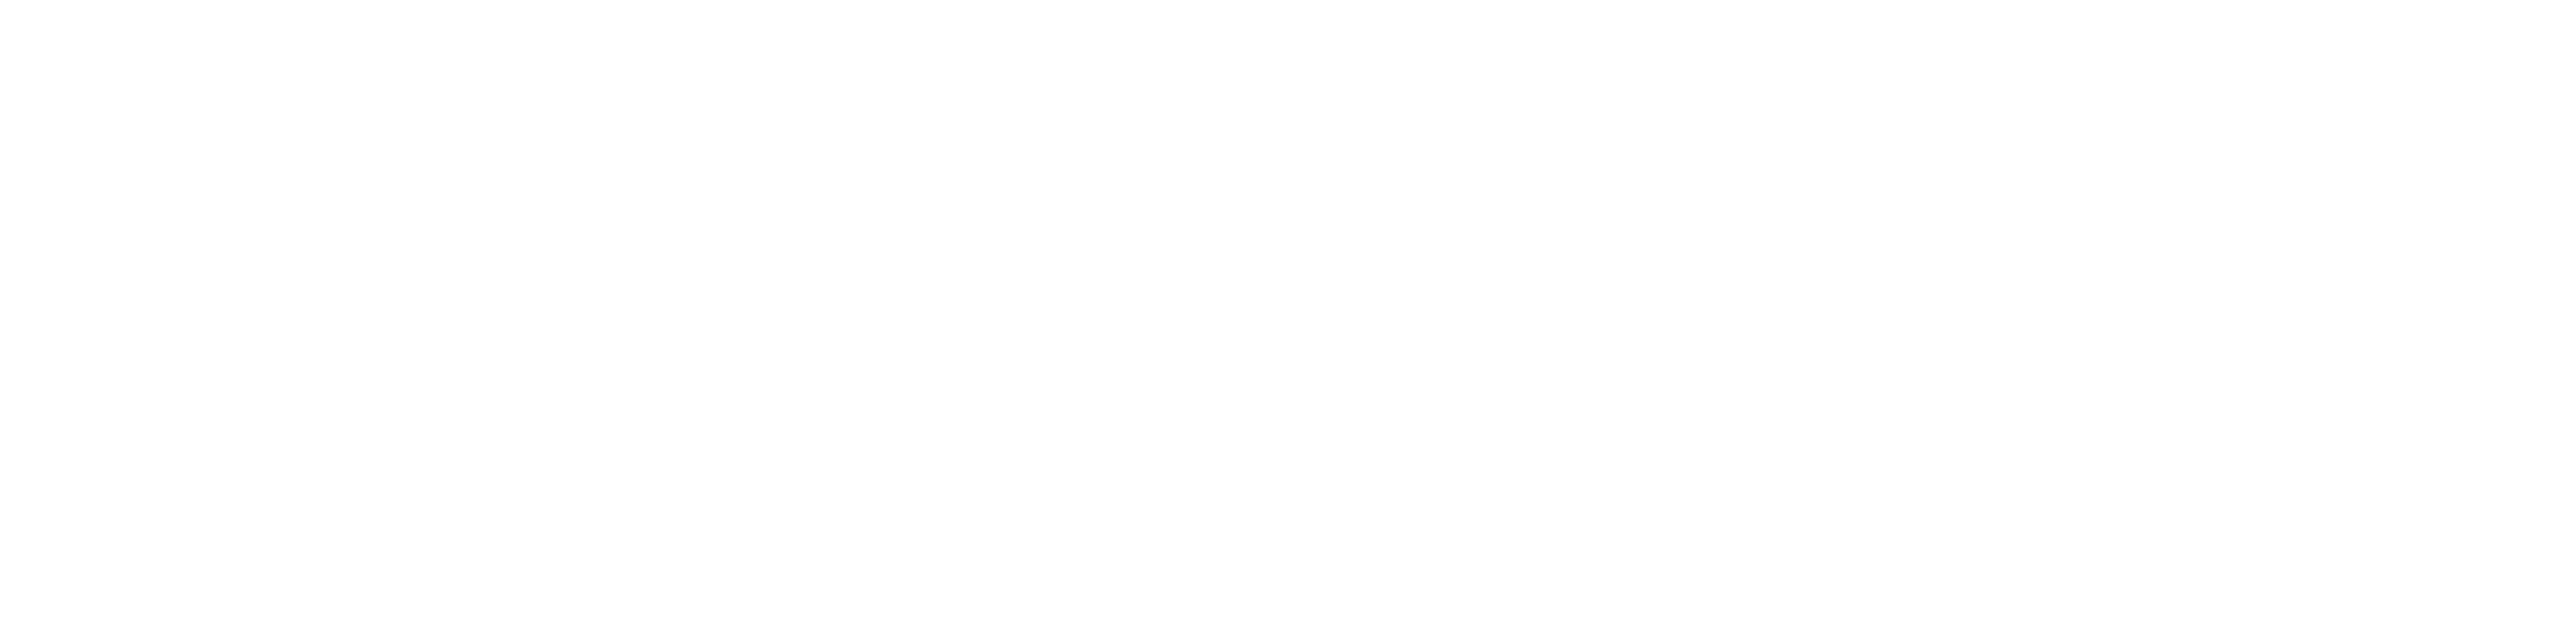

2020-06-07 18:56:46,803 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:52,864 logger INFO loss 3.33, MemUsed:50.05
2020-06-07 18:56:58,976 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:05,059 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:11,196 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


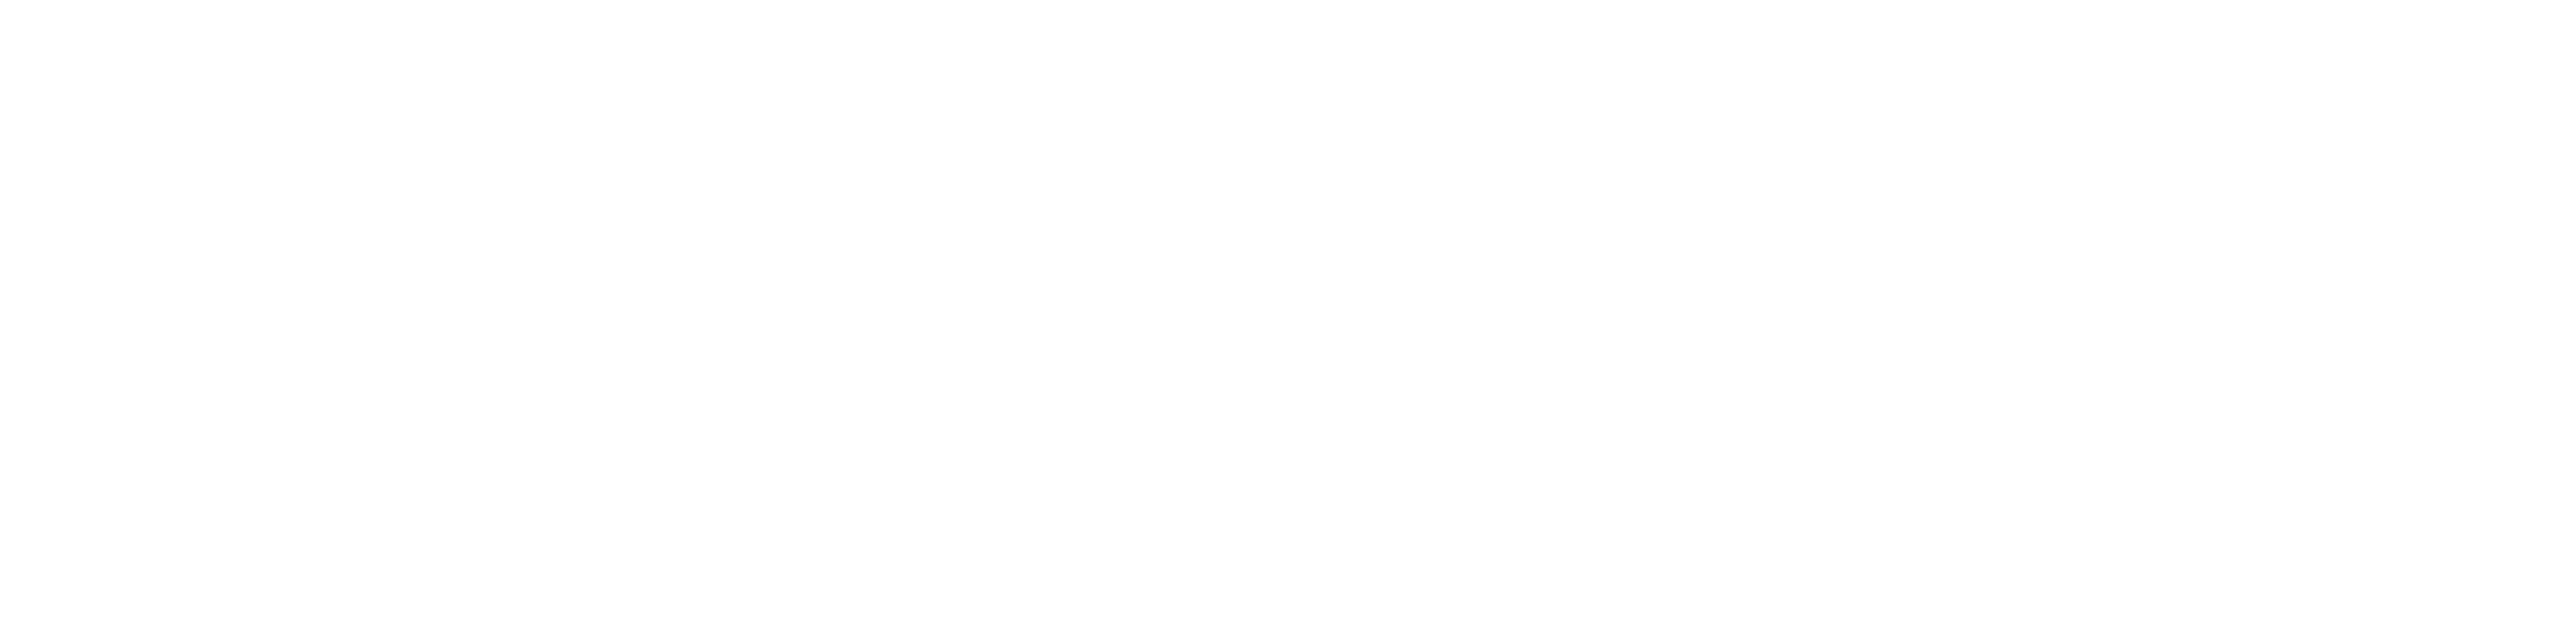

2020-06-07 18:57:35,057 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:41,132 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:47,275 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:53,355 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:57:59,466 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


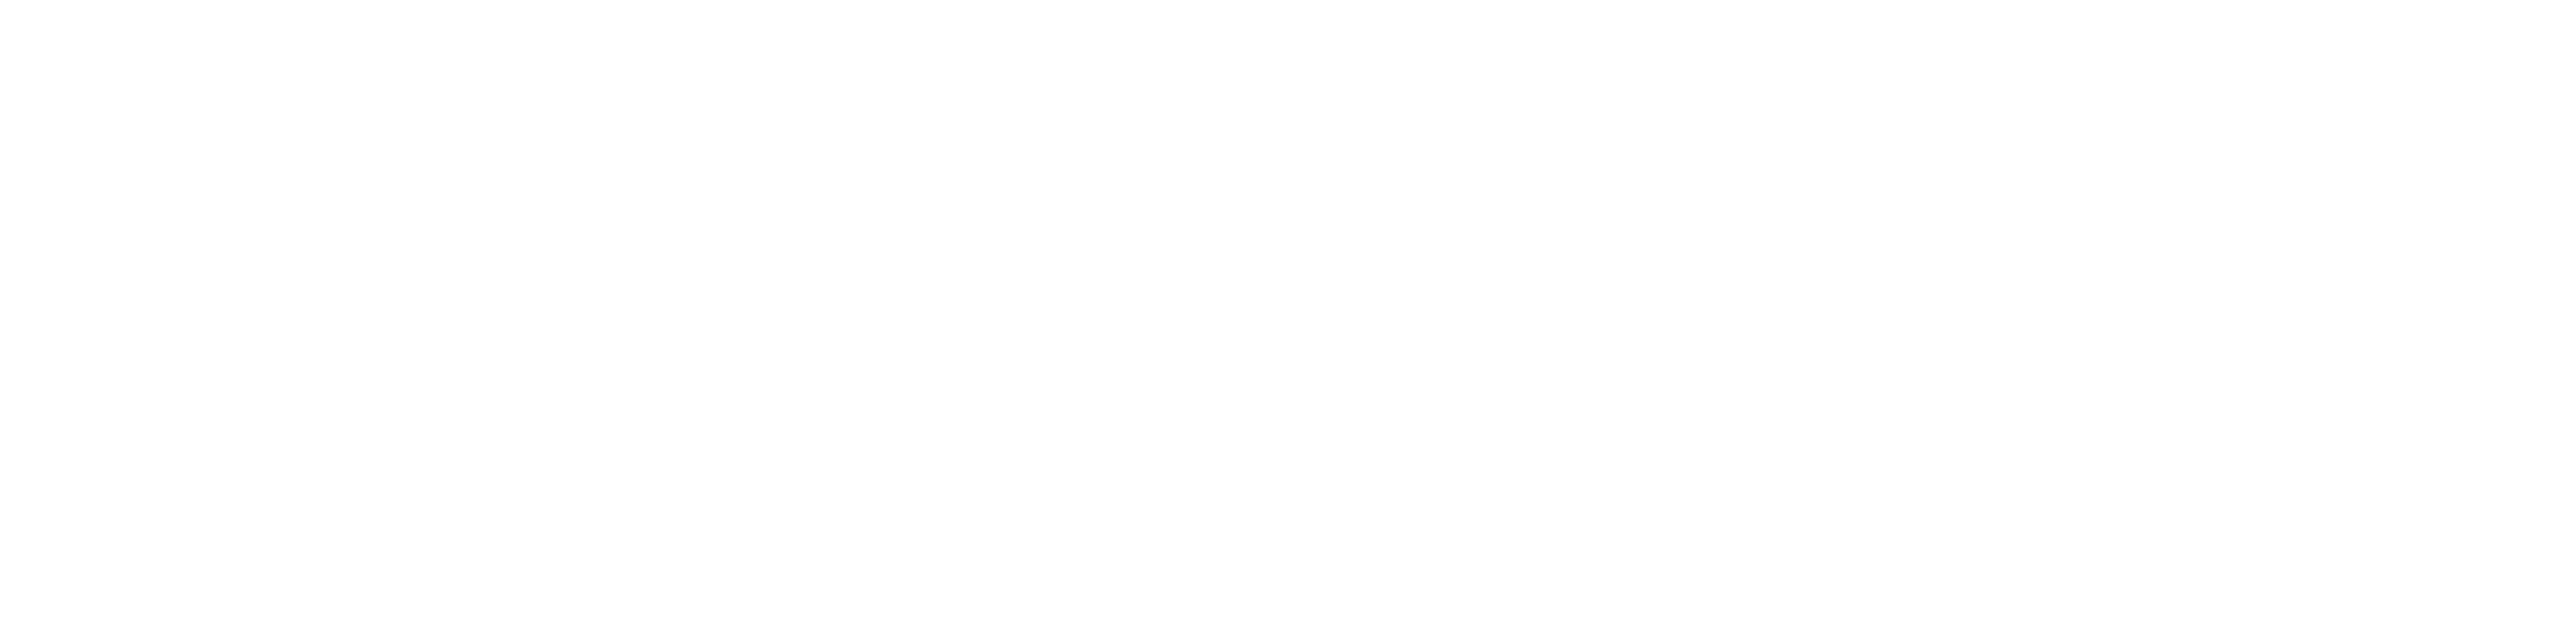

2020-06-07 18:58:23,318 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:58:29,704 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:58:35,828 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:58:42,070 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:58:48,255 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


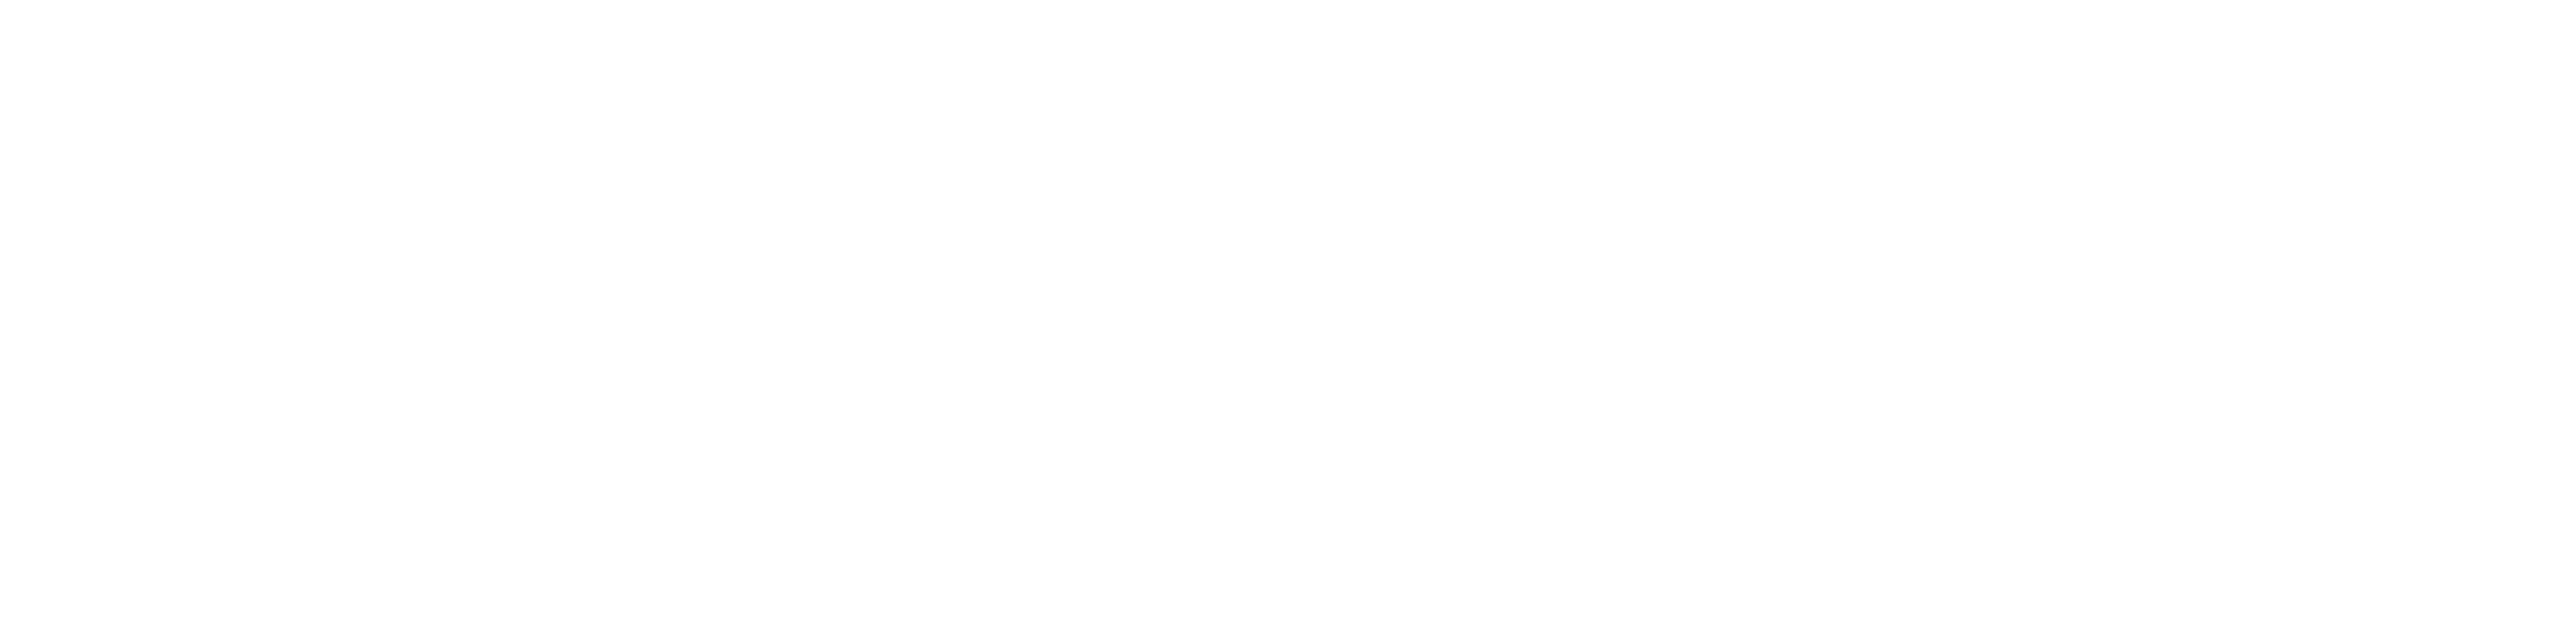

2020-06-07 18:59:12,897 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:59:19,377 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:59:25,932 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:59:32,026 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 18:59:38,197 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


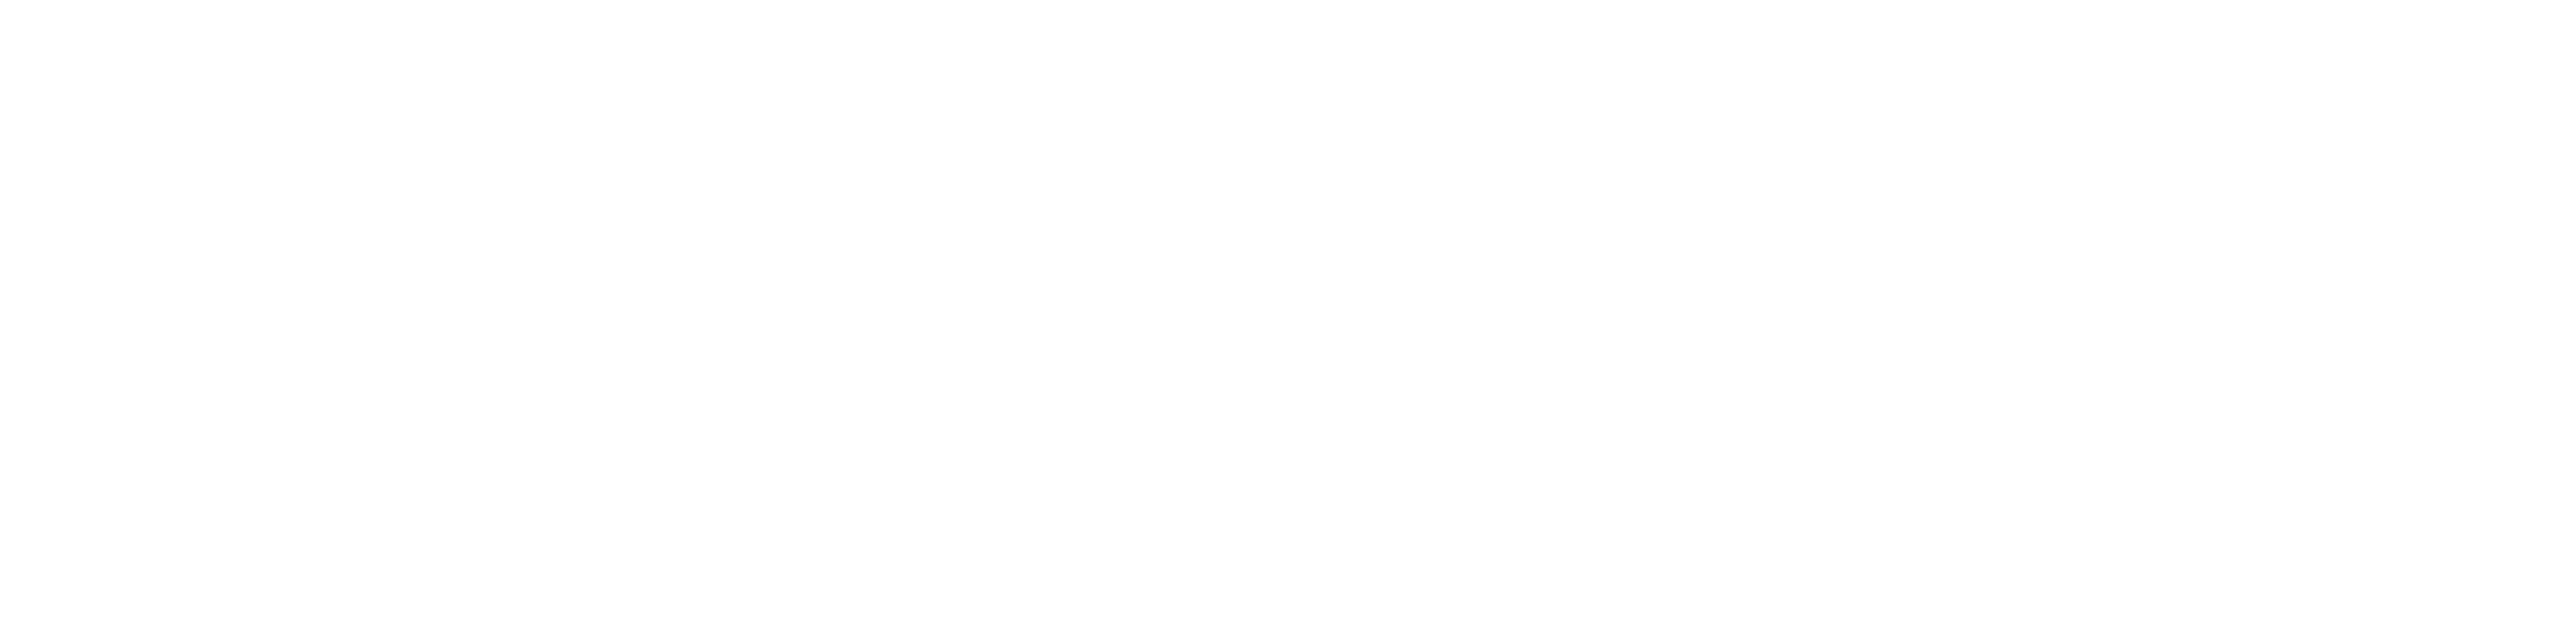

2020-06-07 19:00:02,008 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:00:08,192 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:00:14,289 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:00:20,440 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:00:26,569 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


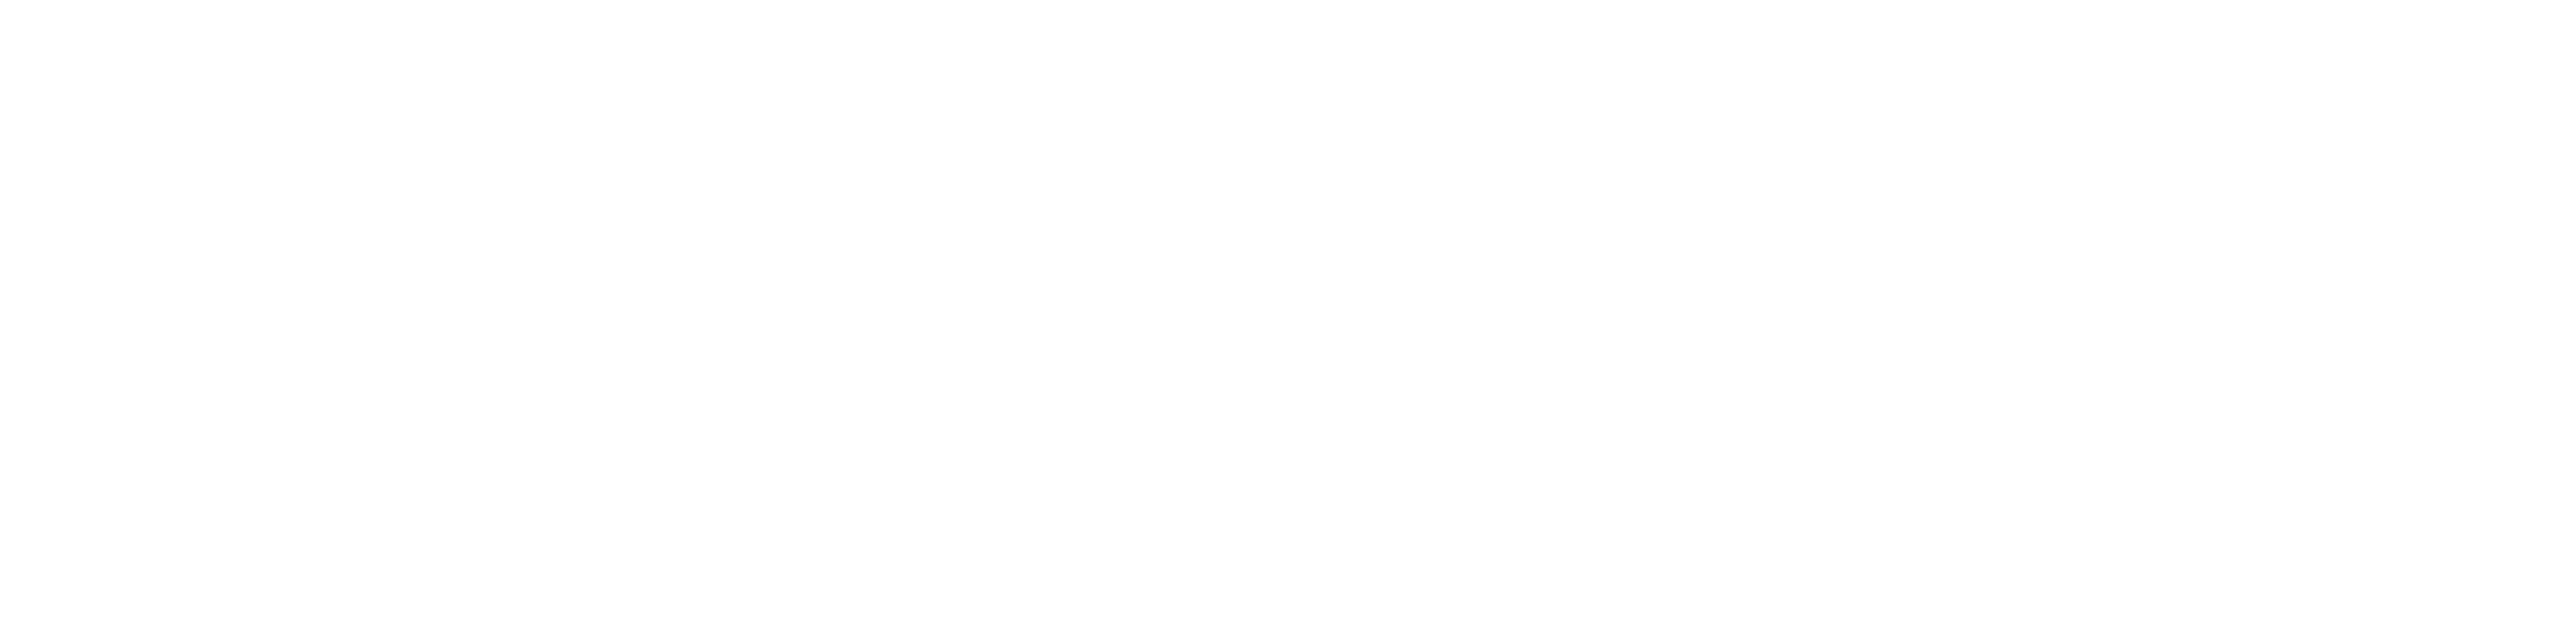

2020-06-07 19:00:50,512 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:00:56,684 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:02,861 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:09,303 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:15,505 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


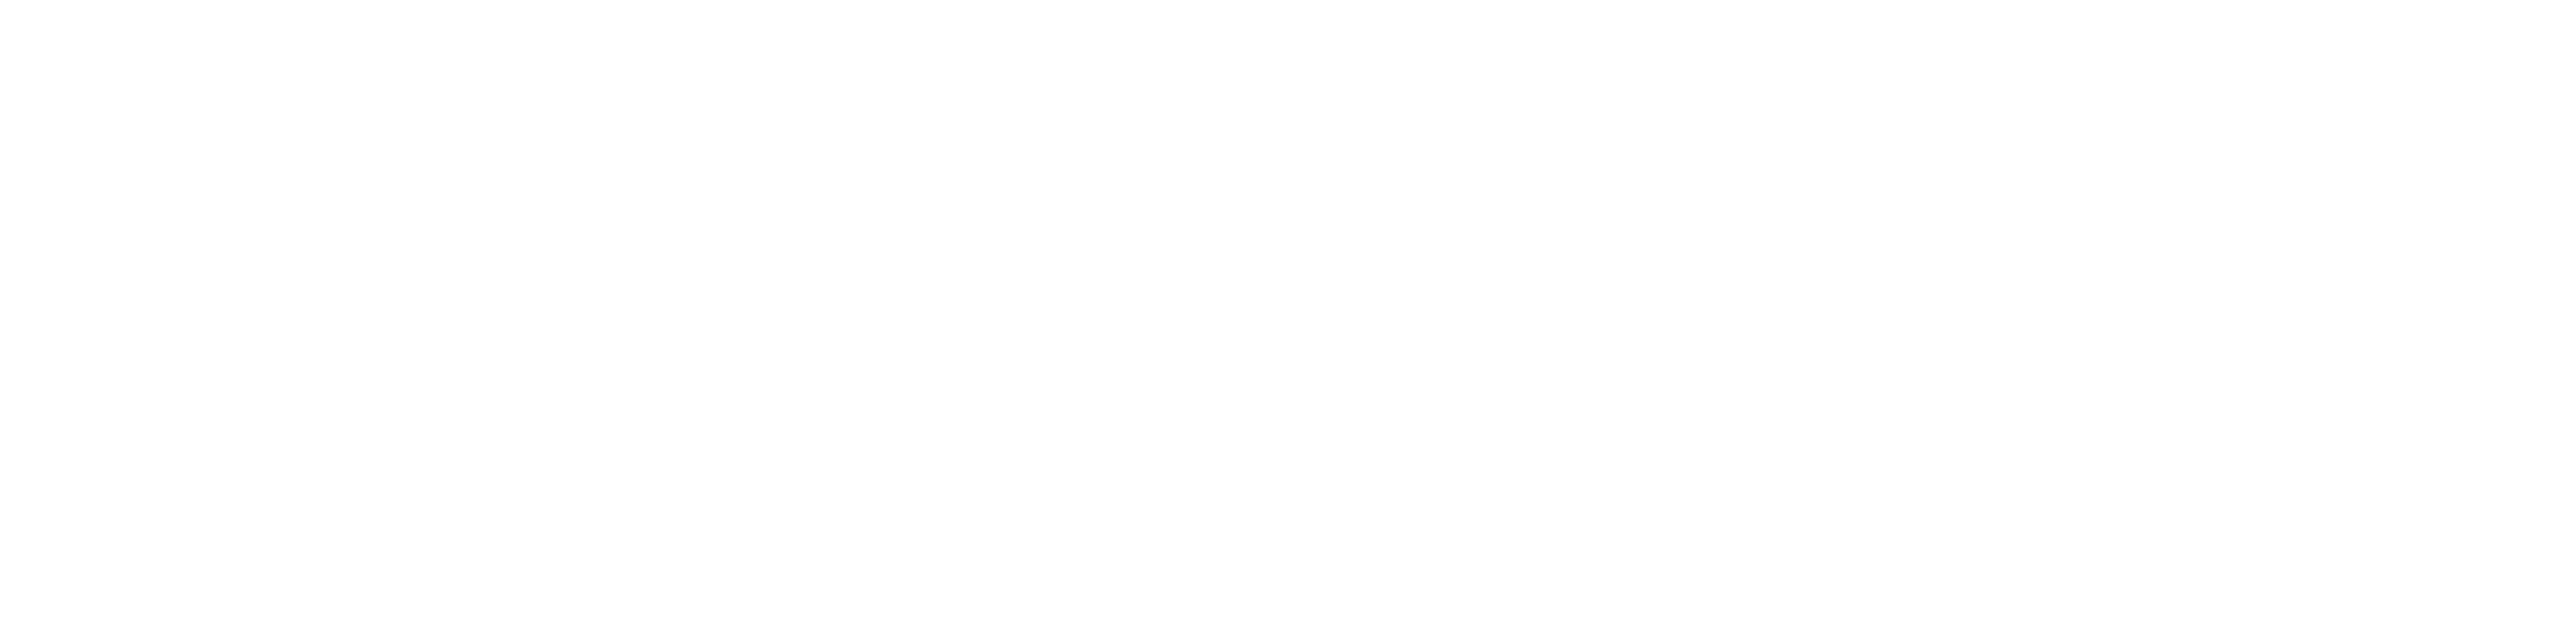

2020-06-07 19:01:39,616 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:46,370 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:52,846 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:01:58,986 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:02:05,094 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


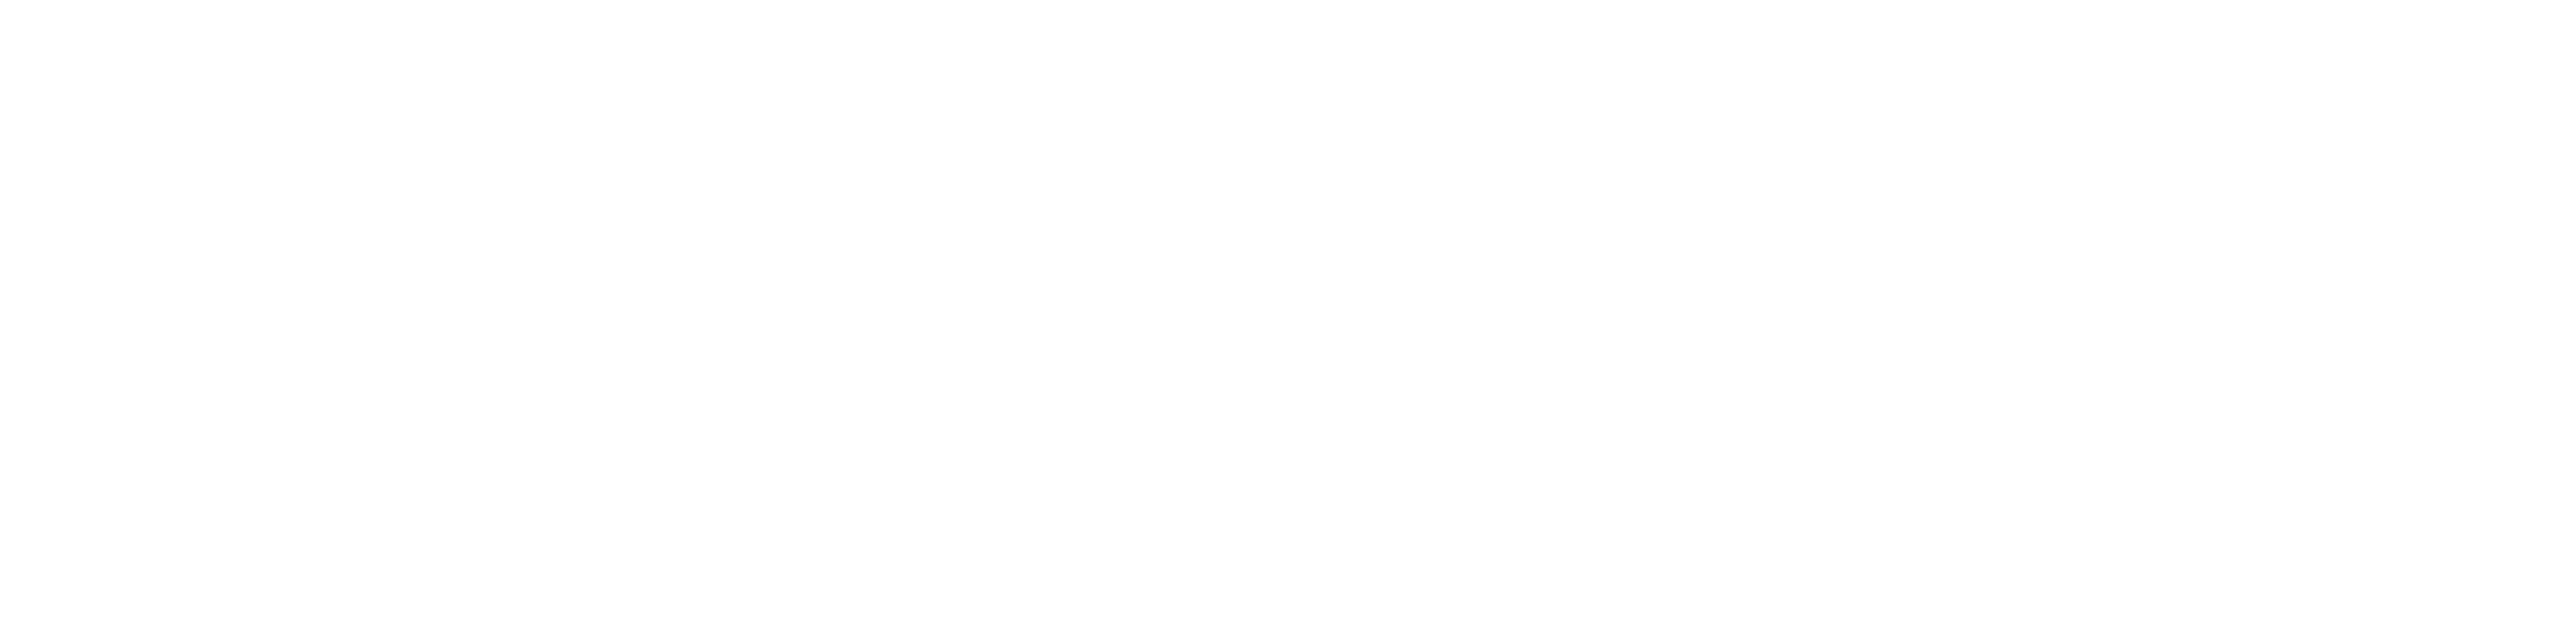

2020-06-07 19:02:29,043 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:02:35,134 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:02:41,274 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:02:47,374 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:02:53,515 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


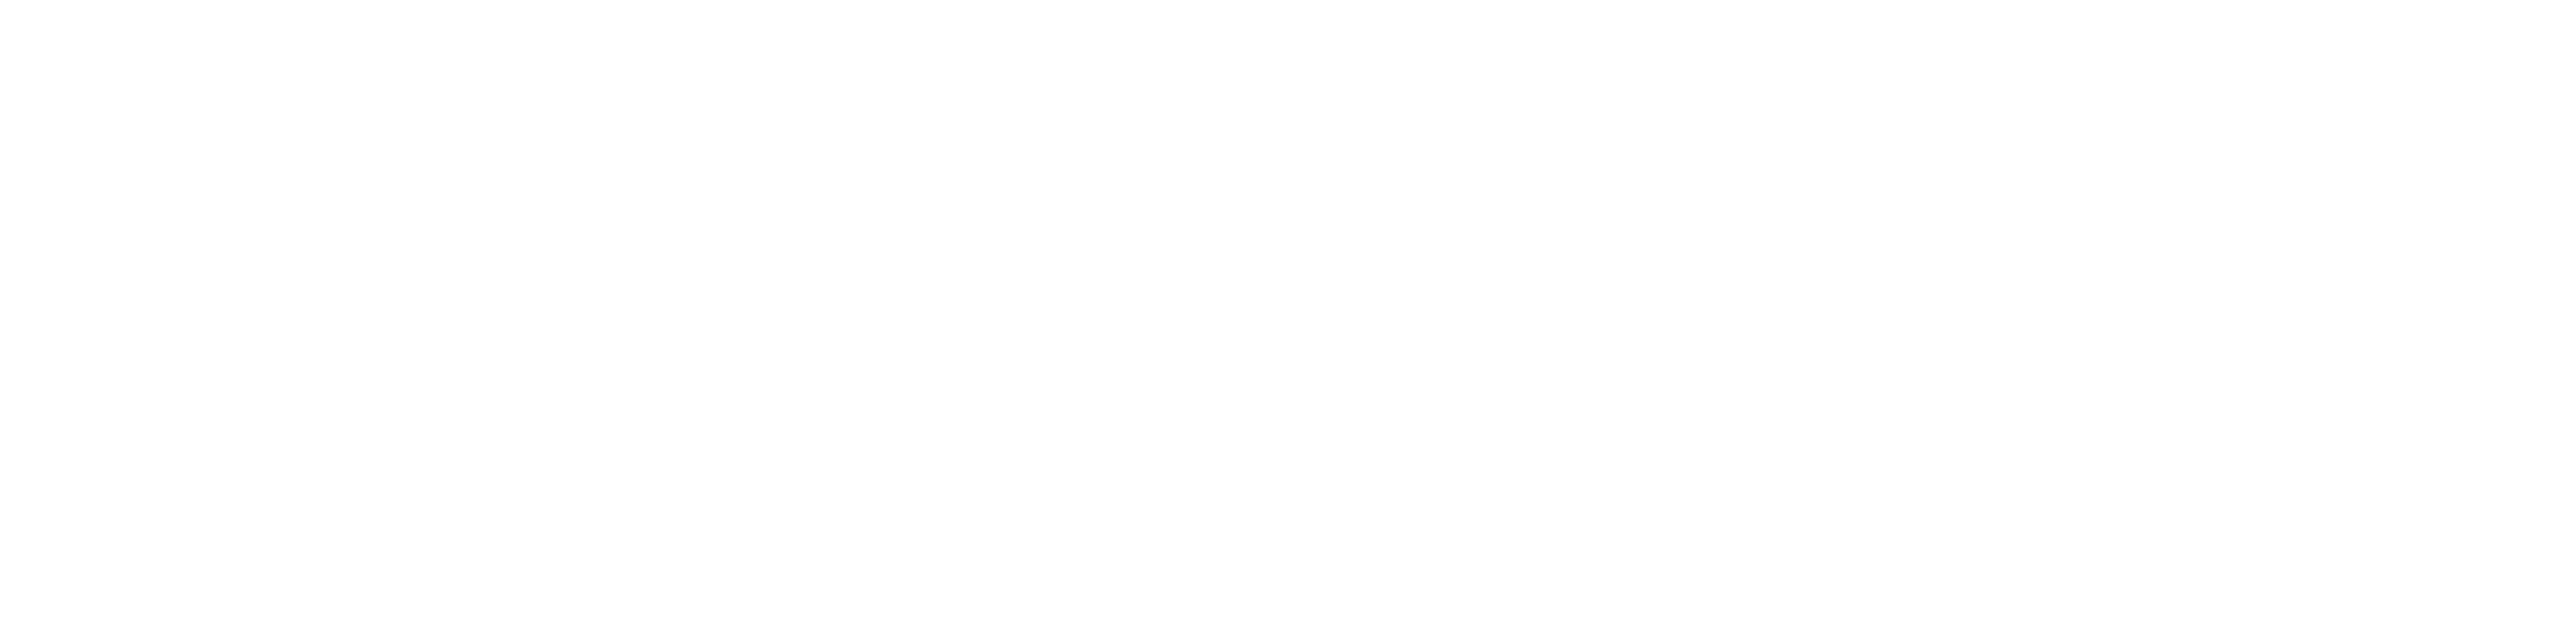

2020-06-07 19:03:17,387 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:03:23,472 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:03:29,738 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:03:36,522 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:03:42,684 logger INFO loss 3.32, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


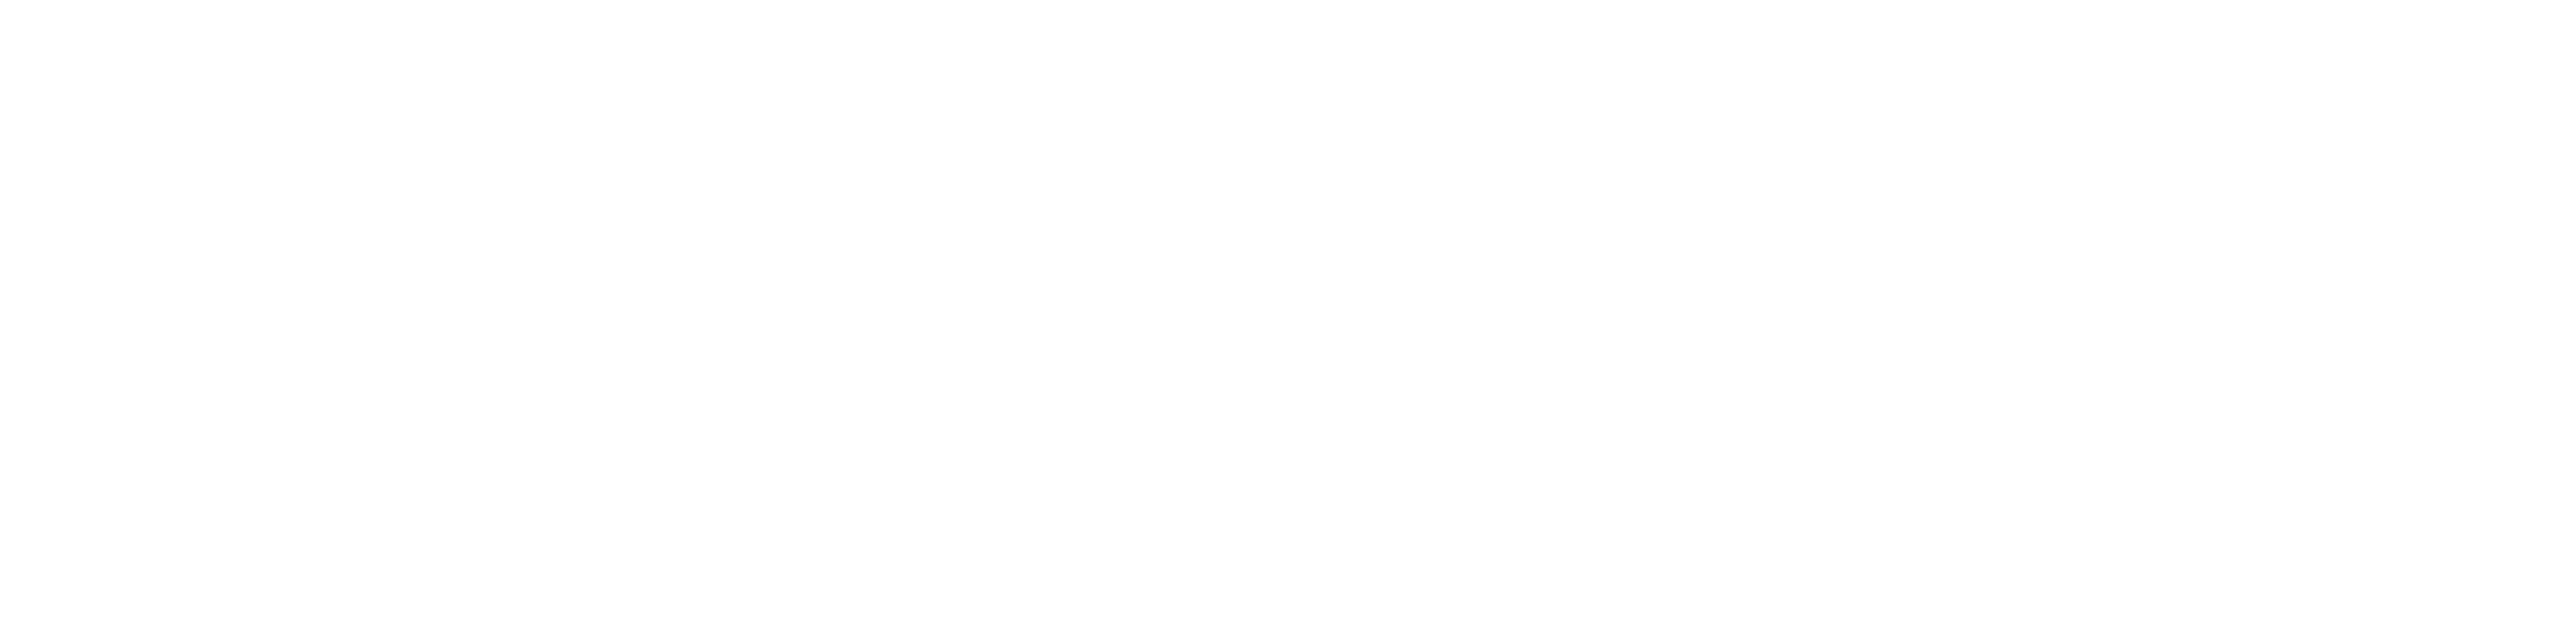

2020-06-07 19:04:06,666 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:04:12,828 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:04:18,946 logger INFO loss 3.32, MemUsed:50.05
2020-06-07 19:04:25,343 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:04:31,573 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


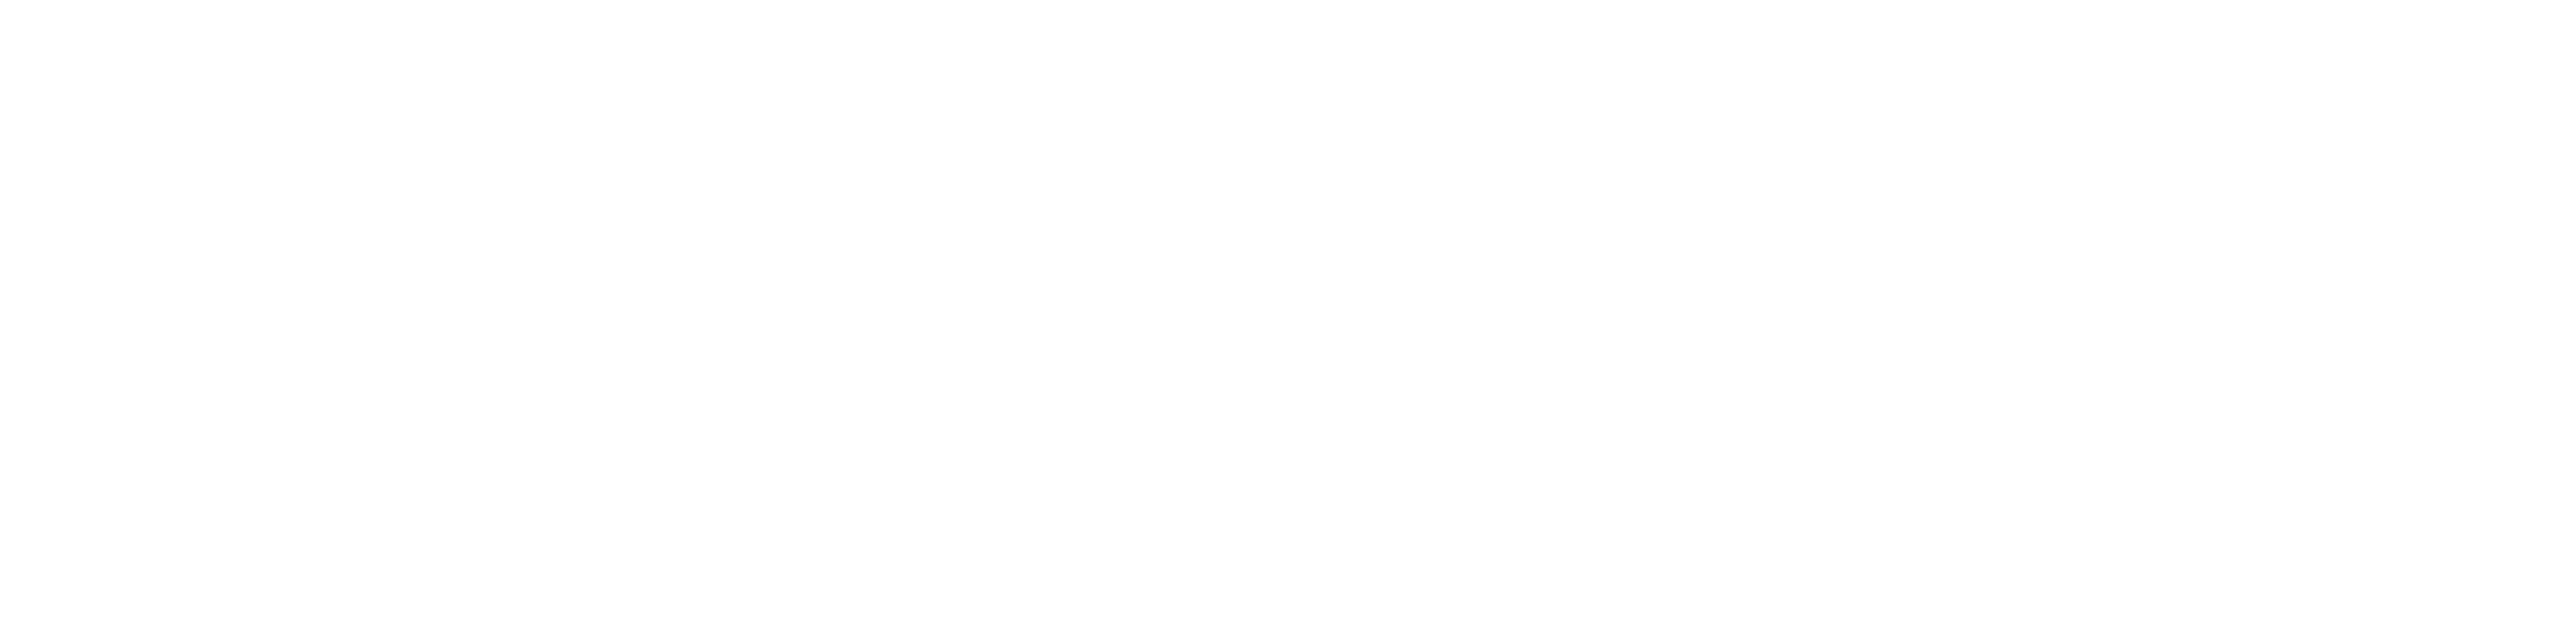

2020-06-07 19:04:55,807 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:01,889 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:08,020 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:14,144 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:20,324 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


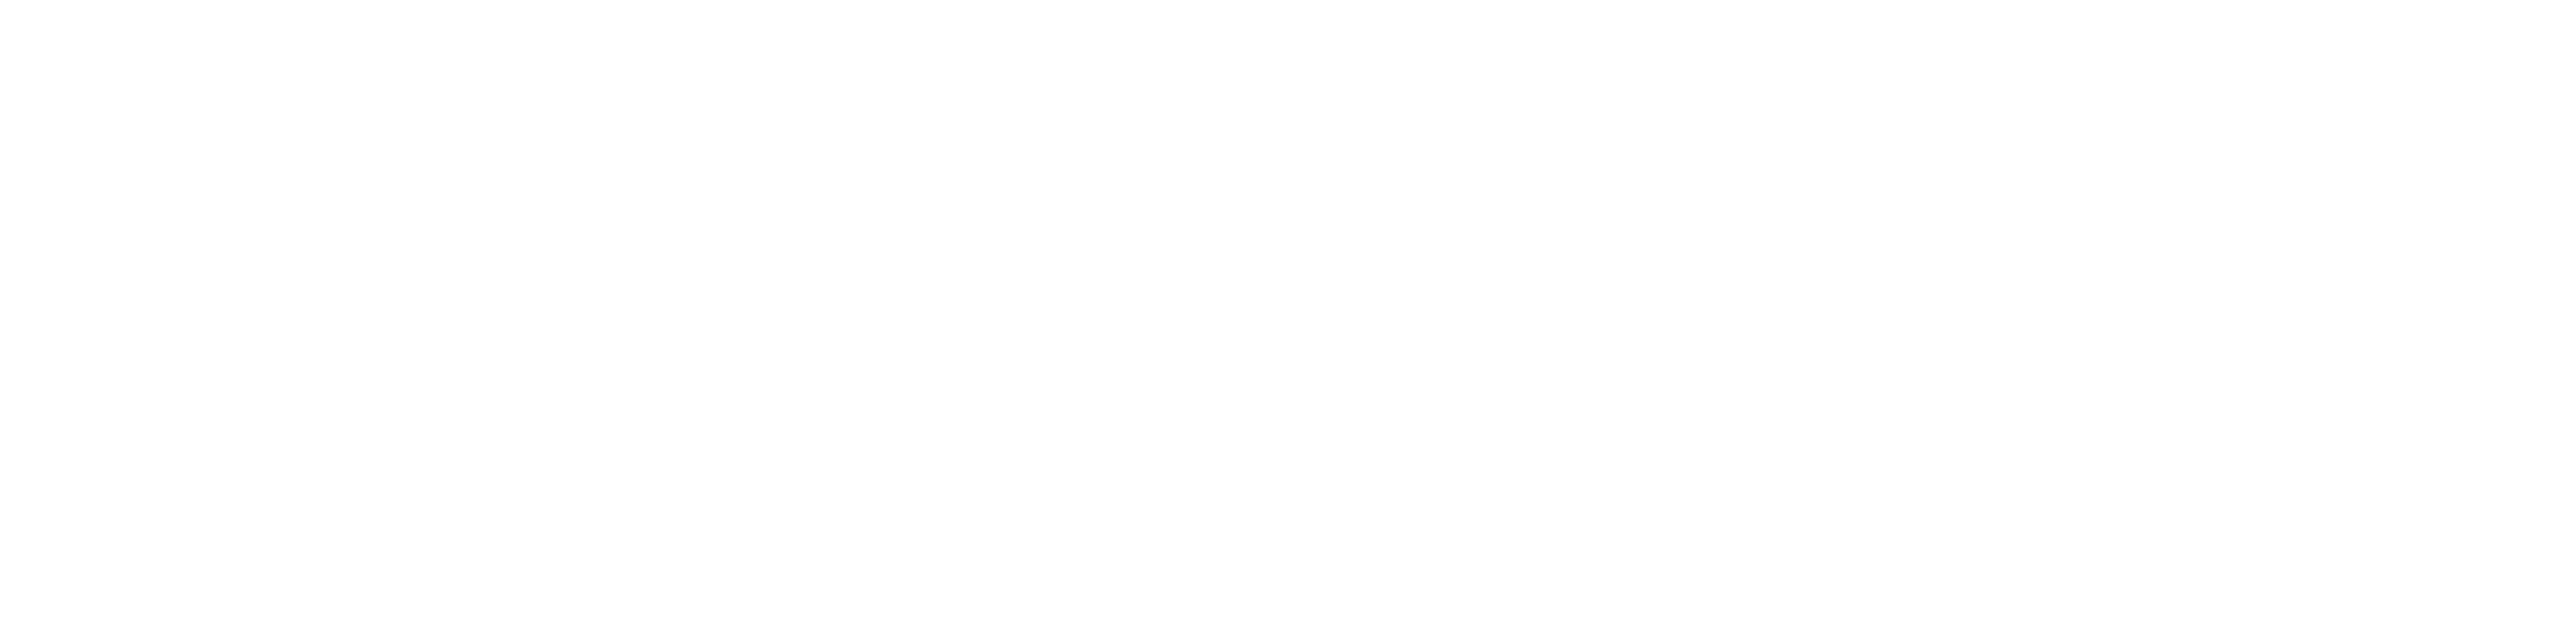

2020-06-07 19:05:44,272 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:50,455 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:05:56,624 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:03,065 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:09,493 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


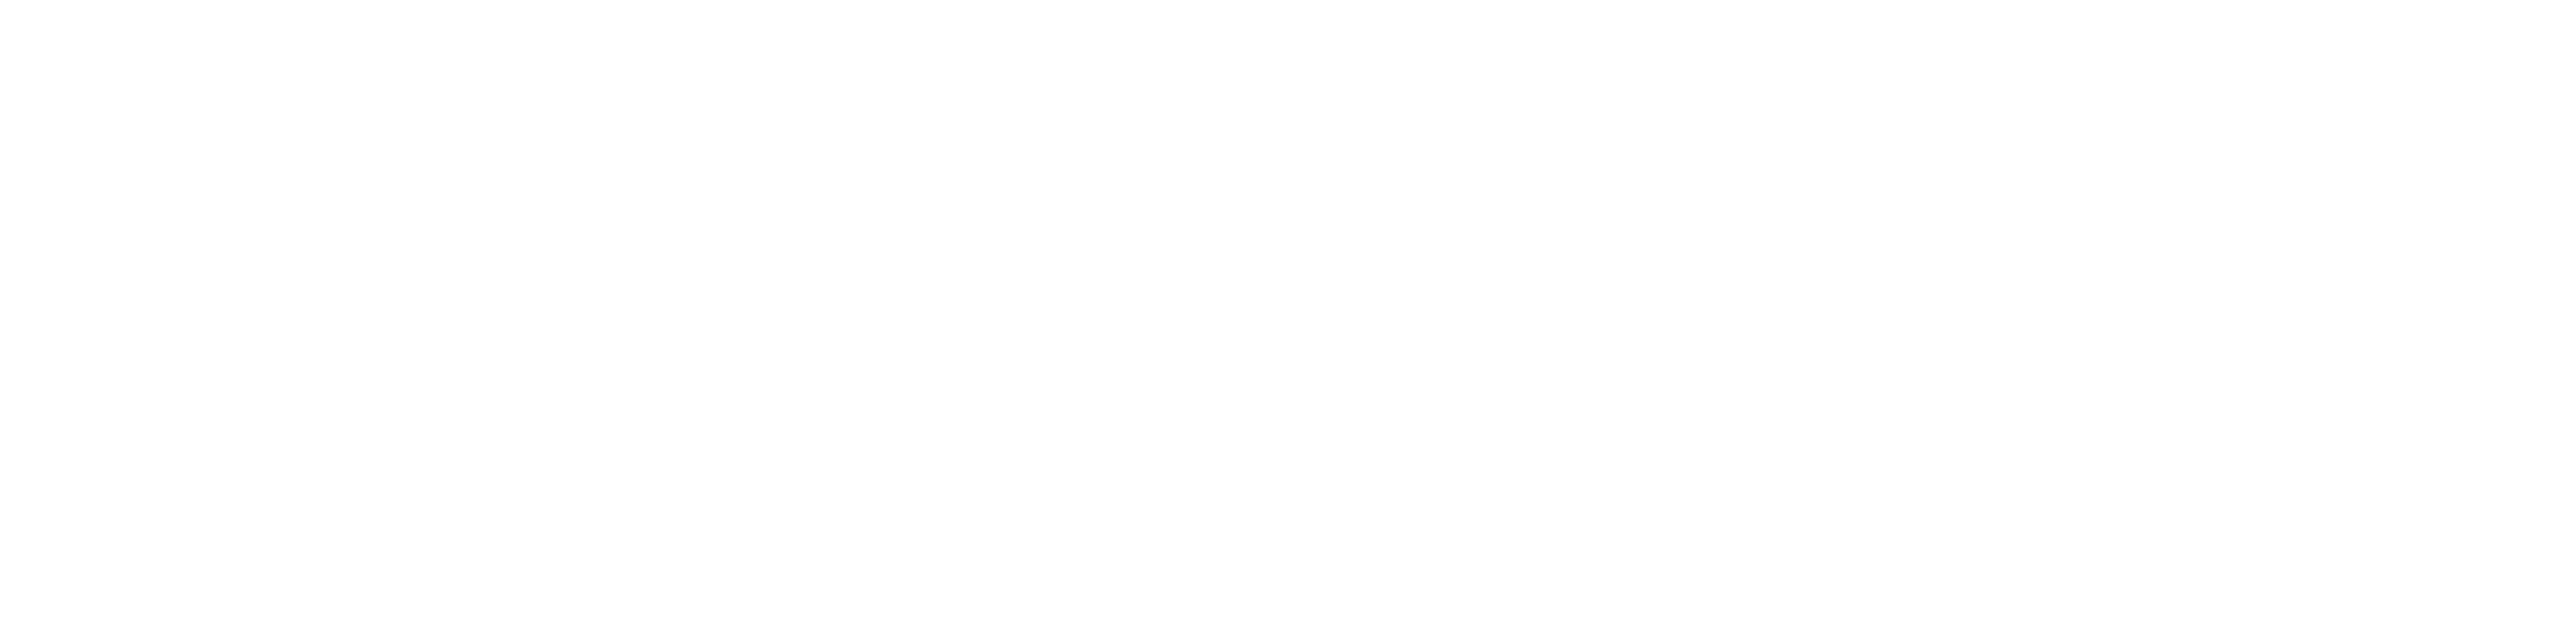

2020-06-07 19:06:34,145 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:40,451 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:46,744 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:52,851 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:06:59,007 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


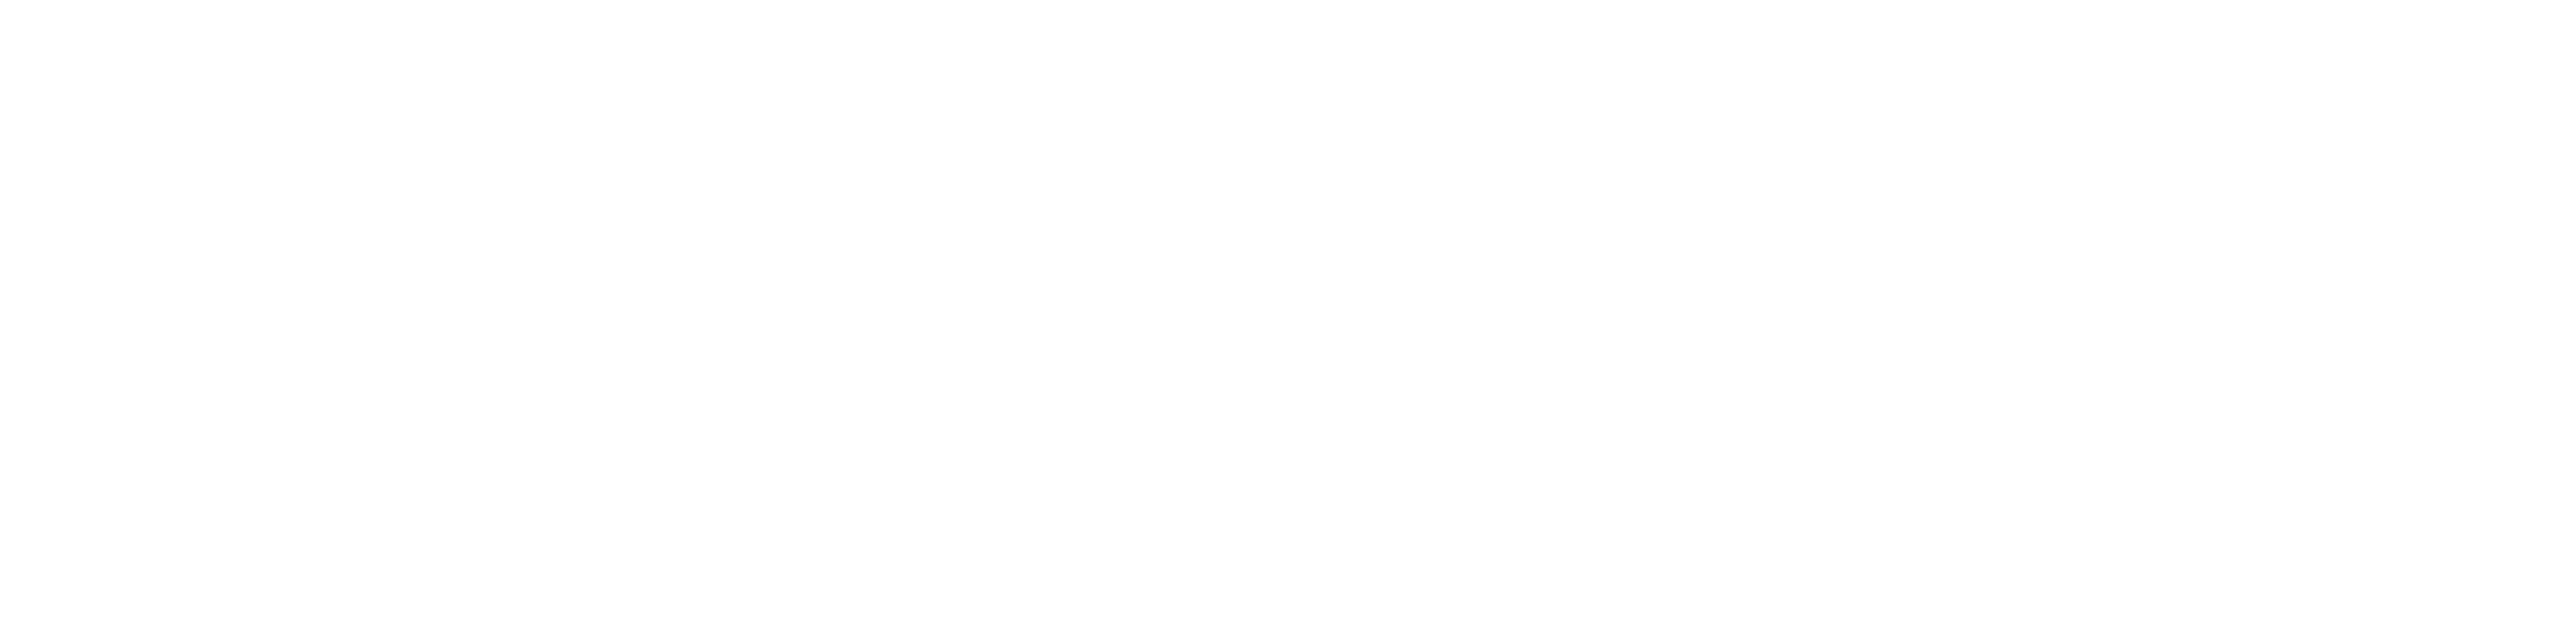

2020-06-07 19:07:23,058 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:07:29,415 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:07:35,536 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:07:41,741 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:07:47,983 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


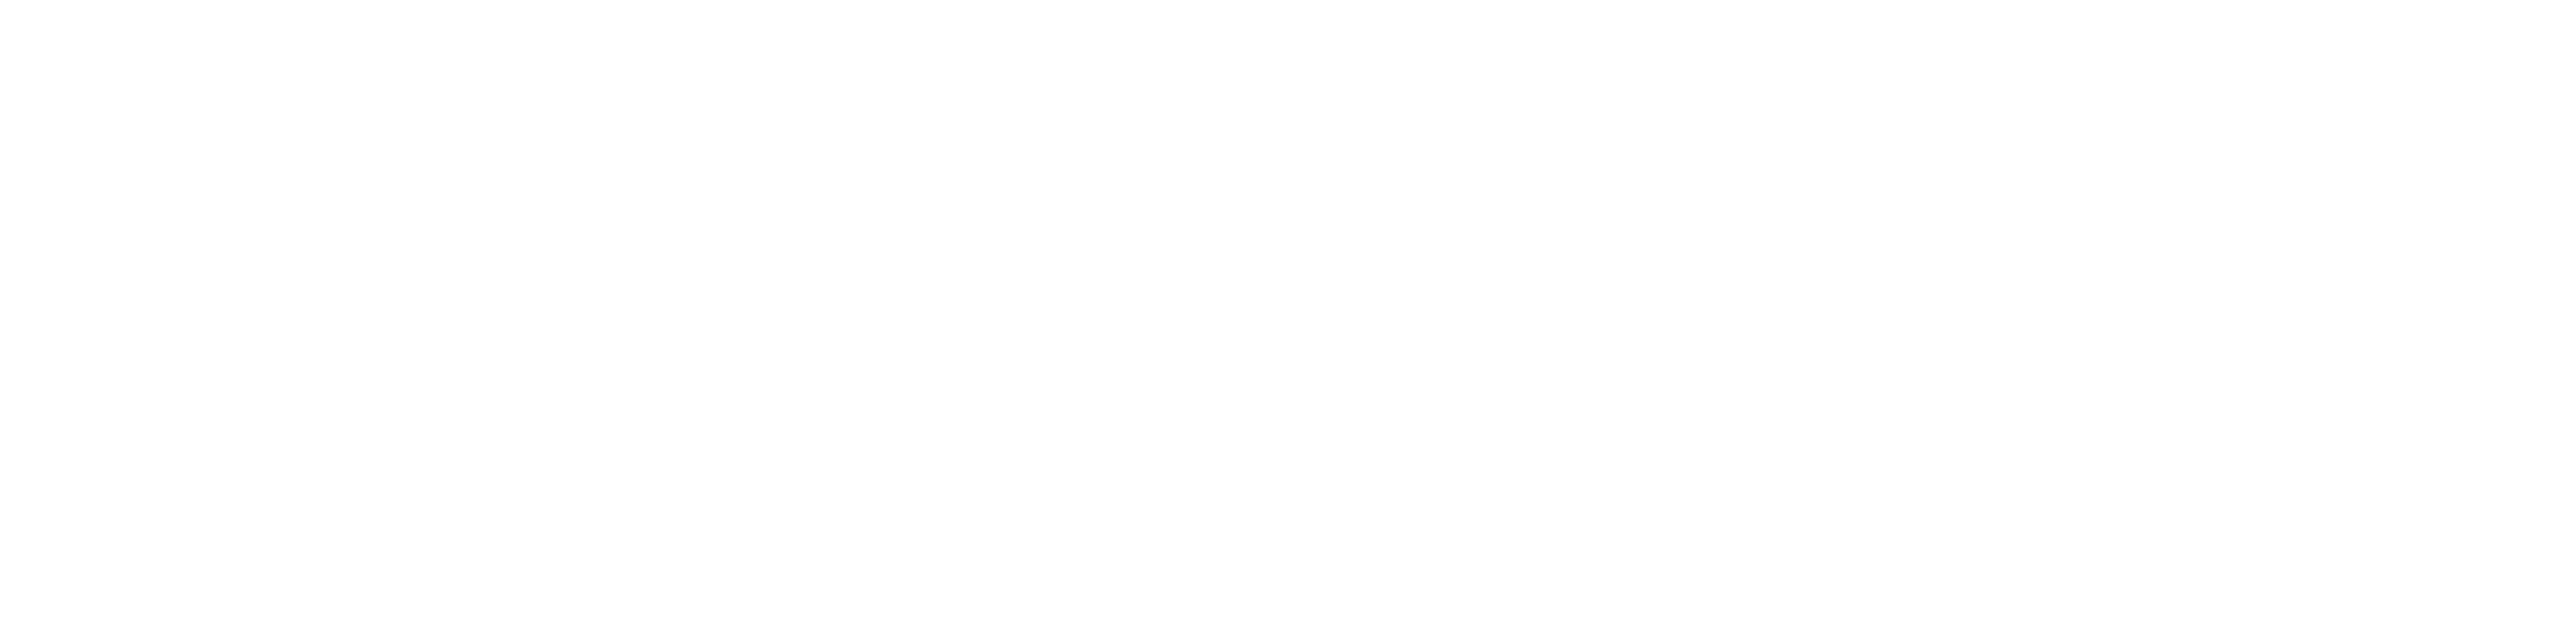

2020-06-07 19:08:11,918 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:08:17,997 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:08:24,132 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:08:30,239 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:08:36,377 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


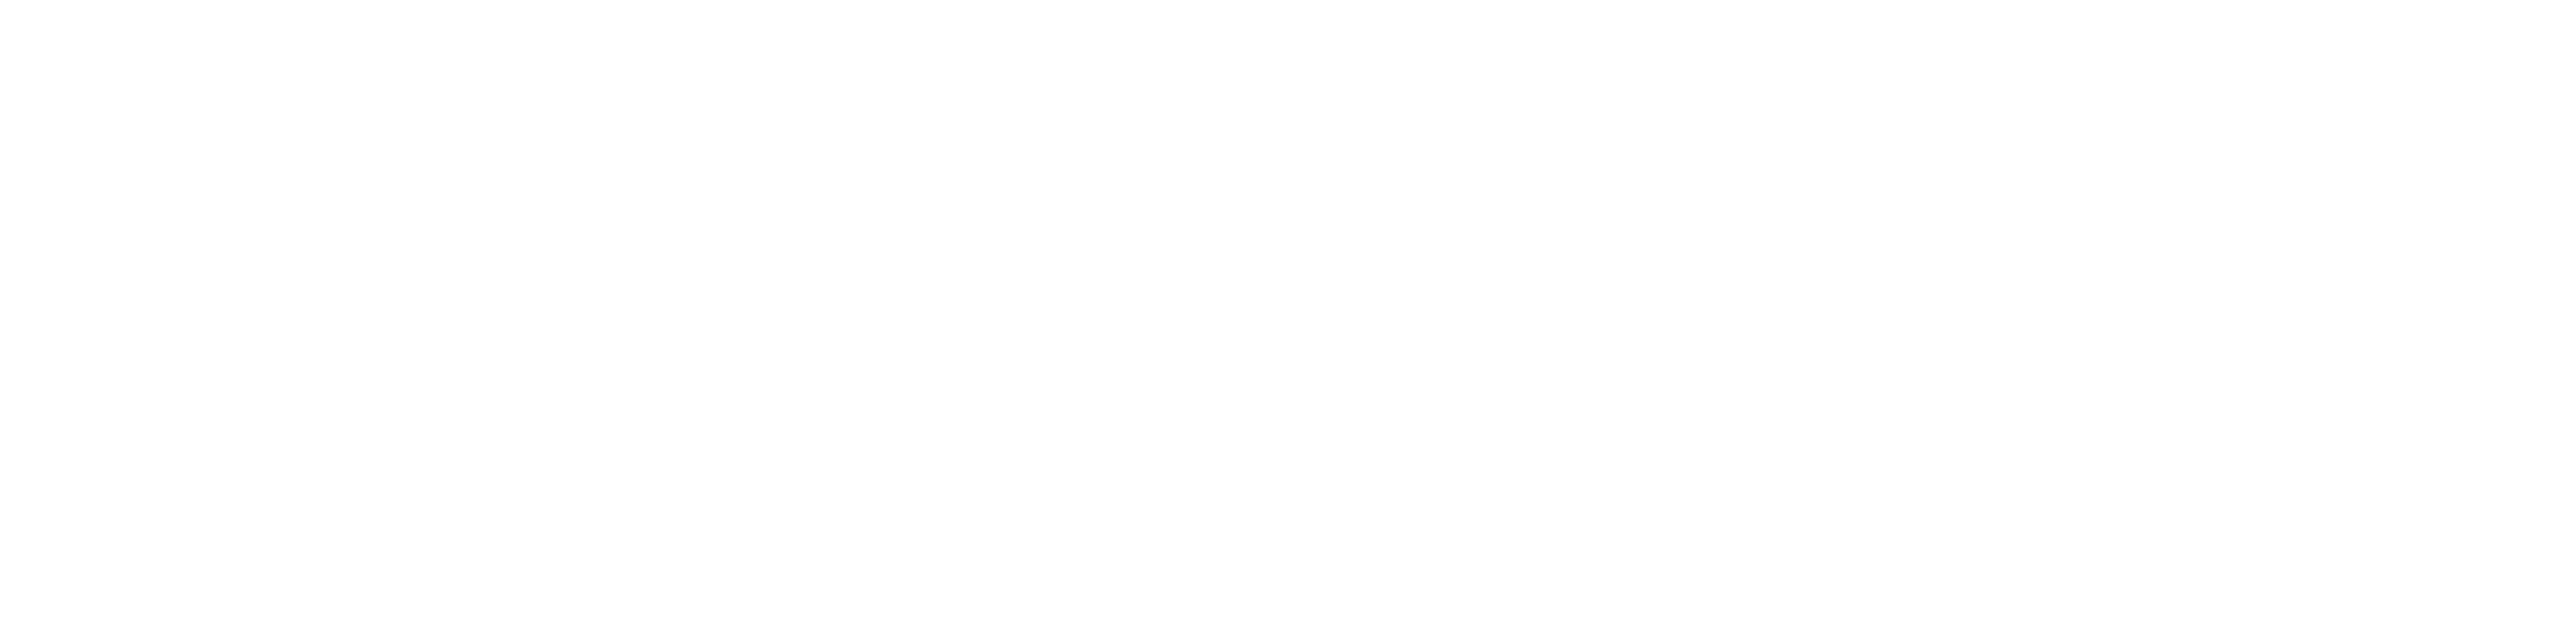

2020-06-07 19:09:00,255 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:09:06,354 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:09:12,467 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:09:18,563 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:09:24,663 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


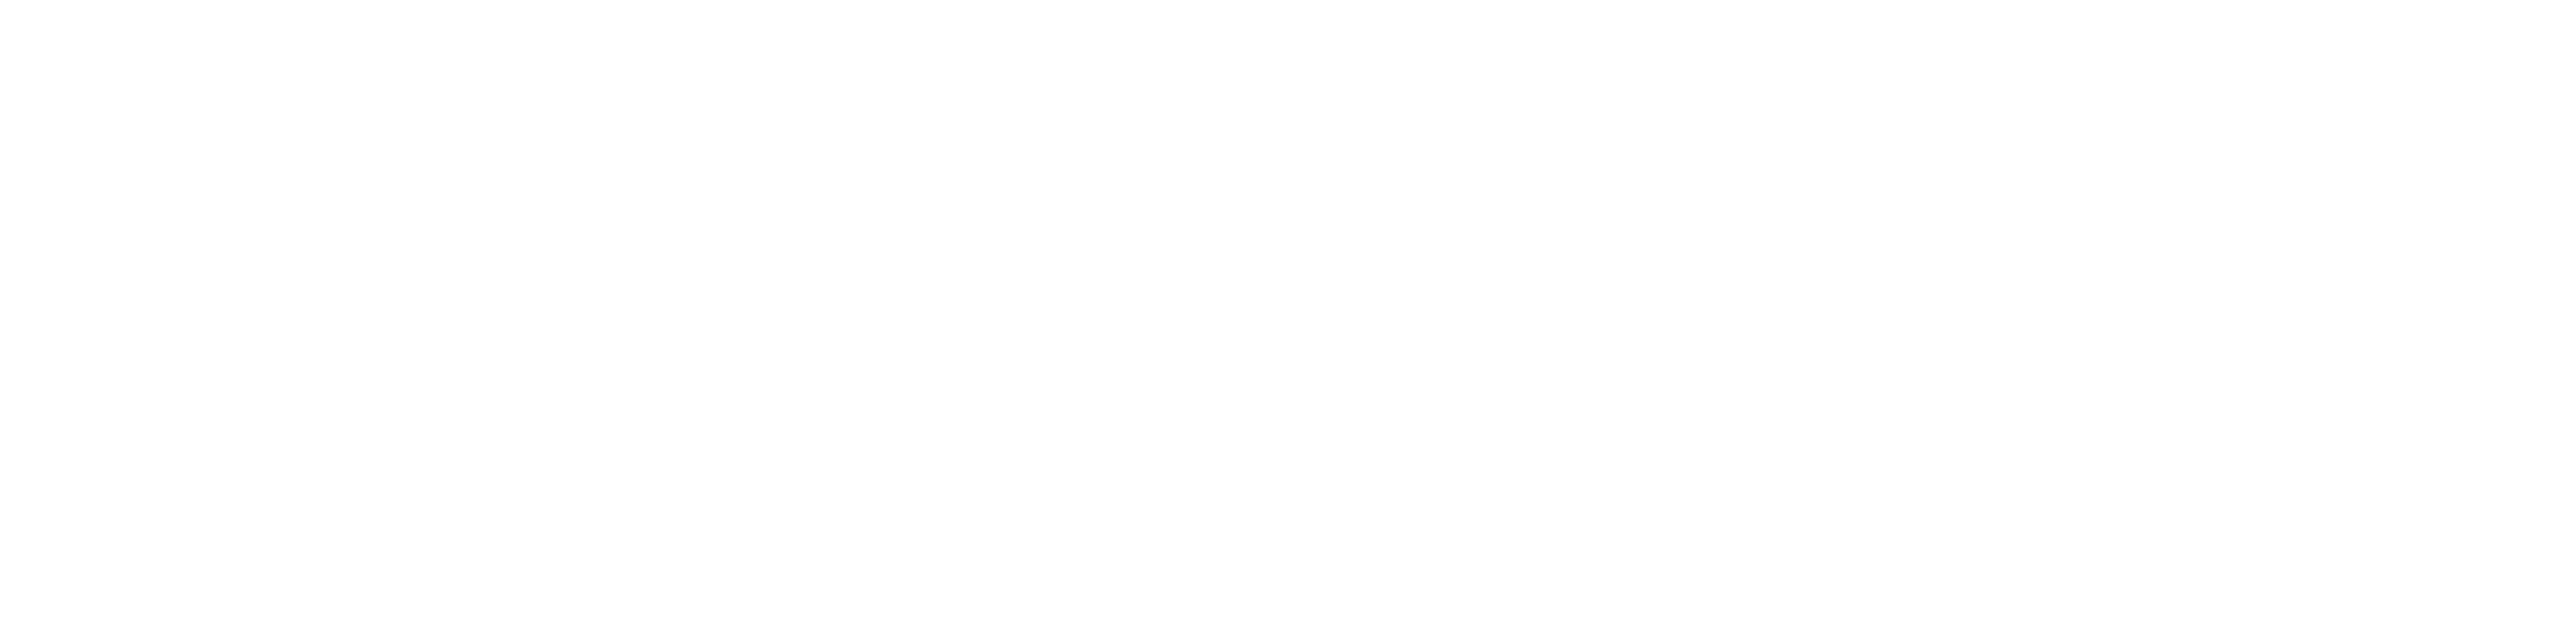

2020-06-07 19:09:48,556 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:09:54,670 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:00,772 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:06,927 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:13,053 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


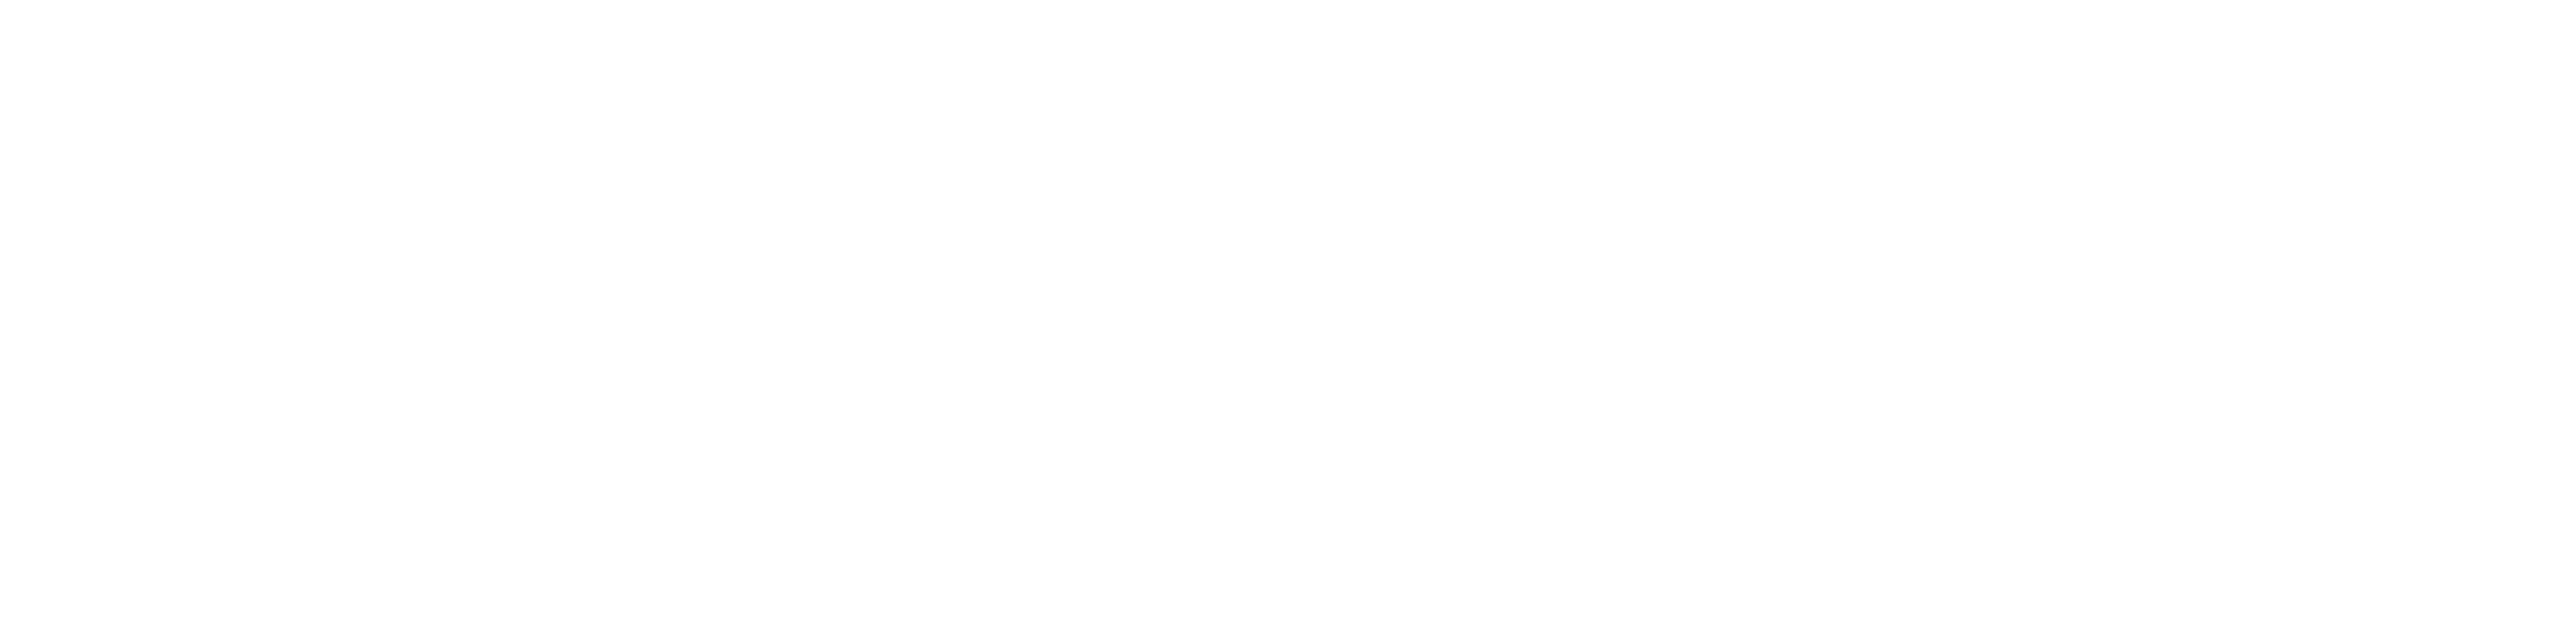

2020-06-07 19:10:37,121 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:43,209 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:49,346 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:10:55,459 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:11:01,606 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


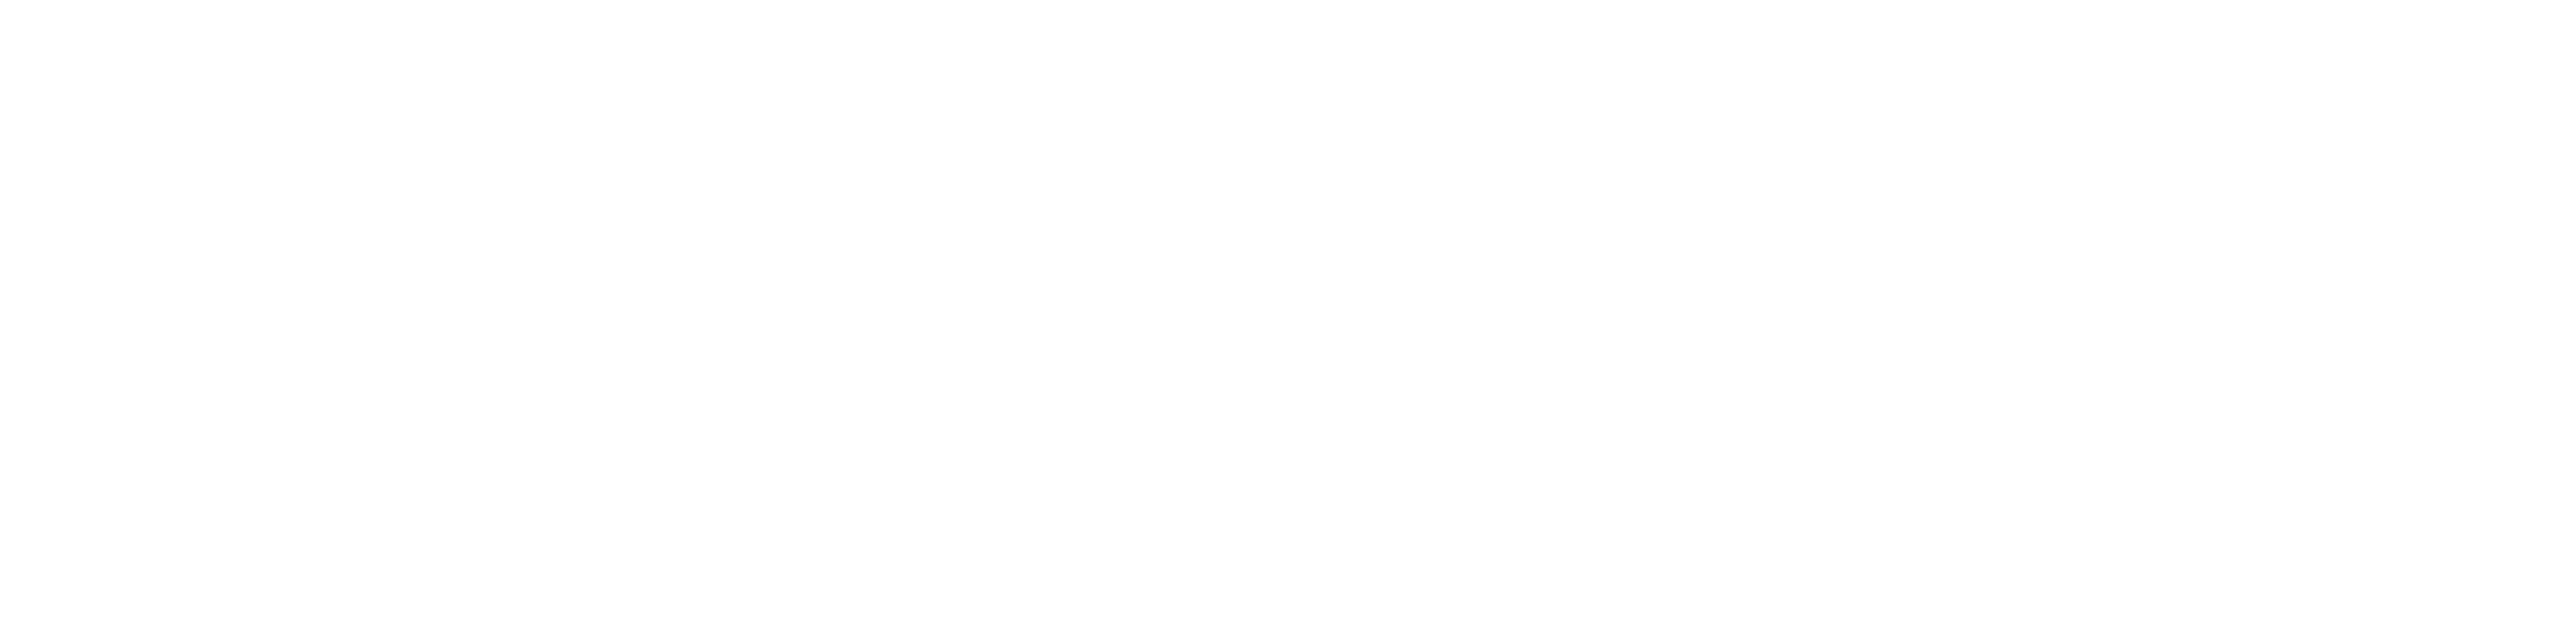

2020-06-07 19:11:25,607 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:11:31,871 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:11:38,085 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:11:44,337 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:11:50,521 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


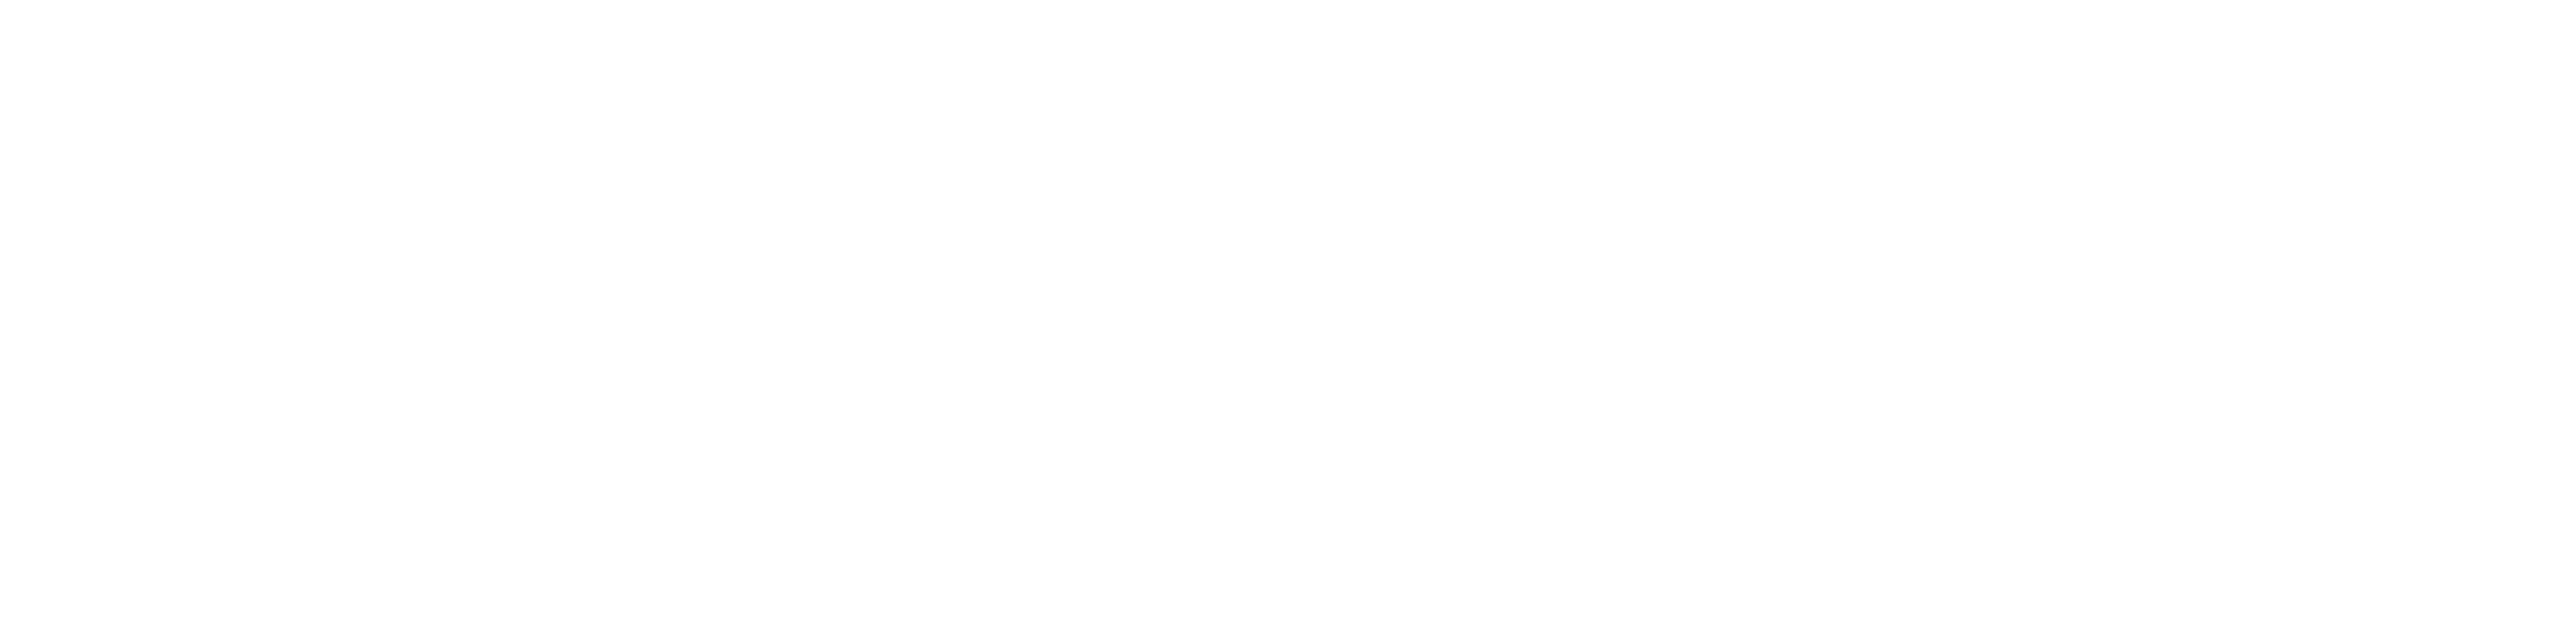

2020-06-07 19:12:16,696 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:12:22,776 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:12:28,916 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:12:35,024 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:12:41,173 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


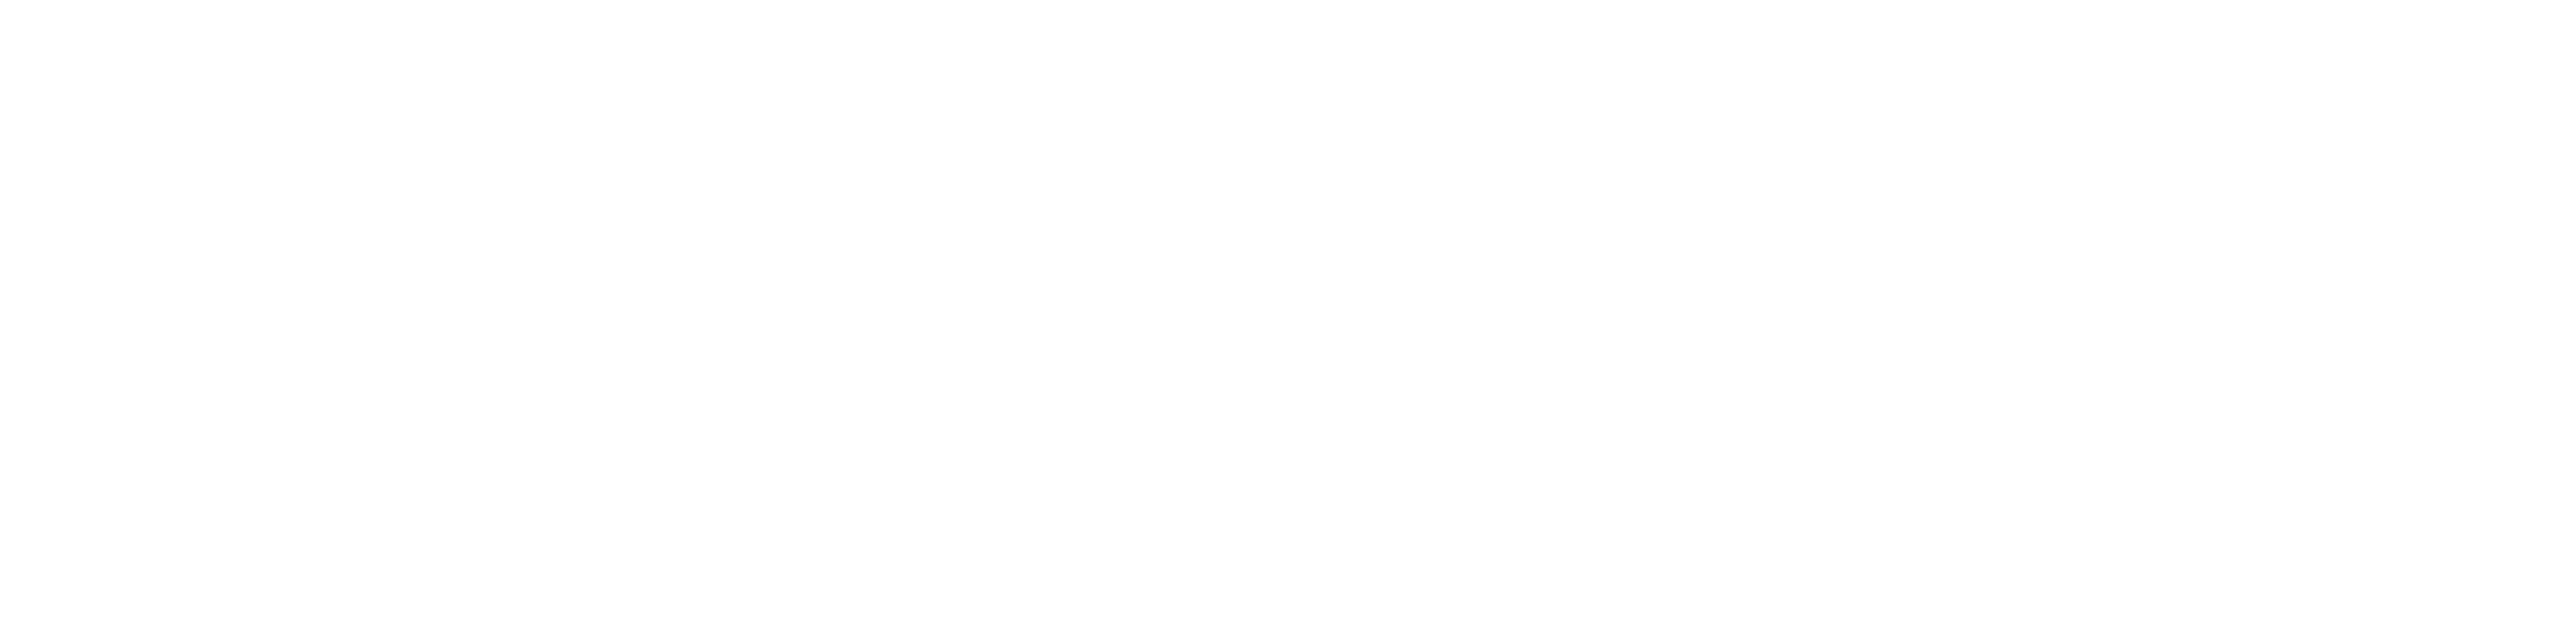

2020-06-07 19:13:05,240 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:13:11,488 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:13:17,671 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:13:23,907 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:13:30,094 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


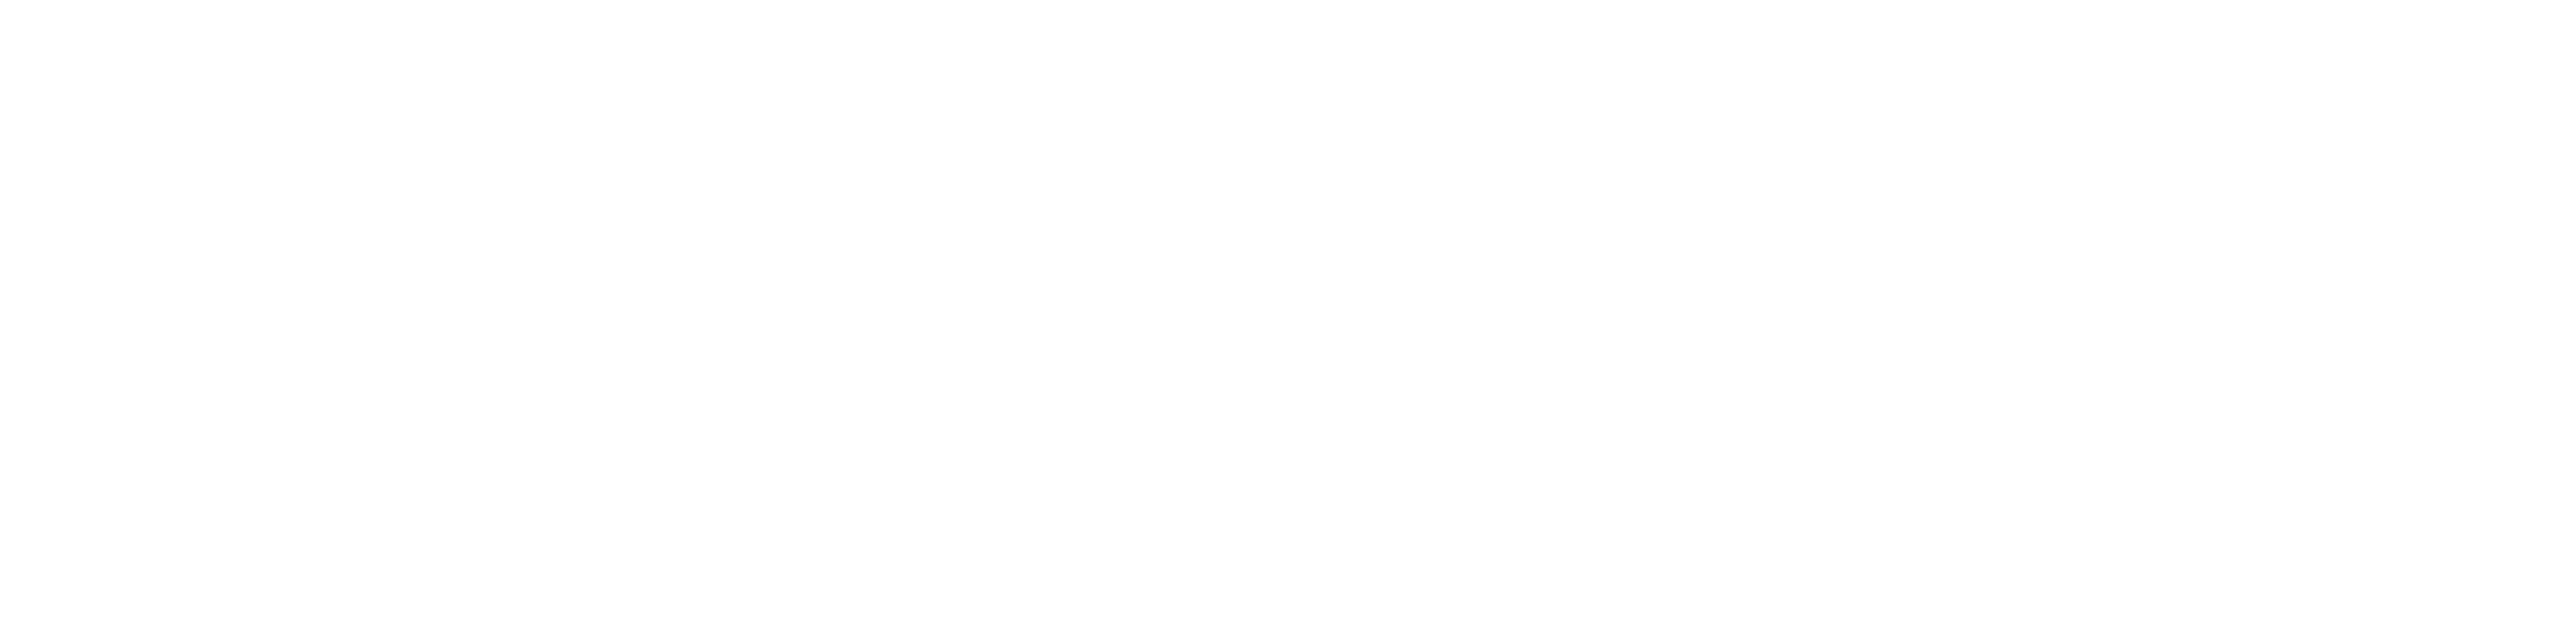

2020-06-07 19:13:54,014 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:00,086 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:06,301 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:12,642 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:18,897 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


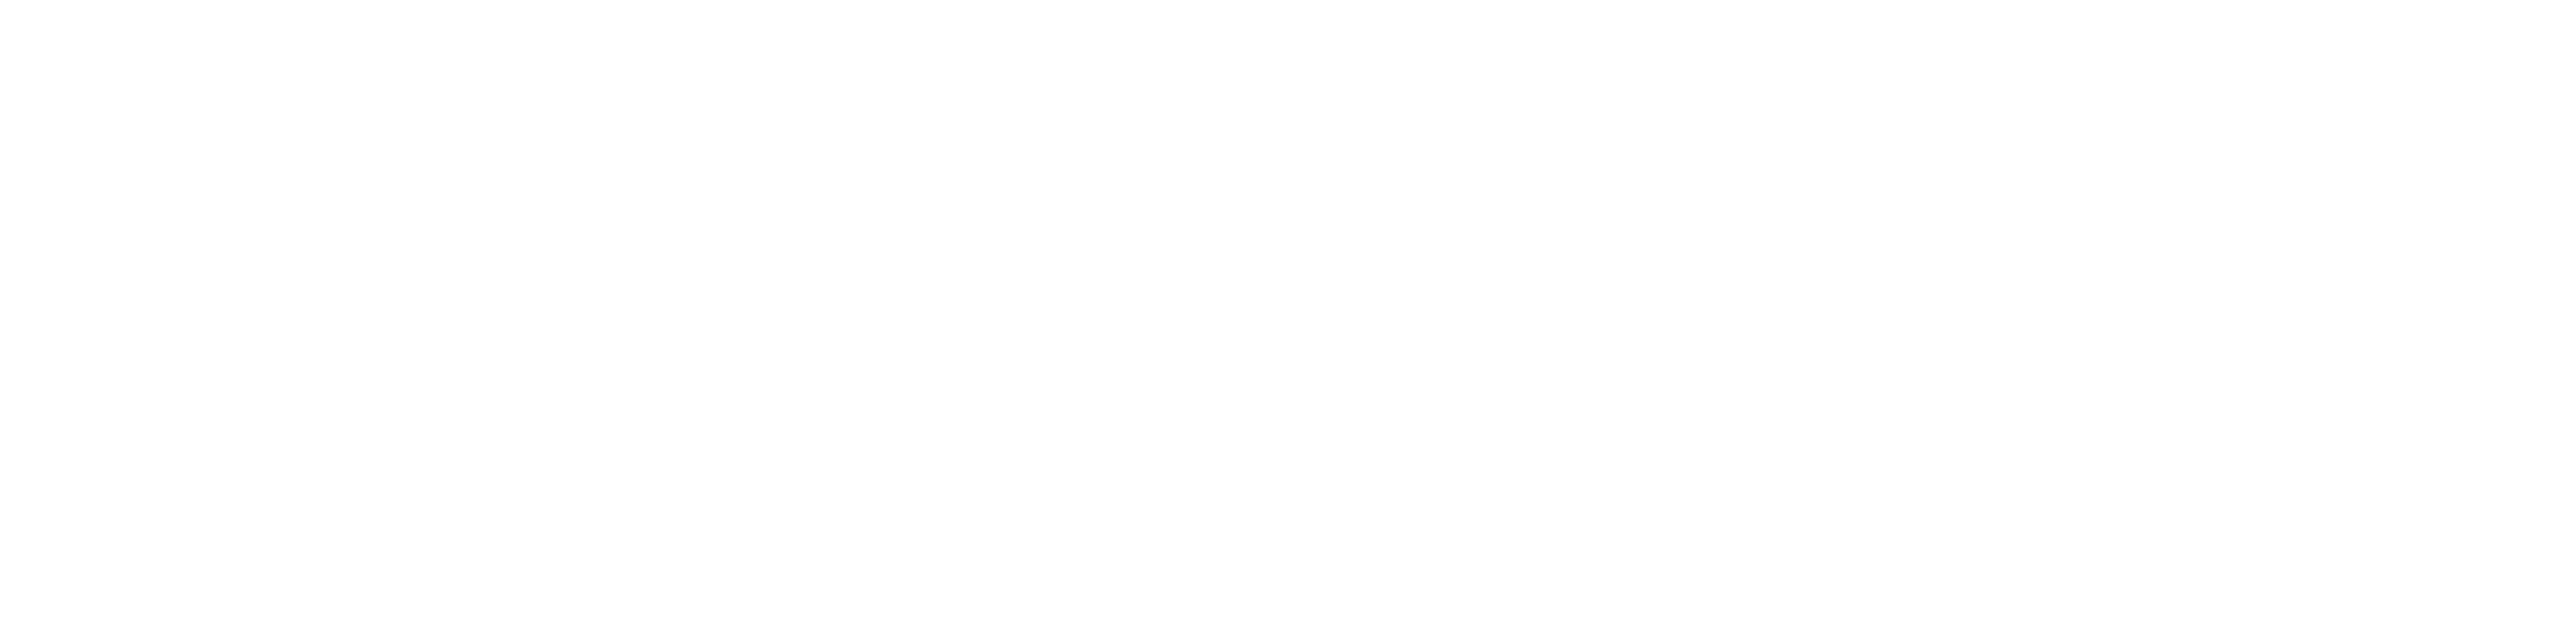

2020-06-07 19:14:43,009 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:49,199 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:14:55,404 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:01,583 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:07,749 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


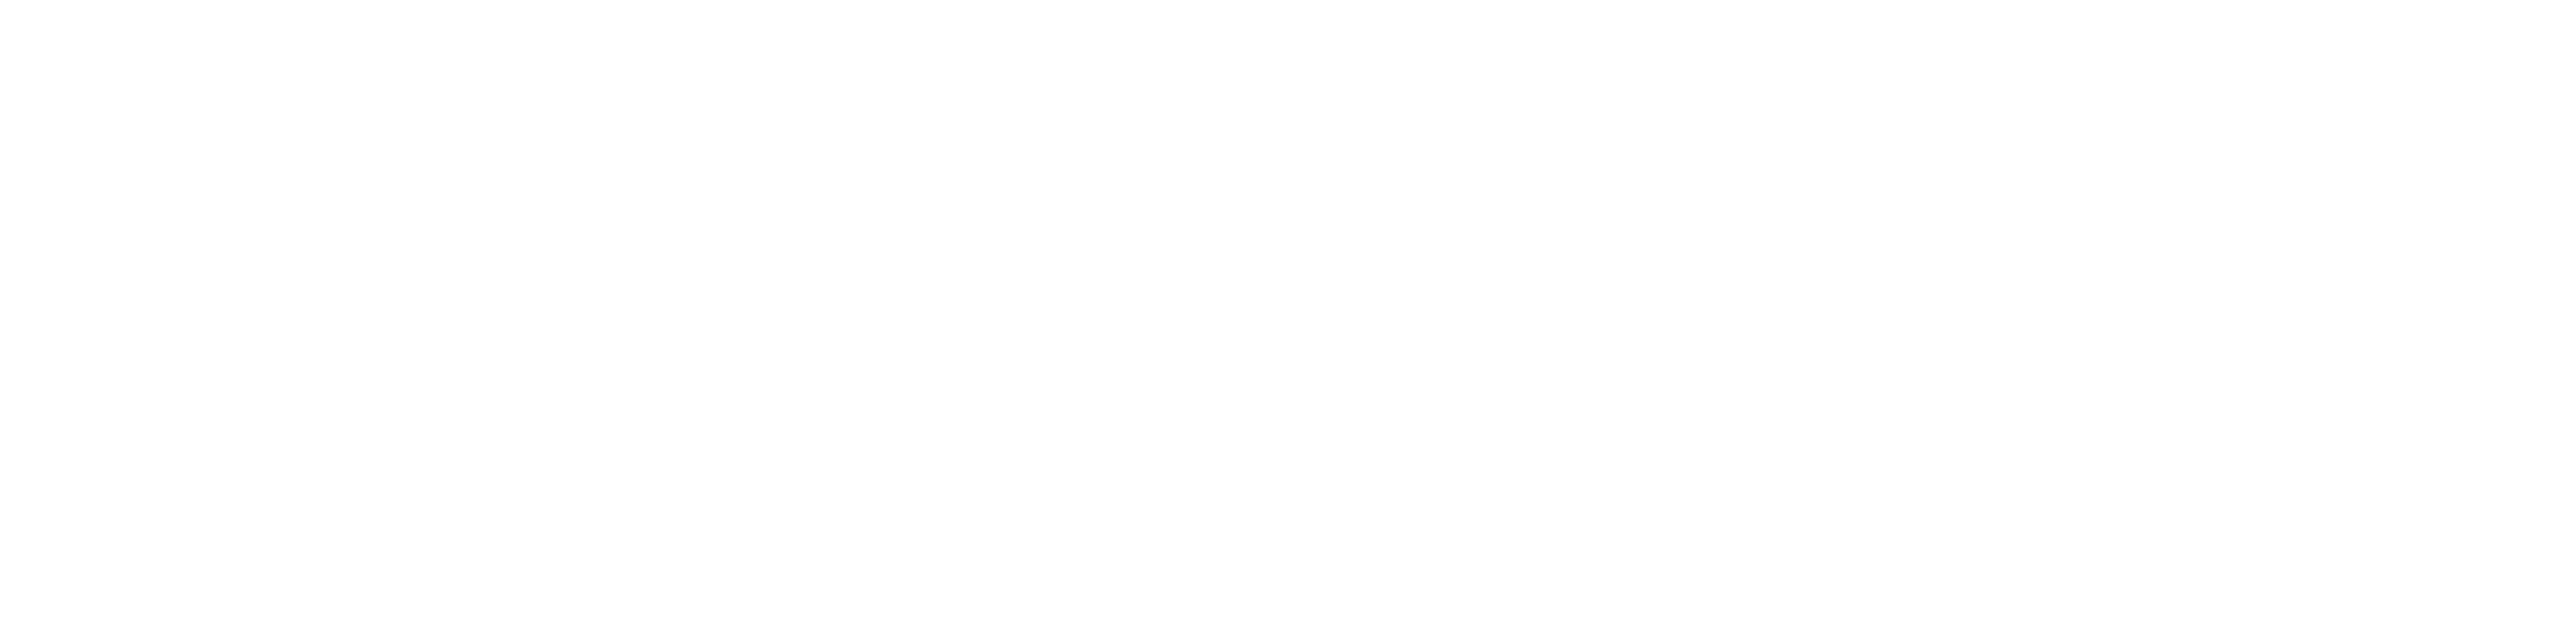

2020-06-07 19:15:31,620 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:37,740 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:43,830 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:49,969 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:15:56,076 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


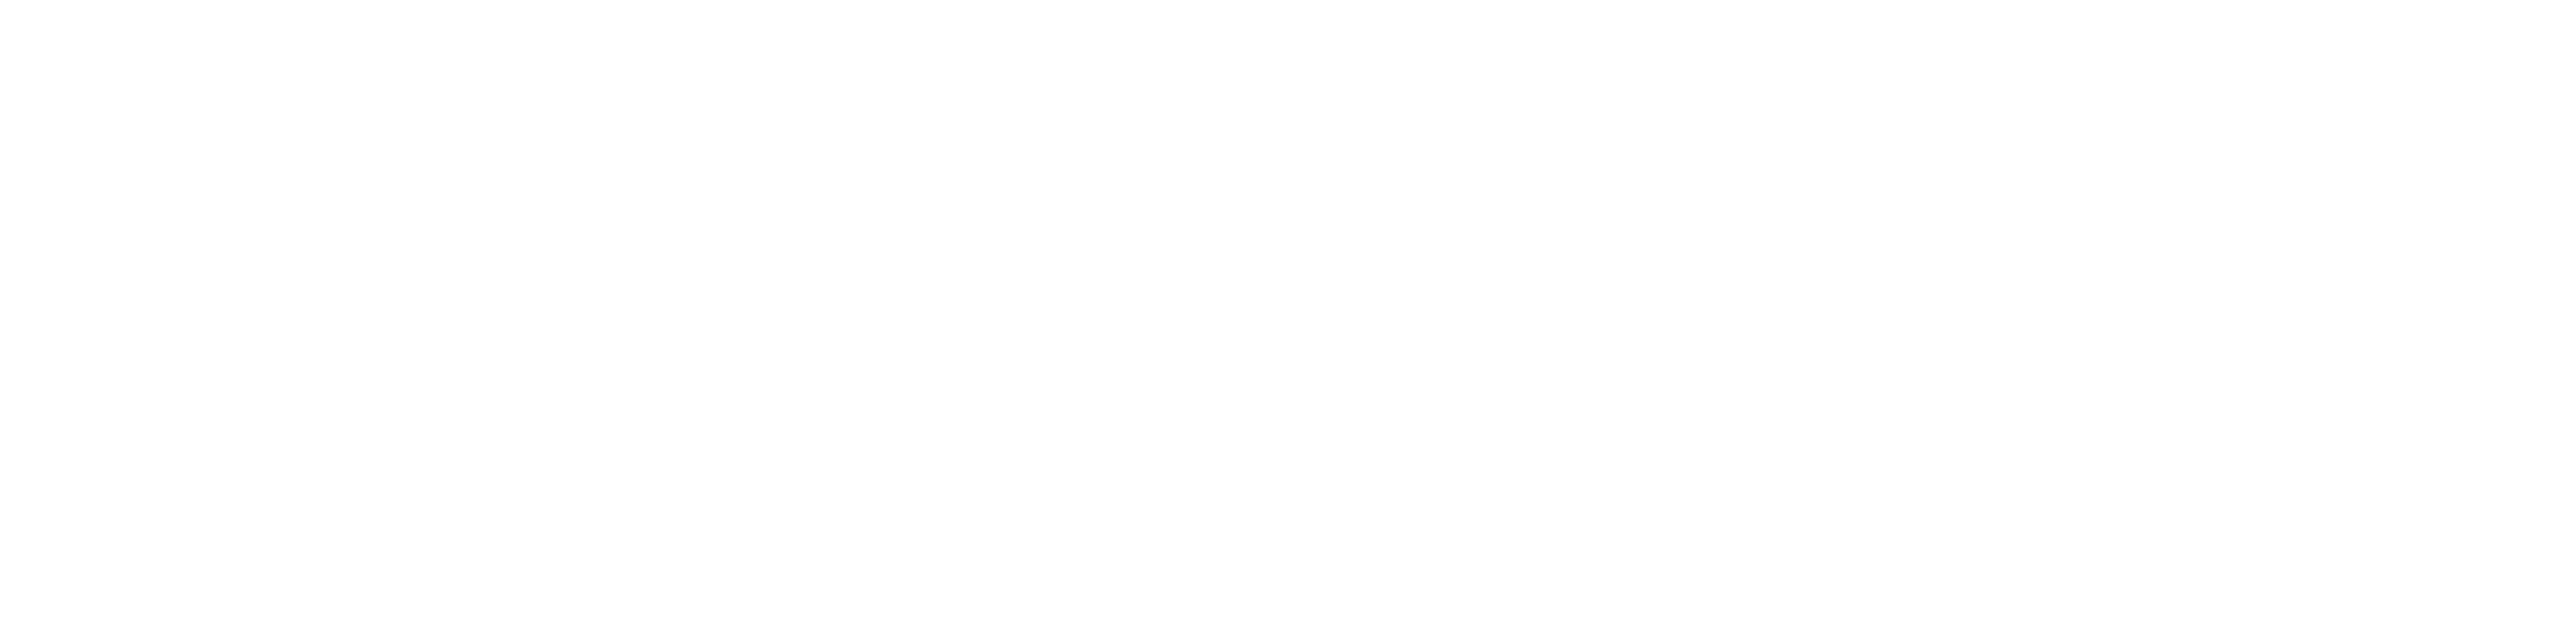

2020-06-07 19:16:19,939 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:16:26,027 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:16:32,151 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:16:38,256 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:16:44,408 logger INFO loss 3.31, MemUsed:50.05
Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


<IPython.core.display.Javascript object>


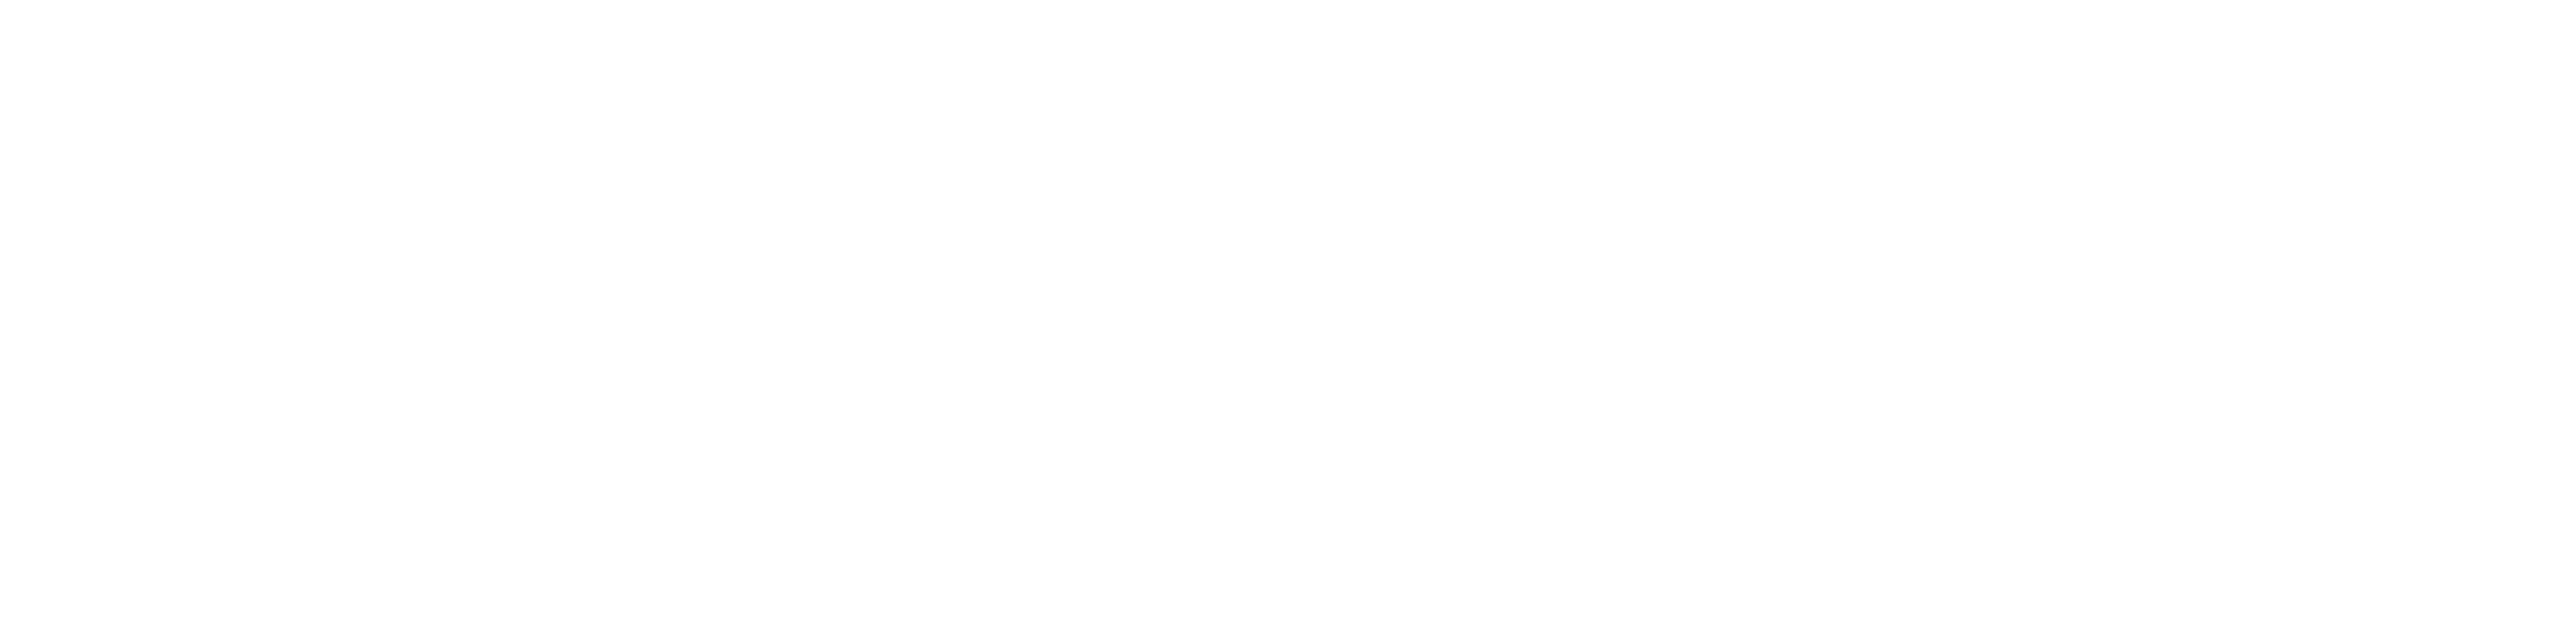

2020-06-07 19:17:08,263 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:17:14,534 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:17:20,875 logger INFO loss 3.31, MemUsed:50.05
2020-06-07 19:17:27,160 logger INFO loss 3.31, MemUsed:50.05



In [28]:
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))
# saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        # refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        refImg = torch.tensor(imagesRef[iCam], dtype=torch.float64, device=device, requires_grad=False)

        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[0, ..., 3], p=1) / torch.norm(refImg + images[0, ..., 3] - refImg * images[0, ..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
    loss = cfg.lpSmootherW * mesh_laplacian_smoothing(mesh) + cfg.normalSmootherW * mesh_normal_consistency(mesh)
    loss.backward()
    lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()

#     dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
#     dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, MemUsed:%.2f' \
        % (lossVal, memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy()[0, ..., 3] - imagesRef[iCam])
                diffImages.append(imgDiff)
                torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5, pytorch3DImg=False)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


In [32]:
def visualize2DSilhouetteResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                imgAlpha = images[iCam][0,...,3]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam]) * 0.5
#                     fgMask = np.logical_not(np.where())
#                     for iChannel in range(3):
                    img[..., 0] = img[..., 0] + imgAlpha * 0.5
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
images = []
outImgFile = join(outFolderForExperiment, 'FinalImage.png')
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())

visualize2DSilhouetteResults(images, outImgFile=outImgFile)

In [29]:
diffImages[0].shape

(1080, 1080)

In [30]:
np.max(diffImages[0])

1.0

In [31]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)

Before release: active_bytes.all.current: 50.050048 MB
After release: active_bytes.all.current: 50.050048 MB


ValueError: operands could not be broadcast together with shapes (1,1080,1080,4) (1080,1080) 